# Thesis work--2
# A new method for multivariate regression problem for improving fitness in Genetic Programming

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange, uniform
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from gplearn.genetic import SymbolicRegressor
from matplotlib.pyplot import figure
import math

### Global variables and functions for tuning

In [6]:
FEATURES = 2
NUMBER_OF_GENERATION = 20
ROWS = 300
POPULATION_SIZE = 400
TEST_SIZE = .2
NUMBER_OF_REGIONS = 3
# Equation 1
# formula = lambda X: X[:, 0]**2 - X[:, 1]**2 + X[:, 1] - 1 
# Equation 2
formula = lambda X: 0.3 * X[:,0] * np.sin(2*math.pi*X[:,1])

### Generating Training Samples

In [7]:
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)

### Splitting the dataset into the Training set and Test set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### Applying PCA

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
#print(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
#print(X_train_pca)
#print(X_test_pca)
# print(np.shape(X_train),np.shape(X_test))
#print(explained_variance)

### Calculating DV

In [10]:
# sort X_train_pca and y_train by index
sorted_indexes = np.argsort(X_train_pca,axis=0)
sorted_x_train_pca = X_train_pca[sorted_indexes]
sorted_y_train = y_train[sorted_indexes]

# Finding Change of Slope
slope1 = []
slope2 = []
for itr in range(1,len(sorted_x_train_pca)):
    slope1.append((sorted_y_train[itr]-sorted_y_train[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))
for itr in range(1,len(slope1)):
    slope2.append((slope1[itr]-slope1[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))

# normalize slope2 
normalized_slope2 = (slope2-min(slope2))/(max(slope2)-min(slope2))

# Calculating Quantiles
normalized_slope2 = np.reshape(normalized_slope2,len(normalized_slope2))
quantile_ranges = pd.qcut(normalized_slope2,NUMBER_OF_REGIONS,labels=False,retbins=True)
quantile_ranges = quantile_ranges[1]

# Adding the difficult Vectors
difficult_points = {}
for q_ind in range(NUMBER_OF_REGIONS):
    low = quantile_ranges[q_ind]
    high = quantile_ranges[q_ind+1]
    difficult_points[q_ind] = []
    for n_ind in range(0,len(normalized_slope2)):
        if normalized_slope2[n_ind] >= low and normalized_slope2[n_ind] <= high:
            difficult_points[q_ind].append(n_ind)
print(difficult_points)

{0: [3, 13, 15, 20, 21, 26, 28, 30, 32, 34, 36, 38, 42, 43, 45, 50, 51, 53, 54, 56, 58, 60, 62, 65, 68, 70, 71, 73, 77, 80, 83, 85, 90, 94, 97, 99, 101, 103, 105, 112], 1: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 16, 17, 18, 27, 39, 47, 48, 59, 66, 67, 75, 86, 87, 88, 89, 91, 92, 95, 98, 103, 106, 107, 108, 109, 110, 111, 114, 115, 116, 117], 2: [4, 6, 12, 14, 19, 22, 23, 24, 25, 29, 31, 33, 35, 37, 40, 41, 44, 46, 49, 52, 55, 57, 61, 63, 64, 69, 72, 74, 76, 78, 79, 81, 82, 84, 93, 96, 100, 102, 104, 113]}


### Training of converted PCA

In [11]:
est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                           generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)


### Getting the different regions of difficulty level

In [12]:
# Hard to evolve points
hard_to_evolve_x = X_train_pca[difficult_points[0]]
hard_to_evolve_y = y_train[difficult_points[0]]

# Medium to evolve points
medium_to_evolve_x = X_train_pca[difficult_points[1]]
medium_to_evolve_y = y_train[difficult_points[1]]

# Easy to evolve points
easy_to_evolve_x = X_train_pca[difficult_points[2]]
easy_to_evolve_y = y_train[difficult_points[2]]


### Feed the system hard to evolve points first

In [13]:
est_gp.fit(hard_to_evolve_x,hard_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.62 64.86421291147391       15 0.4498421247724984 0.6663172569708122      8.93s
   1    10.74 1.3497138931757109        7 0.4385271427564137 0.6069332138744191     10.54s
   2     6.76 0.8060936604726276        7 0.42743599431100293 0.7942092135481486      9.97s
   3     4.86 0.7372122088885127        3 0.41906902517628924 0.894260345346749      9.09s
   4     3.38 0.7001076607329838        3 0.4219714658525164 0.8433899696745277      8.28s
   5     3.63 0.6955178701873973        3 0.4227236793297786 0.8366200483791677      7.52s
   6     3.26 0.8436678868498708        3 0.4222764485469741 0.8406451254244081      6.74s
   7     3.38 1.2397048674647635        3 0.4142932311902229 0.9372424912213468      6.11s
   8     3.37 0.84723826966

### Feed the system Medium to evolve points keeping the current modal state appending generation by current generation

In [14]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*2, warm_start=True)
est_gp.fit(medium_to_evolve_x,medium_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20      3.1 0.8352289822995083        3 0.6316551398902879 1.2918705427097619      0.44s
  21     3.54 1.1364610419348338        3 0.6305949648286047 1.3014121182649108      0.79s
  22      3.7 1.3750694391909242        3 0.6416816091355975 1.201632319501976      1.08s
  23     3.29 0.903193175075043        3 0.6397648294186951 1.2188833369540983      1.26s
  24     3.39 1.3139962582987172        5 0.6312147421635126 1.1556034107836208      1.43s
  25     3.22 0.8761684430353899        3 0.5927685191390819 1.14315168970623      1.53s
  26     3.44 0.9759733959239375        3 0.5986184052283483 1.090502714902833      1.59s
  27     3.37 0.8513387227023838        3 0.6052187247692903 1.0310998390343546      1.64s
  28      3.4 1.0941455873940642

### Same process but for easy to evolve points and this is our result

In [12]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*3, warm_start=True)
est_gp.fit(easy_to_evolve_x,easy_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     5.56 1.3826835874818966        5 0.4267099561006126 1.0382196834949988      0.25s
  41     5.65 1.1283526081175839        5 0.43380834472817964 0.9743341858468948      0.42s
  42     5.15 1.2982424272198967        7 0.3586519772549437 0.4676661152019958      0.60s
  43     5.38 2.313528759890423        7 0.3574685028562641 0.47831738479011243      0.74s
  44     6.04 0.9380894201342194        7 0.32200319197302285 0.797505182739283      0.89s
  45     7.34 1.0247895655139905        7 0.322909960559394 0.7893442654619429      1.02s
  46      7.4 1.2534829078501897        7 0.30928489334209175 0.9119698704176632      1.15s
  47     7.42 2.6615992258033248        7 0.3357815941608486 0.6734995630488516      1.32s
  48     7.02 1.4091321896

### Training of data without PCA without DV

In [13]:
# Generating random data
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)
# Dividing it into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = 0)
# Training the system
est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                           generations=NUMBER_OF_GENERATION*3, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train,y_train)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    37.62 3240.640395038094        7 0.6545326193170877 0.6616696381861505     27.60s
   1     10.7 92.47048856168368       33 0.4709350621474633 0.2862887087816357     43.32s
   2     8.14 1.273082989831628        9 0.3569102194188221 0.3925020603803262     41.52s
   3     5.94 0.9222795634594203        9 0.28938466071396307 0.22662414357543156     44.05s
   4     7.12 0.9018641283795599        9 0.27050030819879933 0.39658331621190523     42.21s
   5      7.2 1.4341901879856875       13 0.2544773141806192 0.42613402596172145     42.16s
   6     8.99 1.2355242305923293        9 0.253047676152755 0.5536570046263042     40.91s
   7     9.06 0.7637524505958402       11 0.2545534634939961 0.3196812755892966     40.15s
   8     9.14 0.7732535419

### Calculate fitness 

In [14]:
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Fitness of Training of data without PCA without DV: ',str(fitness))

Fitness of Training of data without PCA without DV:  0.1583493614822914


### Training of data with PCA without DV

In [15]:
# Generating random data
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)

# Dividing it into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = 0)

# Convert it to PCA
pca = PCA(n_components = 1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Training the system
est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                           generations=NUMBER_OF_GENERATION*3, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train_pca,y_train)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.62  73.561646844872       15 0.45794064423252584 0.5832914875042755     37.30s
   1    12.11 2.2732534282980037        7 0.37893692918293836 0.5132012503244892     44.49s
   2      8.2 1.199192283177446        7 0.37817371139549316 0.5200702104114959     43.38s
   3     6.06 0.9396369646395795        7 0.38028213399020167 0.42934383959468914     40.62s
   4     5.74 0.9382336536739111        7 0.3675312186046419 0.6158526455291579     38.79s
   5     7.14 0.9837011059871148        7 0.3669262113467895 0.621297710849829     38.90s
   6     7.04 1.1911653009775511        7 0.35647760357587505 0.7153351807880591     38.34s
   7     7.15 1.3965400296965695        7 0.36429674944117313 0.6449628680003767     38.20s
   8      7.2 1.21795504

### Calculate Fitness

In [16]:
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = est_gp.predict(np.c_[x0.ravel()]).reshape(x0.shape)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Training of data with PCA without DV: '+str(fitness))

Training of data with PCA without DV: 1.6208536829478182


### Training of data with PCA with DV

In [55]:
def train_pca_dv(seed_value):
    # Generating random data
    rng = check_random_state(seed_value)
    X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
    Y = formula(X)

    # Dividing it into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = 0)
    list_of_x_test.append(X_test)
    list_of_y_test.append(y_test)
    # Convert it to PCA
    pca = PCA(n_components = 1)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Applying DV
    # sort X_train_pca and y_train by index
    sorted_indexes = np.argsort(X_train_pca,axis=0)
    sorted_x_train_pca = X_train_pca[sorted_indexes]
    sorted_y_train = y_train[sorted_indexes]

    # Finding Change of Slope
    slope1 = []
    slope2 = []
    for itr in range(1,len(sorted_x_train_pca)):
        slope1.append((sorted_y_train[itr]-sorted_y_train[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))
    for itr in range(1,len(slope1)):
        slope2.append((slope1[itr]-slope1[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))

    # normalize slope2 
    normalized_slope2 = (slope2-min(slope2))/(max(slope2)-min(slope2))

    # Calculating Quantiles
    normalized_slope2 = np.reshape(normalized_slope2,len(normalized_slope2))
    quantile_ranges = pd.qcut(normalized_slope2,NUMBER_OF_REGIONS,labels=False,retbins=True)
    quantile_ranges = quantile_ranges[1]

    # Adding the difficult Vectors
    difficult_points = {}
    for q_ind in range(NUMBER_OF_REGIONS):
        low = quantile_ranges[q_ind]
        high = quantile_ranges[q_ind+1]
        difficult_points[q_ind] = []
        for n_ind in range(0,len(normalized_slope2)):
            if normalized_slope2[n_ind] >= low and normalized_slope2[n_ind] <= high:
                difficult_points[q_ind].append(n_ind)
    # Hard to evolve points
    hard_to_evolve_x = X_train_pca[difficult_points[0]]
    hard_to_evolve_y = y_train[difficult_points[0]]

    # Medium to evolve points
    medium_to_evolve_x = X_train_pca[difficult_points[1]]
    medium_to_evolve_y = y_train[difficult_points[1]]

    # Easy to evolve points
    easy_to_evolve_x = X_train_pca[difficult_points[2]]
    easy_to_evolve_y = y_train[difficult_points[2]]

    # Training the system
    est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                               generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                               p_crossover=0.7, p_subtree_mutation=0.1,
                               p_hoist_mutation=0.05, p_point_mutation=0.1,
                               max_samples=0.9, verbose=1,
                               parsimony_coefficient=0.01, 
                               random_state=0, 
                               init_depth=(2,17)
                              )
    est_gp.fit(hard_to_evolve_x,hard_to_evolve_y)
#     print(est_gp._program)
    est_gp.set_params(generations=NUMBER_OF_GENERATION*2, warm_start=True)
    est_gp.fit(medium_to_evolve_x,medium_to_evolve_y)
#     print(est_gp._program)
    est_gp.set_params(generations=NUMBER_OF_GENERATION*3, warm_start=True)
    est_gp.fit(easy_to_evolve_x,easy_to_evolve_y)
    print(est_gp._program)
    list_of_est_program.append(str(est_gp._program))
    x0 = X_test[:,0]
    x1 = X_test[:,1]
    predicted_formula_result_y = est_gp.predict(np.c_[x0.ravel()]).reshape(x0.shape)
    fitness = mean_squared_error(y_test, predicted_formula_result_y)
    print('Training of data with PCA with DV: '+str(fitness))
    list_of_fitness.append(str(fitness))

In [56]:
list_of_fitness = []
list_of_est_program = []
list_of_x_test = []
list_of_y_test = []
for itr in range(0,20):
    print('Run :',itr+1)
    train_pca_dv(itr) 

Run : 1
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0  34438.9 1.1207478835364914e+56        7 0.6415020848222629 0.8565181100260962     74.04m
   1    20.46 1.9791146456120372        7 0.4516293623188091 0.5385158797199848     35.94m
   2      8.3 1.5232141056159176        5 0.38509015737798596 0.7548553836238179     22.95m
   3     7.24 8.50713673663683       11 0.3443478711539696 0.9108005944479538     16.67m
   4     5.85 1.2343594113532774       11 0.3834076910299042 0.5592622155645431     12.65m
   5     6.06 3.9579073733524943        5 0.355481330777238 1.02133482303055     10.02m
   6      5.3 1.7054419961940102        5 0.3572065149295345 1.0058081656598816      8.24m
   7     5.39 4.069511418643701        5 0.364536872022341 0.9398349518246225      6.82m
   8     6.16 1.07989

  19      1.7 19.193045555117227        1 0.3597325428646895 1.0496613126830856      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     1.56 0.556563287072702        1 0.3712311903496276 1.4749293265583898      4.55s
  21     2.88 3.6060176015416867        1 0.40582289872218547 1.1636039512053689     15.59s
  22     2.54 9.111250863619206        1 0.40359239872289276 1.1836784511990033     19.72s
  23     1.42 0.5875884115968358        1 0.3867089521208598 1.3356294706172993     22.59s
  24     1.54 1.0242656821036888        1 0.40974635699349776 1.128292826763558     23.62s
  25     2.45 305316.06966201076        1 0.3801131151233208 1.3949920035951506     24.26s
  26     2.18 1.5786804482141477        1 0.3878344616021539 1.3254998852856528     25.69s
  27     1.54 0.71123640708

  38     4.76 1.2547428053785659        3 0.3043187743022173 0.8405221566687102      3.54s
  39     3.46 1.2352826421502738        3 0.29711398907426506 0.7050733343639235      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     4.28 0.8666327623606555        3 0.4205480231797404 0.8048573408963697      3.90s
  41     3.71 1.0091967007158442        3 0.41066813522863876 0.8937763324562845      7.62s
  42     3.47 0.726554631379158        3 0.417778243546947 0.8297853575915108     10.23s
  43     3.24 0.7580706135481943        3 0.4160918591182095 0.8449628174501478     11.29s
  44     3.72 2.442480460707094        5 0.39402911525506007 0.45520530690977357     12.35s
  45     3.53 0.7621783380024604        5 0.35184173780910677 0.8348917039233527     13.20s
  46     4.26 0.988263127

KeyboardInterrupt: 

In [51]:
print('Predicted functions of ' +str(len(list_of_est_program)) +' Runs with tree depth (2,17)')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind])

Predicted functions of 20 Runs with tree depth (2,17)
Function 0 add(-0.848, sub(X0, mul(X0, X0)))
Function 1 -0.723
Function 2 add(-0.993, add(X0, -0.197))
Function 3 add(-0.974, X0)
Function 4 -0.824
Function 5 add(X0, -0.974)
Function 6 -0.765
Function 7 add(-0.922, add(X0, -0.232))
Function 8 -0.823
Function 9 sub(-0.911, X0)
Function 10 add(-0.993, X0)
Function 11 add(-0.922, X0)
Function 12 sub(-0.986, X0)
Function 13 -0.823
Function 14 sub(X0, sub(0.888, -0.335))
Function 15 sub(-0.985, X0)
Function 16 sub(-0.902, X0)
Function 17 add(-0.922, X0)
Function 18 -0.697
Function 19 add(X0, -0.974)


In [38]:
print('Predicted functions of ' +str(len(list_of_est_program)) +' Runs with tree depth (6,10)')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind])

Predicted functions of 20 Runs with tree depth (6,10)
Function 0 sub(sub(X0, 0.778), mul(X0, X0))
Function 1 -0.801
Function 2 sub(X0, div(-0.957, -0.885))
Function 3 sub(sub(X0, 0.778), mul(X0, X0))
Function 4 -0.871
Function 5 sub(X0, div(X0, X0))
Function 6 -0.781
Function 7 sub(X0, sub(0.699, -0.444))
Function 8 sub(mul(X0, -0.458), 0.898)
Function 9 sub(-0.986, X0)
Function 10 sub(X0, 0.991)
Function 11 sub(X0, 0.902)
Function 12 sub(sub(0.081, X0), div(0.278, 0.231))
Function 13 -0.926
Function 14 sub(X0, add(0.729, 0.341))
Function 15 -0.785
Function 16 sub(mul(X0, 0.224), sub(X0, -0.947))
Function 17 add(-0.974, X0)
Function 18 -0.769
Function 19 add(-0.929, X0)


In [19]:
print('Predicted functions of ' +str(len(list_of_est_program)) +' Runs with tree depth (2,6)')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind]+' With fitness '+' '+list_of_fitness[ind])

Predicted functions of 20 Runs with tree depth (2,6)
Function 0 sub(-0.749, sub(mul(X0, X0), X0)) With fitness  1.5464592643832455
Function 1 -0.713 With fitness  0.5755026098148425
Function 2 add(sub(X0, 0.159), -0.965) With fitness  0.9643061484795903
Function 3 sub(add(-0.834, X0), mul(X0, X0)) With fitness  1.1616546820083762
Function 4 -0.803 With fitness  0.6143737679833474
Function 5 sub(-0.931, mul(X0, -0.606)) With fitness  0.7717159012760556
Function 6 -0.765 With fitness  0.5277935220732879
Function 7 sub(sub(X0, 0.159), 0.971) With fitness  0.9920810334216495
Function 8 -0.931 With fitness  0.3008120488937444
Function 9 sub(-0.931, X0) With fitness  0.9781697851795068
Function 10 add(-0.986, X0) With fitness  0.4434641396982191
Function 11 sub(sub(X0, 0.834), mul(X0, X0)) With fitness  1.2510682270227254
Function 12 sub(sub(-0.440, X0), 0.671) With fitness  0.6388961110948697
Function 13 -0.749 With fitness  0.8471336680119064
Function 14 sub(sub(X0, 0.159), 0.946) With fit

### Calculate fitness

In [47]:
# add(-0.993, add(X0, -0.197))
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = -.993+(x0-.197)
# predicted_formula_result_y = (x0-.877)-(x0*x0)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Training of data with PCA with DV: '+str(fitness))

Training of data with PCA with DV: 1.2656720723586143


# Visulaiztions

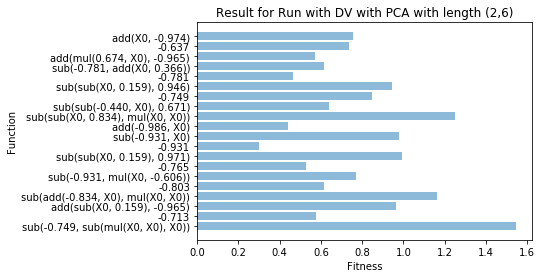

In [51]:
# Round the fitness to 3 decimal points for easy visualizaiton
list_of_rounded_fitness = []
for fitness in list_of_fitness:
    list_of_rounded_fitness.append(round(float(fitness),3))
objects = list_of_est_program
y_pos = np.arange(len(objects))
performance = list_of_rounded_fitness
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Function')
plt.xlabel('Fitness')
plt.title('Result for Run with DV with PCA with length (2,6)')
 
plt.show()

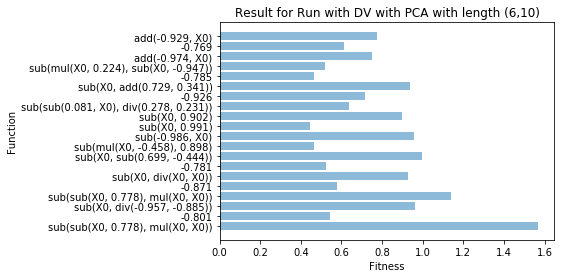

In [54]:
# Round the fitness to 3 decimal points for easy visualizaiton
list_of_rounded_fitness = []
for fitness in list_of_fitness:
    list_of_rounded_fitness.append(round(float(fitness),3))
objects = list_of_est_program
y_pos = np.arange(len(objects))
performance = list_of_rounded_fitness
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Function')
plt.xlabel('Fitness')
plt.title('Result for Run with DV with PCA with length (6,10)')
 
plt.show()

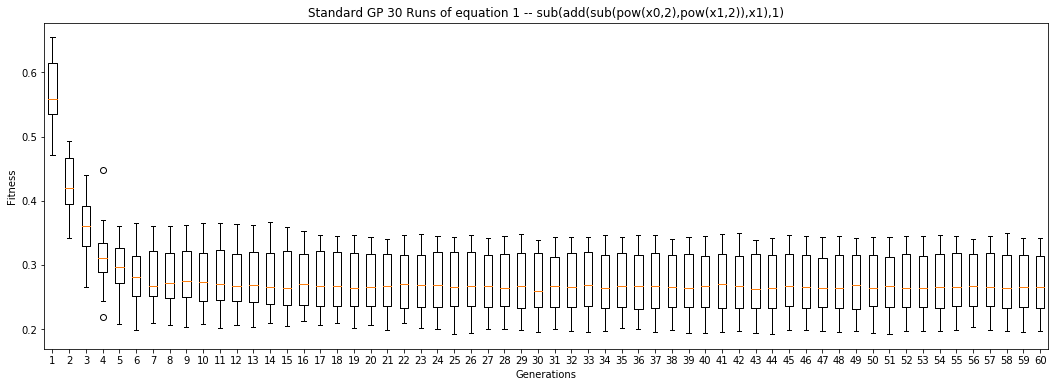

In [16]:
data = [[0.6545326193170877, 0.5034866507175532, 0.5916314599867414, 0.5456890496964114, 0.541132384843471, 0.5190096831410683, 0.5299072775748193, 0.5988122957875482, 0.5381812420337135, 0.5496788202250519, 0.6204318132830378, 0.5269853650536719, 0.6245698402338328, 0.5737775275298912, 0.6116779598185913, 0.5571421752647843, 0.6198924910900514, 0.6448423991551425, 0.503768250858107, 0.5942428731882591, 0.47125502519728135, 0.6165925252273311, 0.5700836336354455, 0.5597170144902269, 0.6492222132845684, 0.535156179228019, 0.6355300598662423, 0.49459937767247897, 0.5369713639415012, 0.5417572433082436], [0.4709350621474633, 0.4354270502971246, 0.4257583802618658, 0.3441158638793553, 0.493701714724974, 0.48199468834746284, 0.39458997273105906, 0.36721127290426686, 0.3752003955423844, 0.4805855734570671, 0.3949583001242018, 0.45147977129226136, 0.36651390435855186, 0.4084334973913348, 0.37420342733338363, 0.4673439138359971, 0.39435411210895194, 0.4091018430459062, 0.4871281515671441, 0.346430339504461, 0.4195683717749175, 0.40763114844531634, 0.44318603411596913, 0.4023624374299305, 0.4659269064000482, 0.34262136339313726, 0.43256134478399844, 0.42063740376632325, 0.47747108341626615, 0.47919684721328637], [0.3569102194188221, 0.4305657795750091, 0.37435694604201025, 0.26542844842453034, 0.3300994468679229, 0.32971079592922065, 0.3258866851468396, 0.3434100045048439, 0.36361453090347157, 0.3170196493739827, 0.3745726819708383, 0.42624953355266054, 0.2983817322247329, 0.37911696712743564, 0.33485919474240133, 0.44009598059938715, 0.3937411916821058, 0.40967587204966144, 0.42263960025427877, 0.3376514972065905, 0.31715673658620364, 0.3848926683543186, 0.34944636118477396, 0.3866207858152781, 0.3801903496646374, 0.2985977328964187, 0.4052336014337566, 0.3078891094926553, 0.4303786723687957, 0.3367086110369278], [0.28938466071396307, 0.27835777481601026, 0.31400487921109455, 0.26335053729725155, 0.3107178229501057, 0.33259549524653403, 0.2943285185091668, 0.3352073620933532, 0.2752388050308395, 0.2948395029928061, 0.36568417960729743, 0.2772289561033652, 0.28955068603051637, 0.3524482427287782, 0.2187351623834963, 0.31922760613364143, 0.44824350466870666, 0.32907873307753455, 0.369985785798708, 0.27472773584117977, 0.3104516588827726, 0.2978647396193434, 0.321229485735932, 0.3706884325168217, 0.3635825595476124, 0.2903212262478168, 0.24410788823039697, 0.30807584911033364, 0.3354101123141607, 0.3210819026068323], [0.27050030819879933, 0.27709463310763827, 0.3108640284183553, 0.24787690256164896, 0.29986368724100965, 0.32830646052906376, 0.2762325540900037, 0.3399819360679015, 0.26543594355126293, 0.25694974168123125, 0.3603442816471013, 0.28765508315965466, 0.28229638303488824, 0.348196760290412, 0.20823254011016548, 0.3033752858034702, 0.3087504406824817, 0.322216165450462, 0.3507294872579796, 0.2579233241258836, 0.29988897518982527, 0.2855240284148569, 0.31933405052928404, 0.3425230212841694, 0.3580826208773483, 0.2824598454299701, 0.23886263479064418, 0.2936147983901836, 0.3290665673694485, 0.26466441048100575], [0.2544773141806192, 0.2670564207002866, 0.2952714991434368, 0.24314300317602217, 0.30698431939474213, 0.3169043705007984, 0.24108268297056779, 0.3384056009275319, 0.2509169696135504, 0.25045967254374507, 0.3649751718591601, 0.27033852788646434, 0.2631039191419904, 0.3269583910934615, 0.198963679794814, 0.2615343460884802, 0.2970772685976801, 0.28289083643763274, 0.3422688106052018, 0.23867281954402092, 0.30064308101483583, 0.279805541816906, 0.31707446995236865, 0.33917973150101915, 0.3498943987860318, 0.274569107943969, 0.23556563753866527, 0.30152597753434296, 0.2886339705180252, 0.25123461269197883], [0.253047676152755, 0.26379827823456664, 0.2997661204253284, 0.24047796576752908, 0.30972647867080566, 0.320940134052189, 0.23717079814605496, 0.34101428521977756, 0.25358778132434906, 0.2459402805015969, 0.3603832825606378, 0.24730312377918504, 0.2632361513808111, 0.3239664015343551, 0.20921078367816456, 0.2589773684457137, 0.25809579945737565, 0.3280764079456332, 0.3349722408412336, 0.24861626100987386, 0.2967890630863187, 0.2792724208959889, 0.3209346337668751, 0.3467507257765242, 0.34859965365145706, 0.27005119212500533, 0.2310136583959591, 0.290335878149909, 0.2626111047525372, 0.25028554781571255], [0.2545534634939961, 0.2638178456219223, 0.296289857020843, 0.23980085066579035, 0.3116840508967733, 0.3190150590222366, 0.23455110886291525, 0.3363965760910521, 0.2485321756793305, 0.244936635656685, 0.3586964306782817, 0.2719590055643523, 0.27212357513791274, 0.3270674964152446, 0.20687778535710596, 0.2537105321045634, 0.24967333838451125, 0.3306611646444764, 0.3354146074547461, 0.24277995548249004, 0.2907693357453958, 0.27691304559925023, 0.3167325898181482, 0.3605296314024255, 0.3450339996488434, 0.270857322418888, 0.23260505284606398, 0.30127023697595867, 0.2587191092933291, 0.2454992699595558], [0.2578874746694214, 0.26688495636137133, 0.29834224053051367, 0.2411390441306727, 0.3099936903017983, 0.3229114376499683, 0.23052814683886544, 0.33519069307288374, 0.24905698560680414, 0.24504561957496604, 0.362321352181057, 0.3190251601458573, 0.2580534239691798, 0.32513893366789204, 0.20385606732909484, 0.24993725390729904, 0.2538120755042175, 0.32778194663491395, 0.33380843313535946, 0.2406954332328444, 0.288042357399689, 0.2778516325223064, 0.31180095553966714, 0.3628786349436254, 0.3378308294455126, 0.270479251547093, 0.23315456907307042, 0.29770780131022945, 0.25537602991379427, 0.24578844965217636], [0.25103982172368233, 0.26618731337276913, 0.3018248030740849, 0.24157207283536616, 0.30682263813484895, 0.3181808801752562, 0.22594845258805962, 0.3428635377922137, 0.24536229769608975, 0.24114467147308946, 0.35984413435843715, 0.3193926245902368, 0.2437355120361754, 0.32684015846392817, 0.20740890181671573, 0.24688866679069277, 0.250775557388165, 0.3306019231995678, 0.33696559661586806, 0.2433401999191295, 0.2954011794425725, 0.2780393719889797, 0.31824923079975215, 0.36456212833894874, 0.3435542687837271, 0.2675323748450654, 0.23158161269090158, 0.2991158145048731, 0.2538854311117958, 0.2435828412115988], [0.25074529390902633, 0.26367201530601164, 0.3039613624433382, 0.2383619073357982, 0.31014851635452095, 0.3232422223606752, 0.22708152113897662, 0.33872053589615014, 0.24649455326215144, 0.24446854448676875, 0.35757073339322193, 0.3217827092386027, 0.2402470042275222, 0.3283607494118782, 0.2013625213045456, 0.24999854178901332, 0.24562631513797464, 0.3247905245216669, 0.33626999384090855, 0.23626940509076697, 0.2993766513249635, 0.2779247664496974, 0.3167423767637839, 0.36529569661605343, 0.3461450347034325, 0.25722202376626185, 0.22951338148315184, 0.30317708357105516, 0.254328322860415, 0.24659066811207964], [0.2501265945882167, 0.2584739410401094, 0.29703765741668575, 0.2396755757880527, 0.3029867553493616, 0.30702376050784436, 0.23513695323731343, 0.3382778735139175, 0.2474188910911499, 0.24169070245119584, 0.36331134321277714, 0.3183973639484263, 0.24165378849662159, 0.32639303443904355, 0.20648700765521, 0.2493706140590279, 0.2502915842092933, 0.3293056813898507, 0.3358110605709249, 0.2346858009396088, 0.2931328194994239, 0.27642749709344694, 0.3154378117131625, 0.3588094086181482, 0.3432870642926388, 0.24141950613392987, 0.23394652619863857, 0.30009603996498996, 0.25256726676998725, 0.24838336077618361], [0.24845038728996147, 0.260146780884736, 0.29868815860169495, 0.23566756876165287, 0.3042069690177169, 0.32041135559409717, 0.2284494368418784, 0.3380263586984705, 0.24851711375160532, 0.24186563349973844, 0.36114761068196277, 0.3194146463575161, 0.23642629002670254, 0.32283685423015623, 0.20345284182827394, 0.25072492276872366, 0.2507363889640797, 0.329419791735573, 0.33807969120991815, 0.22974347818341376, 0.29921480789652777, 0.278731903800701, 0.3147706346771464, 0.36270701826659074, 0.3433539614888299, 0.23989477426241612, 0.23718394515833965, 0.29928537381713877, 0.2543326340128697, 0.24527920906694742], [0.25319904387689196, 0.2528134457222099, 0.30022566421340147, 0.22517340914748338, 0.30689271523086387, 0.3129804603215592, 0.22997635644183384, 0.3335995788527142, 0.24406061596917705, 0.23859242536589972, 0.36629021737336437, 0.31003625198844353, 0.23592026385934417, 0.32700376970687767, 0.20899375159075295, 0.24099842419608727, 0.25206731430468593, 0.3259751895333305, 0.33540291808009953, 0.2274302075181157, 0.29533738805380505, 0.2768541268990479, 0.31959328123315484, 0.36665935883091677, 0.3395482116108244, 0.2339453017849172, 0.23740841591341225, 0.2978062378327465, 0.24709218202081665, 0.24743269675526264], [0.25322542322292335, 0.2593682867939463, 0.3004673613888208, 0.2192667905973465, 0.311857742313786, 0.31719121921411647, 0.22949876532485303, 0.33926186834889205, 0.24626992468006445, 0.22897762639347571, 0.358616564650232, 0.3144190390859795, 0.22817711076136749, 0.32810184249829005, 0.20550590084816095, 0.245568769789492, 0.25010025381136036, 0.3301746026828814, 0.33390128048878537, 0.22641094998669764, 0.29969805546778416, 0.2699047804592009, 0.322891344660374, 0.35892134965428313, 0.33990149270274983, 0.22779909317418684, 0.2348390321379956, 0.30033218523435323, 0.24498603997715412, 0.24885558262373117], [0.2545292694952185, 0.26362568757277005, 0.29912931030312434, 0.21356190073201867, 0.30915035811763203, 0.3175601733142099, 0.22828462035301397, 0.33370024390031694, 0.24191985031507304, 0.22544709963666795, 0.3528814760786325, 0.31474906927545804, 0.22873631880772297, 0.32874349359989774, 0.21225847890212343, 0.24464662971482423, 0.2476520990546134, 0.3296676443560571, 0.334304508617167, 0.22993158314991038, 0.2968657966335694, 0.2754313244189594, 0.3076297331979549, 0.350375339678999, 0.3440689479511572, 0.22242635294684981, 0.23596351532975182, 0.2956053204887826, 0.24488626301745348, 0.2472091535935711], [0.2496610258604738, 0.2626572211645827, 0.295882224444205, 0.21272809374565615, 0.310181649954254, 0.3196715814063031, 0.23244874812338556, 0.32597715487092976, 0.23983036528648735, 0.21699842840006353, 0.3456858644276651, 0.322287020442414, 0.2288432240598528, 0.3267905126089407, 0.20653191674389806, 0.2451955737394639, 0.2450768150095546, 0.32694383456087345, 0.33058802575529966, 0.22969846715536907, 0.29894369794044817, 0.2714951579631, 0.318777642316381, 0.3460013298691137, 0.3439465397136672, 0.22802286007963649, 0.23545964189439997, 0.29250448920870664, 0.24052798571884643, 0.24848285356567154], [0.2539795564501502, 0.25821126576291104, 0.30153245564813386, 0.20963014354977552, 0.3044046779137584, 0.320254094900415, 0.230851149276207, 0.32234477868512007, 0.23859005003529385, 0.22039407386031276, 0.3445039908544058, 0.31477160437073703, 0.22821882024848375, 0.3268203818906732, 0.21091723042711547, 0.24243855687333785, 0.2415512465903605, 0.32797361039097445, 0.3373790636010841, 0.2244712817775026, 0.29678710168885264, 0.27719512155006376, 0.31976240158330244, 0.34141682655121336, 0.3389546619465091, 0.22259363715312533, 0.23499307289390897, 0.3011938657259482, 0.2417974286361909, 0.2493573374346655], [0.2553369114067439, 0.25901054835000203, 0.302462360844245, 0.20972044059282985, 0.30025375332696036, 0.3165837181959092, 0.23422874345071218, 0.32862521215617757, 0.23993766631857566, 0.22070676992643515, 0.33799526283917297, 0.3174438545668825, 0.23144850563978647, 0.32735445664742774, 0.20225483172363187, 0.23953118661783765, 0.24158842775650596, 0.32473449313300196, 0.334106739547175, 0.22707566869573906, 0.30040153576119877, 0.2694354245411004, 0.3195823977224065, 0.34339211646637235, 0.34713101917989814, 0.22475064690516539, 0.23771553377459081, 0.300061460056271, 0.23536854384521153, 0.2481915120348161], [0.25666424944735555, 0.26273688184560007, 0.3017340069983251, 0.2138336153025165, 0.3090545343112516, 0.31711341243777486, 0.23033015527178494, 0.31916056285817257, 0.239160121791487, 0.21958533906149308, 0.3437751449850588, 0.3105066178354296, 0.23426230682845475, 0.32611522122178715, 0.2066154855790177, 0.2389748690718045, 0.24168243544078327, 0.3310860903599412, 0.33700494496927813, 0.22162029375845402, 0.30316304562094804, 0.2696878186280347, 0.31575534969943453, 0.3408180000339987, 0.334650442093924, 0.22191703782150166, 0.2323040397313589, 0.28891707088233964, 0.2436648829001569, 0.24687029957253154], [0.24465336892327116, 0.2599260276092084, 0.28950300301819865, 0.2124278401335187, 0.31186310251849897, 0.31823080881916727, 0.23140787077792394, 0.32520193326148794, 0.23675688709044784, 0.22051191305561263, 0.3409291483295572, 0.31640260906724854, 0.22212464216055428, 0.32827262226109283, 0.1986244194408741, 0.24158558919666312, 0.2456627500733547, 0.32572346628717846, 0.32526921248772606, 0.22835701659636184, 0.2963868569747127, 0.27492608159098036, 0.31438257732116004, 0.3390610544751479, 0.340921813520985, 0.2268377801290129, 0.23549474131863427, 0.29854883687577494, 0.24398436994519826, 0.2491395702282532], [0.24608158295889404, 0.2618513520131897, 0.29938460621993285, 0.21429287095068034, 0.3112253047824325, 0.3157415395165883, 0.22911445003411027, 0.3160650995073477, 0.23698691546861508, 0.22149273884072931, 0.3433249400235607, 0.31473872548722936, 0.23061929541764242, 0.3270969837041299, 0.20977225954156406, 0.23483602344657525, 0.23960392372449169, 0.3269170257754743, 0.33514917819494827, 0.2310317488555661, 0.29470981225332576, 0.2778385045268576, 0.3225552236783524, 0.3361749031339872, 0.3462205580666268, 0.21349339698900985, 0.23235467297699633, 0.29744014786208917, 0.24217796217949414, 0.24376845742841696], [0.24805668687304713, 0.26187768751661894, 0.3011810126610712, 0.20326287830891238, 0.3092954602915242, 0.31326901455031975, 0.2335994484322697, 0.31954178919798937, 0.23702544155169591, 0.22143806429301147, 0.3451502825292907, 0.3144821099679915, 0.23142604240526238, 0.3261594414683733, 0.2019012757263479, 0.2372727110490588, 0.24580839086244416, 0.32453630182592025, 0.33733075810356616, 0.22751438037815006, 0.2953947101892088, 0.2739573689207199, 0.31603062237690166, 0.3342072467322624, 0.34804270594426495, 0.22343410327605565, 0.23362337776742714, 0.2935365546335101, 0.24106294320603466, 0.2488832748440338], [0.24764152395766775, 0.262395349854586, 0.2989978244714679, 0.20011294007474767, 0.31105719412767713, 0.3172134068955365, 0.23354265583912936, 0.3229348358251248, 0.23595061396579856, 0.22218552777710954, 0.34572731348867786, 0.32075793514761247, 0.22313216377725664, 0.3311633850095364, 0.20938727955643882, 0.23716997320055574, 0.24108873800518713, 0.32727639886962634, 0.33097975051850487, 0.23067793434301567, 0.300765276012936, 0.2764423747521591, 0.31978105690118064, 0.3405387651695944, 0.34475307552875223, 0.22064054488037715, 0.2333002082701661, 0.2967490184379623, 0.23673920309714824, 0.24872995637187317], [0.24560722856382153, 0.2543090776720274, 0.29345419330719363, 0.1926977998933014, 0.3061203519564827, 0.31666907395393484, 0.23252125232296597, 0.3234998498254212, 0.23926787117536955, 0.2145887262272695, 0.34341811684094353, 0.32094669703849654, 0.23056786272583588, 0.3274581154680401, 0.20752013834221558, 0.24254456091216822, 0.24458703095818232, 0.32891450129046024, 0.32981919421207173, 0.22876716411938922, 0.2961630842801718, 0.276729988709839, 0.3101572094537071, 0.33548060843588834, 0.339518731800922, 0.2241295963153965, 0.234083645181209, 0.2987708600561304, 0.24143896728113823, 0.247988230432904], [0.24803446834374285, 0.2604013071030699, 0.2917235055860743, 0.1932049514381551, 0.3078585926875402, 0.3199094374148189, 0.2340923153300659, 0.3240413320144912, 0.2413271420087229, 0.21141119240542783, 0.3467969490085469, 0.3187821339140631, 0.22808628348147264, 0.330876724340349, 0.2066899185393505, 0.24073493831848064, 0.24342093134337725, 0.32839608984811974, 0.3312399116062776, 0.23028233077193117, 0.29728724766489034, 0.2734909846074836, 0.3172175688597197, 0.3399029877975338, 0.3441829864458858, 0.22453194002553425, 0.23314695676459732, 0.29736964980969494, 0.24112119940632384, 0.24639249994021686], [0.24156524453078035, 0.260453341335611, 0.29833278917679784, 0.19990717472569658, 0.3111720896265166, 0.31267330951222305, 0.23297189342841168, 0.32485107956621434, 0.23464077334587974, 0.21343920317365342, 0.34016397419519556, 0.31715305480262085, 0.23118173972649514, 0.322661768495684, 0.2092239984963962, 0.24030564334219864, 0.24375918593328777, 0.3288840300195425, 0.3290716591992104, 0.2306070619816614, 0.30108555359793, 0.27325928151781276, 0.30885201016169517, 0.33493730797446797, 0.3416621040352373, 0.22694655204752742, 0.2366581406028817, 0.29722372805924924, 0.2400823425021402, 0.24627792556097775], [0.2515813758646531, 0.25923225021443586, 0.30135997979091667, 0.20041615435244095, 0.3076136495521692, 0.3180969061120333, 0.2356000958194068, 0.32699588554544184, 0.23560402101958816, 0.21507753791819267, 0.3446316742101211, 0.3128226402526131, 0.23385489165174636, 0.32800183846090475, 0.21021318539112901, 0.23870207388122958, 0.24286710228861283, 0.32909238312627714, 0.34041384135090447, 0.2303740304132294, 0.29504224231991977, 0.2673926344334429, 0.3154767133806182, 0.3411205688849928, 0.33891706355007184, 0.22535341384092633, 0.23570930311340868, 0.29783282228981894, 0.24333417577258395, 0.24483604263483977], [0.24462414519312622, 0.2576109620437925, 0.29819807210824584, 0.1991999798252628, 0.3077643838917053, 0.31360172703125083, 0.2319658174400132, 0.3164707369026026, 0.23953557800991357, 0.21046533164408013, 0.3479727855843549, 0.3191248398593366, 0.23226341686646745, 0.3249075467720655, 0.21183363734461505, 0.2362994272340703, 0.24036783603916784, 0.3270258097162478, 0.3273558306406008, 0.22960695663548322, 0.3022422228031394, 0.2767646641720142, 0.3192988283712047, 0.3373922062390901, 0.344843804330679, 0.22707387991076478, 0.23045284484940878, 0.3008500452367916, 0.24365525962976614, 0.2464187399866095], [0.23822079594614676, 0.2550090295206686, 0.29658452732161067, 0.19557584303354392, 0.30831712424758895, 0.3174973196686803, 0.2288610248380405, 0.3264930898537816, 0.23814576613018462, 0.21278869613131834, 0.3349326822295925, 0.314381982920682, 0.22698734605855864, 0.3216490442822891, 0.20927988560452015, 0.2400197275853144, 0.2448928392209004, 0.32999787174766526, 0.3314649579568036, 0.22719461429257454, 0.2944345377681457, 0.2629851019399765, 0.319139485661755, 0.33959572551200157, 0.3365602351033265, 0.2287975596322951, 0.23320554818037179, 0.2947893988076546, 0.24224269925345057, 0.24583169071947356], [0.2414600789684646, 0.25960708960169554, 0.30155135398040683, 0.20045567746652637, 0.30561823110006897, 0.308314714763615, 0.23359694192390543, 0.31465476575346396, 0.23897356004785908, 0.21335606988633163, 0.33761290522098414, 0.320499296241874, 0.22947125040602648, 0.32925845499678486, 0.20607866466802346, 0.2400445013357404, 0.24275074834748966, 0.32906320836019015, 0.34150080781838554, 0.23008242507564347, 0.29606394322241303, 0.2747179010215494, 0.3072229646856208, 0.3390398625621155, 0.342768484915513, 0.22617729257071154, 0.23281139599838813, 0.2988556784961363, 0.2403871317159702, 0.2497817304088448], [0.24052708904733433, 0.25752931655426703, 0.30042275022399134, 0.19668294118647842, 0.30182693526461574, 0.3171791876339673, 0.2324733571115093, 0.3295700608638883, 0.23795718249775036, 0.2137742635496855, 0.3434689923080818, 0.31881298211518394, 0.22047893081289663, 0.32629586629952745, 0.21053909534790188, 0.23976305822631583, 0.24051784277712523, 0.3323366040119321, 0.33197243055676456, 0.22496409696024802, 0.2931813560139769, 0.27340032755039684, 0.31672623225778584, 0.3418005430371121, 0.34336217111830164, 0.22649824360065354, 0.233637937380927, 0.2956510804062127, 0.23996518034347433, 0.2485090001781799], [0.24801121140498342, 0.2643738139464479, 0.2995357080462558, 0.19512209920583293, 0.30707821703874844, 0.3160928334726695, 0.23364557878154105, 0.32332760413156786, 0.24058116356621254, 0.21201925058100246, 0.3411418408533035, 0.3200036581180757, 0.22894980493806985, 0.3268473202802768, 0.206782883378623, 0.24106569838049316, 0.2403706323073189, 0.3270327335001347, 0.3284382407876997, 0.23063191492347535, 0.301008950083908, 0.2742376383968157, 0.318362349322841, 0.33444101873581594, 0.3431830109405838, 0.22163746461706804, 0.23046010729341884, 0.2947421103853856, 0.24427298840062786, 0.25136121477576334], [0.24253883953768357, 0.259083176057809, 0.3005144424201823, 0.19709742182038675, 0.30409777508307784, 0.30946732319689796, 0.2312852700076185, 0.32441701341797147, 0.23693591264534766, 0.21326914336132116, 0.34605763252493704, 0.31833286166752556, 0.22741551801739912, 0.32927605003418675, 0.20758963029746097, 0.2438340889948769, 0.2431220814476397, 0.32797416662366535, 0.32595586456498044, 0.22797604475454986, 0.29907104130431794, 0.27022547870604213, 0.3097561478319725, 0.34163609156826447, 0.34118355375960513, 0.22562624431886358, 0.23228961679922933, 0.29870404374995374, 0.24458038583027905, 0.24307883188215257], [0.24142230616581214, 0.25772653235214843, 0.2984877398759509, 0.2019461226772769, 0.30429997908342005, 0.31607515270903724, 0.23242832371319835, 0.3238936937801033, 0.23327621601697165, 0.21060400535157625, 0.3431356438843024, 0.320044859168299, 0.22255658211114207, 0.32959603273173416, 0.20512927659202143, 0.242444860297253, 0.2419213351190526, 0.3327261116659899, 0.3294073715090114, 0.22954771762666143, 0.30023927990827076, 0.27555255598833805, 0.30855208645496335, 0.33958659571621286, 0.33960464670310264, 0.2265571391364782, 0.23727041428268641, 0.3027076143734693, 0.23904468457358408, 0.24636977180901048], [0.24221244780911086, 0.2622424165589329, 0.2987421237321927, 0.2001454826368054, 0.30739937021597646, 0.31594161528238407, 0.23293151114064778, 0.317009936971028, 0.22724328349630285, 0.20813078472858992, 0.3409971887142503, 0.31381434115587353, 0.22815548001822397, 0.3276444618468511, 0.20973404691771244, 0.23678055232241324, 0.23998185238720776, 0.3276036849089162, 0.32293693166691756, 0.23097632419875222, 0.2911068272896219, 0.2718701722626752, 0.29946836235432, 0.338356007848996, 0.34688210524171176, 0.22901997343234598, 0.23162449550068884, 0.29588017931392463, 0.24041072197610755, 0.24535457666318428], [0.2433929859459526, 0.2593133884918385, 0.29898455083473174, 0.19506928652096256, 0.3062569200860803, 0.3166592019647982, 0.22940314373687995, 0.3276197228292068, 0.23454059100485664, 0.21392436014726027, 0.3343676889810634, 0.31913798773051244, 0.22546125799299227, 0.3268730289852125, 0.20439020440965386, 0.2407739262144709, 0.2399228058098439, 0.3241884239694675, 0.32914797445804145, 0.2312437361925923, 0.29726889110117266, 0.27441381378348323, 0.30418902916330265, 0.3412011550817702, 0.34667544636064845, 0.22595467902261715, 0.2324551756233863, 0.29533394729860596, 0.23904264026296093, 0.24428138872053018], [0.23692715801995087, 0.25681097873762143, 0.2973125860073864, 0.19929415000359907, 0.3068145671022473, 0.3183512196042561, 0.23153787203650758, 0.3217477246084955, 0.23690500325821806, 0.20825203235883424, 0.33718054788541957, 0.30451125189388334, 0.22431686951590354, 0.3273325078161619, 0.20562788606523416, 0.23780181113763973, 0.23868532603355166, 0.33082646291316525, 0.32320997751741853, 0.22951439780981625, 0.299306914801754, 0.2735151491697023, 0.30247404190638044, 0.3387475754006357, 0.3408921849108238, 0.22502166739888596, 0.23323396123687357, 0.29639805902468846, 0.24052911899089705, 0.24451941267415223], [0.23450309112203047, 0.2525469838625518, 0.30215191040158657, 0.19351430299834893, 0.30296634769884806, 0.3154238762330408, 0.23315189767738945, 0.31954444274539495, 0.2366634530977318, 0.20756674302382655, 0.34374190866130083, 0.31736197777699293, 0.2255803134594373, 0.33014945235349835, 0.1979677958035851, 0.23576591047878134, 0.239703839012501, 0.3283112168693396, 0.3279523323538631, 0.2267494913673812, 0.2964889089401606, 0.27402984982106227, 0.3091002943479047, 0.3379751520009695, 0.34187049463278063, 0.22364275360008776, 0.23407320745769133, 0.2932211671353959, 0.24015386698412428, 0.24745253808776543], [0.23833304249872864, 0.2655376015025845, 0.29661359927144537, 0.19459069315643532, 0.3123127906516923, 0.3133436962341009, 0.23364866618988192, 0.3233483836798944, 0.2380257676247489, 0.2144081314916374, 0.34572465568206096, 0.3133579855263671, 0.22829784594999294, 0.3236702849409327, 0.20650784116677684, 0.23906439119693842, 0.23866589619059136, 0.3278430580004313, 0.32701134493837475, 0.22968160335377003, 0.300871998053035, 0.26913425079309844, 0.30499888389179525, 0.3356469179476634, 0.3435519119738632, 0.22920234928776506, 0.22946404251933472, 0.28716680787116067, 0.23983005076605468, 0.24811284987045495], [0.23249473182152058, 0.2606712549684818, 0.30245254613536215, 0.19471312449105938, 0.300506480929332, 0.31793746606872, 0.232146916805022, 0.32291977694305934, 0.2359284741052787, 0.20983245587418167, 0.3478211689644151, 0.3172191241987772, 0.23060590961580274, 0.32644175279680393, 0.207687580880144, 0.23873851347503625, 0.24045027800610316, 0.3312090008864914, 0.3246458722351875, 0.22649657556664152, 0.3014412616586088, 0.2787244581476238, 0.31298461993109766, 0.34016661478521104, 0.3364686832106407, 0.22311946919761852, 0.23442898431185008, 0.2987792202093773, 0.24145696133613, 0.24762854885630728], [0.23399959507646959, 0.25737038393190803, 0.2967191325158838, 0.196963589858949, 0.30498026970730735, 0.31387384197009205, 0.23328789678362113, 0.3256573110504951, 0.23470460187747075, 0.20786384951707365, 0.35019883625850173, 0.3139084280236067, 0.22077823610142036, 0.32486450749180584, 0.20559014109310925, 0.24125742085942223, 0.23955707020553355, 0.3267269523200603, 0.3301967969496302, 0.22987941440028528, 0.29550924132204304, 0.27698963191748727, 0.30394184271751473, 0.3389376961131972, 0.3384746485364638, 0.2239217946823855, 0.23218652004594073, 0.2996215434455499, 0.24161878961044828, 0.2471689274310324], [0.22604604464478906, 0.2589499392057375, 0.3016051834452206, 0.19444431191347034, 0.3057069426404159, 0.31364914210813916, 0.2302794776053452, 0.32345648910275765, 0.24152295465281773, 0.21314230673871085, 0.33863770771103424, 0.3172302304958545, 0.22959632821851775, 0.3299926103055899, 0.20255439697080516, 0.23999440965195268, 0.24012711048173974, 0.32549788979587146, 0.32028172568561, 0.22968112346909728, 0.29713137549127766, 0.2664735817366615, 0.3069887529216904, 0.33476601898693525, 0.3376095376315527, 0.23201822757511273, 0.2359660921794245, 0.2981769356684115, 0.24469648282361617, 0.24355419909270334], [0.2425513932565707, 0.26096076187354994, 0.29690758944396706, 0.1925421365422166, 0.31244866764639195, 0.31354151175562, 0.23034416175275002, 0.32477317461346195, 0.23388364231122727, 0.21285846143926104, 0.34258280287801246, 0.31649442026324154, 0.22926461149417585, 0.32279328401723784, 0.21218030559418863, 0.24233912340365665, 0.23785137847616575, 0.3221441073843068, 0.32723741469973744, 0.22163593795910244, 0.29567486940952875, 0.2663596611642494, 0.3094006814292285, 0.33354036483485955, 0.3398542063006824, 0.22706913088069655, 0.23297385118306455, 0.29682557825962624, 0.23725137123276793, 0.2471267377558886], [0.23963854315906816, 0.2612382973024391, 0.29999089613277935, 0.19879136885290866, 0.3053129396282485, 0.3172159991143045, 0.22764690811662125, 0.3192212852371317, 0.23858289988174908, 0.21379300622628689, 0.34406056337345386, 0.31642009570689145, 0.22992005788390005, 0.32630312595850053, 0.20868278562091405, 0.24201447673249094, 0.24038830220816151, 0.32747413108373785, 0.3269602209664129, 0.2307023205772944, 0.29837410157479466, 0.27355694136792125, 0.30822655273824895, 0.3353300248139673, 0.3467915362844107, 0.22739949368321094, 0.23479815696922401, 0.2986701628836929, 0.2379298586166065, 0.24906046872581478], [0.2438731709712739, 0.25746877772612503, 0.29758941554738133, 0.19889315047900832, 0.30622551363975364, 0.31830497507628547, 0.22904108803608092, 0.32026492137178486, 0.23829008311509486, 0.21180336373679634, 0.3446334113165636, 0.3094816703975241, 0.23094432720287325, 0.32329133767532353, 0.20288752433258936, 0.2409744783099883, 0.23563841581857603, 0.3263064603427938, 0.325243723680667, 0.23024380545920237, 0.29208067132446475, 0.27247786527438067, 0.3034022391270302, 0.3361068880047624, 0.3456808768587434, 0.2271971699812563, 0.2324538501530812, 0.2916603414724654, 0.23919520329595306, 0.2500097594981468], [0.2368989792456489, 0.2563794277764966, 0.29910736885484074, 0.1965834522007883, 0.30600100517091433, 0.30924598797679337, 0.22740843543782563, 0.3249570806960594, 0.2360135067261138, 0.21088332569828186, 0.3384109935132781, 0.31135836755384705, 0.2266067607099392, 0.32758849471228413, 0.20165985156733815, 0.2385842622683705, 0.23300839702804982, 0.3307719966212526, 0.32713424125965884, 0.22644218169010305, 0.29214541690327195, 0.2719314245323049, 0.30427894109772896, 0.3361553890624021, 0.3434798903322608, 0.2291298086513018, 0.23633340129444544, 0.2959504256152917, 0.24237023765007332, 0.24571896519900974], [0.23502279826751682, 0.25964938413738786, 0.2995764332933084, 0.19613106501714478, 0.3118489970975294, 0.3165206727779102, 0.23142821911650616, 0.3258984203252929, 0.2320472368777839, 0.20546334190344076, 0.34507308250696916, 0.3103783005931021, 0.23019002214017592, 0.3279947876169038, 0.20226197086379985, 0.2412891124117454, 0.2382948977041473, 0.3271760900238847, 0.32443176386853584, 0.2293849237967478, 0.29619836980867215, 0.2679666675564632, 0.30715964103572574, 0.33102630546226547, 0.3416430631891895, 0.2257061286958349, 0.234508694216265, 0.28788828479307427, 0.24254573766074683, 0.24711253323892707], [0.2391543046323712, 0.2585348493181541, 0.29795169288363443, 0.19679249960129633, 0.3059070663663656, 0.3182419461320561, 0.23104280268552063, 0.31633086944027194, 0.2318174235104803, 0.21021873847819325, 0.34051899526167584, 0.3117606078525703, 0.22378622416186064, 0.3251814733292345, 0.2017369534205015, 0.2396636407576851, 0.2410572399262368, 0.3287766892961844, 0.32512218582465585, 0.22621704267680387, 0.2997186350092492, 0.2775072776945182, 0.3062265026785995, 0.3348122692843567, 0.3411780547583789, 0.22772176333789626, 0.228294861621495, 0.2970456394062637, 0.23913200311349708, 0.24585201444406402], [0.2365621346676552, 0.26081273116917253, 0.3022456053252093, 0.1932089807288934, 0.3077672830700436, 0.31637330434794275, 0.23302602665727554, 0.3272308378109092, 0.2366815380872763, 0.20789526551237714, 0.3440621008113831, 0.31314235650097977, 0.22510386290457965, 0.3314011133172359, 0.20789499907561643, 0.2365797559648884, 0.24052006649021987, 0.32776592313580566, 0.3219821040852358, 0.2305219698048525, 0.2960830806022804, 0.26872949075240365, 0.3076888377301791, 0.3414159643730587, 0.3422978295945335, 0.22322234529332552, 0.23641406411142793, 0.2957588727227599, 0.24048070747573208, 0.24884918609611348], [0.23615442193121872, 0.25860031903577513, 0.30000925343426776, 0.1923481052712039, 0.30579898908100844, 0.3124514997526516, 0.23317363580394357, 0.32377791658903804, 0.23307440686112602, 0.21453426731871825, 0.3425083447636031, 0.31105460735050916, 0.22933805257368192, 0.32846781587670343, 0.21130842456339533, 0.23634913887927153, 0.24254745064228503, 0.32712854915005074, 0.3266161594515746, 0.2290575632498548, 0.30039726265784333, 0.2769917405574643, 0.31233454534269117, 0.3396789679514723, 0.3427971835173171, 0.22674713521948156, 0.23647030929358642, 0.29662817510184825, 0.24005293431524136, 0.24475777101279522], [0.23576979488960456, 0.2549504280431919, 0.3035106954396442, 0.19762744386439013, 0.3049678817031161, 0.3150584417978265, 0.2285684355161473, 0.32476091156611775, 0.23543300328726818, 0.21185540266522485, 0.3430462640627094, 0.3169424039419277, 0.23117472082495866, 0.3266346136636416, 0.20640754627188396, 0.2442576366359757, 0.23993190765662234, 0.3298039996598017, 0.3222355812509487, 0.22699397144755695, 0.2948045199770403, 0.2737396092477418, 0.3085257129982923, 0.3429590719683487, 0.34461948820563754, 0.22539333547575852, 0.23415737055093175, 0.30149103717800474, 0.23968635584971654, 0.2469962825431818], [0.2433463921239992, 0.25901678321203625, 0.30186397882066995, 0.1977239921058001, 0.3085702261225278, 0.3151709433326357, 0.23175098822697662, 0.3275942787591032, 0.23631792808366944, 0.20891587188052846, 0.34020658281629584, 0.3114985967589834, 0.22279058729876094, 0.32687660617943687, 0.20478798137773654, 0.24472352857699992, 0.2367622528881704, 0.3282223759101661, 0.3214818808357477, 0.22209098793835086, 0.3027989188118989, 0.2678737721412122, 0.309623099179804, 0.3342007275442331, 0.34482757062380104, 0.22849801618862833, 0.23428113436787815, 0.2897080567165188, 0.24247112079554028, 0.24842771769356722], [0.23768701305169043, 0.2586054313019961, 0.2969367274924557, 0.19624693052753878, 0.3103995250016421, 0.31568323061500925, 0.23157794576970903, 0.32445651735202324, 0.23065996774453287, 0.2125308017022992, 0.347080023851712, 0.31739455064898625, 0.23107859169462144, 0.32979117643750194, 0.2079842215832797, 0.2381742751889993, 0.2382575729274998, 0.3309913442008238, 0.32557354643271624, 0.22834616869795443, 0.29677208736470073, 0.2737067526969818, 0.3009007288529183, 0.34262929287853017, 0.3401137698560974, 0.22477443913924128, 0.23601100216988388, 0.2924498914043581, 0.24216254645111074, 0.24635735432859268], [0.23749282721386744, 0.25322691058388025, 0.29671532721484, 0.19907795509811343, 0.3049472306052581, 0.3188896651479311, 0.23401974474377638, 0.32511206381168134, 0.23666146457462495, 0.2121201569706177, 0.34375267663725784, 0.3176691357197122, 0.22590677629451936, 0.3279057797534072, 0.20643520597687803, 0.24042172979625587, 0.2375743750993601, 0.32841131950749547, 0.3245404510923379, 0.2322559672076461, 0.3002366988266736, 0.27661727890367116, 0.30916000269052263, 0.33657360235904127, 0.3448381908108589, 0.2266716408771695, 0.23571797150809368, 0.297665124807019, 0.24094319900580355, 0.24690098814106665], [0.24134242717843934, 0.25894240277916264, 0.2973115738551049, 0.20381364226261312, 0.29238243420385795, 0.3206830826615836, 0.23156344957911945, 0.3153476921379483, 0.2369774972293852, 0.21079196366438338, 0.3368326426258057, 0.3178731965991743, 0.23334219576912726, 0.31777989488266484, 0.2092534600750164, 0.23944562508007675, 0.24054009576225355, 0.3315937713811384, 0.3257586986667968, 0.22940904258445635, 0.29974348593277633, 0.2749070948455917, 0.30624559810397184, 0.3371939135234603, 0.3401097587411596, 0.22637091900289366, 0.23463667311450195, 0.2965655805301266, 0.24043919499784383, 0.24740682189842403], [0.24030651740406014, 0.2562191639974616, 0.3017396661640013, 0.1980706739388173, 0.3081361269894544, 0.3123897295740586, 0.23541297946973797, 0.321325971634738, 0.23520277859599797, 0.21062681514842752, 0.34454995154460444, 0.31998980311923786, 0.22837070214872626, 0.32772777536148784, 0.20829181005971298, 0.24170782638144567, 0.23917137273371744, 0.3231717882868884, 0.3254316951171697, 0.23031590768947954, 0.2990260380081068, 0.27512407292357616, 0.30606496858047344, 0.32933639047397856, 0.34318598488842905, 0.22796555193896353, 0.23440853751249982, 0.299313002328319, 0.2436328011092509, 0.2497602540417016], [0.2379998434525066, 0.2538835425514731, 0.29341748393780537, 0.19740009794347294, 0.31203415189676287, 0.3143620625944788, 0.22913151417454075, 0.3262449809653151, 0.2308557689290456, 0.2117628479307062, 0.3439346889791445, 0.3161176717535352, 0.2251897177887092, 0.32909255635950674, 0.20804355826760032, 0.2394335558622105, 0.23571726297406645, 0.33138172312047387, 0.3244471929495514, 0.2261379864288948, 0.29217576475741364, 0.27505341203993783, 0.3084966387841174, 0.3388298558665091, 0.3500738112531399, 0.2257719286633354, 0.23912689540582016, 0.30003426953971446, 0.24406206849563428, 0.2455986659180201], [0.236149516071757, 0.25413009530601655, 0.29816638047425115, 0.19512996384316803, 0.303494282110603, 0.31673538156785386, 0.23156409521813864, 0.3240029841719912, 0.23550307295797823, 0.20972629520599706, 0.34189462960352063, 0.3135250616504447, 0.2251182293508745, 0.3252800921933731, 0.20971396152207814, 0.23990316406568934, 0.24170260697364382, 0.32517769992839435, 0.33044437694714335, 0.22613912533862093, 0.2938892165394853, 0.2768600434698232, 0.30543815557710685, 0.33908914577616767, 0.33960244717119337, 0.2289329639794262, 0.23302867659940515, 0.3013256770336015, 0.23881806021613183, 0.24731777117429077], [0.23362288877187376, 0.25345588799217855, 0.2979763165634792, 0.19734510288701904, 0.31152009102642697, 0.31013486712877686, 0.2328144613331116, 0.32049125603828954, 0.23355634634602843, 0.21191796763999157, 0.34175071828707193, 0.31365057398981966, 0.22771922736428232, 0.3266372391231953, 0.206571271920502, 0.2385786931192562, 0.23916631228003699, 0.32427418020147586, 0.32835611581678525, 0.22779828984205583, 0.29517506767938734, 0.2790002730377128, 0.30910184532980245, 0.33416392645874327, 0.3394970248877552, 0.22668599782669283, 0.23360898319486254, 0.3007554268487713, 0.2425484602945414, 0.24814026440926013]]
fig7, ax7 = plt.subplots(figsize=(18, 6))
ax7.set_title("Standard GP 30 Runs of equation 1 -- sub(add(sub(pow(x0,2),pow(x1,2)),x1),1)")
plt.ylabel('Fitness')
plt.xlabel('Generations')
ax7.boxplot(data)
plt.show()

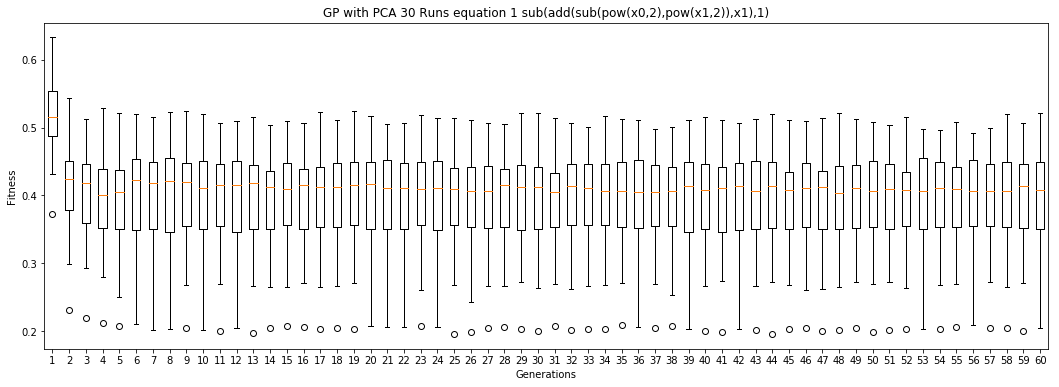

In [20]:
data = [[0.45794064423252584, 0.5021232750852646, 0.5563543780259, 0.3730583209211044, 0.5133467629748923, 0.4944313461970076, 0.504986105070227, 0.5802009012557402, 0.540551932707809, 0.473866824807982, 0.5686157656625537, 0.4646747306984132, 0.5186943775953717, 0.5483166335151233, 0.4322073492100505, 0.5119171225476336, 0.5964731341003119, 0.6007491493841699, 0.4931682452339451, 0.5785553983162074, 0.4440402913875815, 0.5619885382004106, 0.5262644831022868, 0.5488243687385345, 0.632892863965192, 0.5090154495584942, 0.43553966413240286, 0.4852087727571575, 0.5252977591622431, 0.5348383985272106], [0.37893692918293836, 0.47370022586284855, 0.38383636346869604, 0.23092293596675517, 0.43176426674757856, 0.4089723043886501, 0.46913033396672615, 0.44306688332957767, 0.449994053587634, 0.30653050649226293, 0.411653834712729, 0.29930979181666983, 0.3798760158794738, 0.5430671586467825, 0.31094203947483695, 0.43784169230625947, 0.4482067707511439, 0.45059936318406746, 0.36461673719987114, 0.4735216345176084, 0.3213424850828784, 0.44910746797981177, 0.4178502825402685, 0.49877673554590907, 0.5106082089675829, 0.4025730372268199, 0.3434587748268405, 0.44657956991387265, 0.40953752613440986, 0.5031159512045892], [0.37817371139549316, 0.45673635708670907, 0.3851389009509703, 0.21968683125521113, 0.3963689355817671, 0.416691872254525, 0.4638052814607009, 0.447744227977336, 0.42469466973305586, 0.2954518413185305, 0.41902673135390517, 0.2926336346008122, 0.3543497720964855, 0.5124327766186653, 0.302506779276473, 0.44184492898542777, 0.4500706922137995, 0.4334899655250641, 0.3428444791453243, 0.44222067372441703, 0.32098726658159493, 0.43493060349332463, 0.3973477968550488, 0.49193265585286977, 0.5124901626130396, 0.3763917239996786, 0.33241940023517536, 0.43216380282705424, 0.3893249748946798, 0.5029455729842977], [0.38028213399020167, 0.4679187004978921, 0.368566104974574, 0.21171312179941987, 0.38860515163043224, 0.3919889052682779, 0.47170134194468866, 0.4418413455845251, 0.4045105283331492, 0.27922170919268363, 0.4117536977552259, 0.291842643258976, 0.328391187027089, 0.511099668097145, 0.291618506747448, 0.43173008708307586, 0.44067083977534577, 0.42421252318140157, 0.34667556651830783, 0.42831043599383894, 0.3151256512193654, 0.4221225017838583, 0.39631135032319176, 0.4970544137198657, 0.5293528584204877, 0.37411588747310676, 0.32562193517430305, 0.4078253934622023, 0.37952656265341966, 0.48696254272654643], [0.3675312186046419, 0.45173083655763113, 0.3668944458350116, 0.20761908503796037, 0.4014815636477951, 0.3896429880596824, 0.47255544062626714, 0.4365927729074501, 0.4269539145238974, 0.25077821172782605, 0.40922262367135614, 0.2894661400108114, 0.34525908980828685, 0.5211204005911892, 0.29308208654526446, 0.4294866519156845, 0.4368908626366832, 0.4360707978802615, 0.34458577344748004, 0.42733718371392054, 0.31876262468114297, 0.43224384052453885, 0.40213076932960706, 0.48638112917172377, 0.5052556292786256, 0.3717263406886453, 0.3199874952694748, 0.4507706051654494, 0.3850383477908268, 0.4981775061515688], [0.3669262113467895, 0.46128989284270744, 0.3606245778222801, 0.20966516298990245, 0.4227480713304743, 0.38611438395596587, 0.456869982462906, 0.4455498831306358, 0.4246283846845721, 0.28624879536095493, 0.42263883355016685, 0.2924570411965356, 0.34182230307534855, 0.5196525229701151, 0.2973814469499599, 0.42793428092014585, 0.45888810067264685, 0.4458063896415795, 0.34799320492916264, 0.42719958469332825, 0.32088678375858176, 0.4352649038076494, 0.39520720091263767, 0.4947022724018133, 0.5062746288201934, 0.3499136435276509, 0.3265526439600623, 0.45866621216830455, 0.38106839206056947, 0.49832729345799537], [0.35647760357587505, 0.4441149966229836, 0.35843724902275126, 0.20086619713688034, 0.416556802770718, 0.38354805275976284, 0.4706891718006486, 0.4199691812361845, 0.42674731208077527, 0.2785978826859608, 0.4233088222948023, 0.2915111506641412, 0.3268020264770327, 0.5148986548726486, 0.29491646684002404, 0.4321242297505439, 0.45078693624722094, 0.44689988056072744, 0.3477761672198681, 0.42445934138048286, 0.32679677165728854, 0.45111934815693006, 0.4008535362401911, 0.4937065223314359, 0.4878504576039988, 0.3772958564232304, 0.3195734476869362, 0.4577459671875386, 0.40500588169516044, 0.4948572029943957], [0.36429674944117313, 0.45661495810750957, 0.36181915480774945, 0.20268372264540696, 0.42190216111450635, 0.38541691135036343, 0.46478992375318995, 0.4220837179281766, 0.419365610154997, 0.28452770774052694, 0.4254717274890495, 0.2726064010299797, 0.31700524753168435, 0.5195517732867146, 0.2864508821473835, 0.4202830758823318, 0.4589814895648986, 0.4510974535871235, 0.34110845458413813, 0.42283816803568886, 0.3179595555914953, 0.446482275546012, 0.3924620817938572, 0.47521675501505356, 0.5232437995581871, 0.37784148420249575, 0.3214656474361643, 0.4575640213283968, 0.42763689601890964, 0.4886285482915396], [0.36042988951460586, 0.45374281348499335, 0.3615046332753457, 0.2045288776934239, 0.41959059714912045, 0.37543711355840753, 0.46984504260987037, 0.4206910211576428, 0.4206306933682577, 0.28684361441694883, 0.4389074142950317, 0.2684530654940937, 0.32458192960840343, 0.5125012483369416, 0.2921786188256122, 0.4379263404183008, 0.4596942261280533, 0.4472669838770886, 0.3524566488912225, 0.4201663393262606, 0.3272111718046606, 0.4469425893045339, 0.39215318077370726, 0.4965296107752999, 0.5247164937681035, 0.3768513302886696, 0.32138035027550604, 0.44177208803099816, 0.4230205343107374, 0.4953810017834527], [0.36039735334058315, 0.4489367681949946, 0.35909567417470506, 0.20115401582725964, 0.40069152650684675, 0.3744699666684555, 0.46682367417982384, 0.42203332900502305, 0.40433622694187565, 0.2853045659487083, 0.43216329466081216, 0.26651633309407036, 0.32800739661874984, 0.5202949139532839, 0.28846018500216863, 0.4172873025597492, 0.45771996839476115, 0.45112620591755354, 0.3500394513219771, 0.42116310484378416, 0.32593726916072613, 0.4267286380927113, 0.3903931438398637, 0.4853714949960868, 0.5010758083893796, 0.3523378071387686, 0.3233548676156847, 0.4526133808061284, 0.4176341767298928, 0.4904604209402425], [0.36101621926307986, 0.44779123718674113, 0.36273777916818983, 0.19929898394302686, 0.415533227141212, 0.38127103505798854, 0.46420512934453706, 0.41879567219167313, 0.4220657992004239, 0.2841325259106523, 0.43404584785555084, 0.2687066095245138, 0.32950354715182933, 0.5074185921475659, 0.2860385199140529, 0.428586571533997, 0.46099249202699016, 0.4163882131417846, 0.3523478776159892, 0.42479825418258227, 0.32783340125822713, 0.4397525048706942, 0.39993830908455963, 0.4935982162989529, 0.49081026904160824, 0.36899909474648984, 0.3295989919894282, 0.44976830516325783, 0.41209898641016607, 0.4966256683084123], [0.3648060986714215, 0.4562956136157322, 0.3433478796913126, 0.2051551675805363, 0.41746794203070237, 0.37826871510474547, 0.4733070249464593, 0.41644260078152007, 0.4144925006843328, 0.28792357346358083, 0.43148828876601975, 0.26561283007992537, 0.32738774278436866, 0.5099382488056121, 0.28395281698808494, 0.4259822459527271, 0.46257293504256686, 0.43082552539179025, 0.3487993079089992, 0.42947797026795487, 0.3282392650046622, 0.43616689945461584, 0.39564343527877854, 0.49185240739033914, 0.49872451069862395, 0.3570539184007611, 0.34466797291044565, 0.4597100662470339, 0.4134700446359596, 0.4954654239747989], [0.3558134448469477, 0.44711887160543357, 0.3654461603356658, 0.19702809771443053, 0.4162759269582921, 0.3805235074962588, 0.4639197785252693, 0.419913370492014, 0.41878917799622795, 0.2818501180045587, 0.41928142699769105, 0.2658187616483064, 0.33453442360492597, 0.5149618675652641, 0.28487636194306704, 0.42931623033405053, 0.4702132188830923, 0.4357755955798513, 0.3484883715820261, 0.42647867333758105, 0.3272168797593847, 0.4370205530004504, 0.39341036258482837, 0.4919898297626087, 0.5004789544168388, 0.3613120829082503, 0.34672387903832264, 0.4554440400099614, 0.4087331354493503, 0.49107268580524166], [0.3538160766892009, 0.43604565985283805, 0.36282488791383144, 0.2039655348975682, 0.41775323302662803, 0.3678895952881052, 0.47302272632669645, 0.4274854060311849, 0.41268949999576787, 0.28485121625375637, 0.41014868570415847, 0.26502431980791263, 0.33757751469777264, 0.504011367654519, 0.28886600998226647, 0.4176079061335964, 0.46354210885218883, 0.4268947232928326, 0.3487165989237894, 0.42112000483014805, 0.31758349081540044, 0.43443189341574473, 0.39351579472687415, 0.4983254952527301, 0.4929370637958786, 0.3579722829342548, 0.3483881609674397, 0.449824189894867, 0.41279083946565925, 0.49329370028362757], [0.35773574484939386, 0.4580499325827823, 0.36300143105196014, 0.20699153826654795, 0.40963765295737425, 0.3740459677703681, 0.45442677940219306, 0.425876082727513, 0.4161176582921972, 0.28214624500406377, 0.4029895671553675, 0.2642714686459772, 0.33371424018882434, 0.5090057422165185, 0.28505347011334414, 0.42677034375191786, 0.46755738435615946, 0.4078336067573282, 0.3471443717921932, 0.4175046210507204, 0.32509456463490455, 0.436647176184402, 0.39948740684237016, 0.472870250637348, 0.49320110618324514, 0.3663125134980229, 0.3557154614474856, 0.4515663508453553, 0.412676235706529, 0.477781168228153], [0.35199260900278834, 0.44105869171137363, 0.3540417073932918, 0.2053774969571476, 0.41592227064627363, 0.38019513502432195, 0.4690495734950921, 0.42219596118123, 0.42246431883861935, 0.28574050569835296, 0.40174776799070455, 0.27048201536053995, 0.33024289951364877, 0.5060822685494828, 0.29461992823233407, 0.4164951232676657, 0.4755033536287034, 0.4136189006955694, 0.34715610120019375, 0.4201566275320524, 0.3199856883694736, 0.433354011538532, 0.3953557657627666, 0.4949867844409656, 0.4976400305570569, 0.37274515977020795, 0.35044197009190947, 0.44771933402020614, 0.41832600610402576, 0.4919171492565313], [0.3532749569848639, 0.45091263093551387, 0.36157827701469936, 0.20264914627220718, 0.4124283382943439, 0.37582760447122326, 0.47409063663912826, 0.42672061279987766, 0.42759882858419723, 0.2830448370040203, 0.4131010985106737, 0.2644886757224653, 0.324025939338411, 0.522658669926916, 0.29037749851192035, 0.42687633808494674, 0.4678176806438799, 0.41673150660355, 0.34524327244715886, 0.4167214249460929, 0.32406172085557117, 0.43664608714876785, 0.3945420189734121, 0.4827772488639313, 0.5092626059944381, 0.36986447170442377, 0.3545346799713745, 0.4427590151192074, 0.40950387772286867, 0.4949510428493678], [0.3556963474130898, 0.4524080086647959, 0.353289103600051, 0.2042596332186188, 0.4231885678003068, 0.3816074976906645, 0.47806930768078043, 0.42221498931644313, 0.4229697615083666, 0.2862507735251558, 0.4006190062459878, 0.26649876453785737, 0.332042616520877, 0.5118378161434874, 0.2902249307393978, 0.41442717775810206, 0.468108036829637, 0.41623962186826136, 0.3435628667306438, 0.42279752768391243, 0.3315076634663412, 0.43505592876508287, 0.39661044282205365, 0.4855478214634956, 0.4801537167375492, 0.3630421051617767, 0.3525041937752384, 0.4607449617196498, 0.40956450570436964, 0.48683061096764574], [0.35887422586548623, 0.4545577101055461, 0.3605551265800816, 0.2031997538260408, 0.4182078985496967, 0.37746483830931993, 0.46276572776877706, 0.420121363683646, 0.4000730324804942, 0.28427952478950497, 0.4136846588072813, 0.27039050103505125, 0.3261806066035408, 0.5251707898090159, 0.2935761589444796, 0.4213381820344787, 0.475397823473929, 0.4208215296986449, 0.3465079931705065, 0.4170098122069418, 0.3232242734998281, 0.43722247689400606, 0.3940110520591291, 0.4902793563838109, 0.48260161993510636, 0.36256435780525087, 0.3545165446725336, 0.4536035367551148, 0.4168696532150647, 0.4896278696577505], [0.3573554785176303, 0.46188559435334536, 0.35787173100080544, 0.20778683067363057, 0.4196059022130658, 0.3723612872778098, 0.47529097098297685, 0.421789163526774, 0.42054009118449054, 0.28520427059356523, 0.4134804660791869, 0.27317657220414054, 0.31912854494618187, 0.5173742455553524, 0.29357453326610616, 0.4206293550883372, 0.4718797324743002, 0.42214081153242494, 0.3484878636331063, 0.41926295119944795, 0.32886958120526183, 0.43893248614205366, 0.4012918020288074, 0.46505431645848855, 0.49650185526555196, 0.3504623403273903, 0.3528434017770124, 0.45183194953601447, 0.4059416301227908, 0.49665975885666014], [0.3593082934443462, 0.4600054036454366, 0.3533501149518018, 0.2055265069301047, 0.4170813395993413, 0.37316728067375265, 0.47761913028618763, 0.41260295132530667, 0.42553551389090744, 0.28452427736923686, 0.40997041893407066, 0.274403850977278, 0.30937158872497106, 0.5051912577297243, 0.28477036133463857, 0.3919869475289559, 0.4630111657659958, 0.4118349131059898, 0.34130991945846, 0.4215333887316834, 0.33084202238897975, 0.43561515097582104, 0.3933854593599887, 0.4747394517120557, 0.4883937503752956, 0.3624530904472999, 0.3490504797521921, 0.458253409869485, 0.41614348407713486, 0.4809824129287829], [0.3513172916608369, 0.4573363659181143, 0.3498306708741751, 0.2054950545980321, 0.4122949598846048, 0.37604254302780177, 0.4612194215430006, 0.4213928563579148, 0.413896153004391, 0.2912338056672233, 0.41128838711481075, 0.27138165595062297, 0.30724349518585775, 0.5063888003955499, 0.2935808293011617, 0.41832433360383486, 0.47220720699292246, 0.41123872783130166, 0.34762623764128997, 0.4164560449608846, 0.32503590829863793, 0.4345340796590862, 0.3958264698108217, 0.4738773948791189, 0.5012461582078919, 0.3633539734836045, 0.3578793179189034, 0.4524515164653446, 0.40959537135731067, 0.49288937306316477], [0.3559124155898823, 0.4576801422491943, 0.3604741421082635, 0.20778936168768886, 0.41285247569574374, 0.37598656695734817, 0.46622765504027003, 0.41802831113888317, 0.42238679467395956, 0.28821752721734417, 0.40554472986480516, 0.26099322557730853, 0.3150935846882326, 0.518147803163938, 0.28410878313851606, 0.3986847858517918, 0.47347160107278363, 0.4198803558175883, 0.3458429507855119, 0.4253942356250079, 0.32300663484558156, 0.4399088601293944, 0.3997599517665178, 0.4905895493164972, 0.5001301278771552, 0.3751733979692509, 0.35610954833768554, 0.45278150326473265, 0.4148364041558643, 0.47266195470488237], [0.35200910533728014, 0.46014874129989186, 0.34795844902809764, 0.2064869047897226, 0.4265941723418088, 0.3778878745931529, 0.4667290285241755, 0.42537318073546143, 0.4118226205029496, 0.282903234845218, 0.41399186159865664, 0.26965610665760775, 0.30830981820089004, 0.5139521420983391, 0.29006640030318176, 0.39692184182510454, 0.46873404868623303, 0.4112429576144561, 0.34641804628744616, 0.42845595199087116, 0.32685031768502393, 0.4335306846654512, 0.3946221944739947, 0.4889031048279243, 0.50294202893266, 0.36160288757737646, 0.36201023314557756, 0.4557284168172599, 0.4107799574142516, 0.49545964842629725], [0.35633616574065924, 0.45505402664886896, 0.3570982831284071, 0.19561571549450624, 0.41161134873330907, 0.3745870781812893, 0.45750768536156594, 0.4256532310992128, 0.4187253040036118, 0.2872052359771234, 0.40840511478162583, 0.2685770863560865, 0.31735185070840344, 0.5136478623410544, 0.2879238504646886, 0.4061776674113434, 0.46587919326573973, 0.42421230916802766, 0.3492158061335768, 0.42388364641177667, 0.33003057125249075, 0.4344789259853804, 0.39792923669169156, 0.49312649497086897, 0.502979662093022, 0.3684854536870174, 0.3561036102109783, 0.441612497414572, 0.4118422464100423, 0.4862711798326834], [0.3485880682281081, 0.4444650486422298, 0.3534118909615686, 0.19863408441302385, 0.41261983571835403, 0.3687349378756579, 0.4656882774765513, 0.4290670177135721, 0.42456553949138587, 0.28915099368530406, 0.4189016633366598, 0.24347254608895236, 0.3190870706908393, 0.5109611935273176, 0.28263499182839513, 0.40230285708558405, 0.4642111318846418, 0.41203164213488297, 0.35243771669701096, 0.4125945129154012, 0.33167251505510326, 0.4363080761730724, 0.39392066544559606, 0.47838674871173553, 0.4977864109133794, 0.3698360847908712, 0.3534866628481942, 0.4533411019561822, 0.4008393300778483, 0.4876707046345004], [0.3414449994363648, 0.4448663561254372, 0.3581771559901927, 0.20464538620772177, 0.42303759674721075, 0.37469409789823543, 0.46691428003853913, 0.426700276529218, 0.39888587899147143, 0.28345746761899565, 0.4136553382071078, 0.26641942095181753, 0.31448525901649294, 0.50674971623075, 0.29528734752153357, 0.3926984971358202, 0.4716969292218175, 0.4143124049461436, 0.3513586126313207, 0.4257186661467338, 0.32847290019666614, 0.4420170627653146, 0.38044271390663437, 0.4855188674942016, 0.5009152719073041, 0.3664004372838749, 0.3556964187647263, 0.4436736332356503, 0.41588760699195265, 0.4834779854499872], [0.35916432374625057, 0.4440478630329307, 0.3566781563784315, 0.20656582188725478, 0.4300522710611607, 0.37195263701500464, 0.4401087462037785, 0.42848181953555886, 0.4186700619274834, 0.28401531895888366, 0.4232809242727808, 0.26675367585614657, 0.31016078681838066, 0.5052006054660451, 0.29000797504032133, 0.4134117272366622, 0.46403861329789436, 0.4139830996980674, 0.35043190403754393, 0.42547915569907857, 0.3226609859910702, 0.4358082640674758, 0.39864990850472454, 0.48775682558692596, 0.5058678475984999, 0.36111756505251413, 0.35300085237051965, 0.4538498092629532, 0.41629232422222356, 0.49139641833375336], [0.35378109564421156, 0.453772332993371, 0.34491029112316407, 0.20231831524383848, 0.419998217107613, 0.3736235642742412, 0.4579061556251988, 0.4171403796775409, 0.412616796320543, 0.2831163580667016, 0.40605906239208567, 0.2724637716510878, 0.31216139288455325, 0.5209428985344766, 0.28849760697262805, 0.41212156590474863, 0.4637762745831079, 0.4162181045404124, 0.34786482033470095, 0.4168777202183932, 0.3287282897640981, 0.42071734859519117, 0.4017511440079551, 0.4782354203192191, 0.5031342860701171, 0.3662806932809629, 0.35466210433390655, 0.4537123492110716, 0.4183598088673757, 0.49270464369116856], [0.3555903395270007, 0.44347555073841866, 0.35082822849786005, 0.1993343508445838, 0.41417042176810415, 0.3843251385744715, 0.4556467403919701, 0.41997460199680947, 0.41628497101158884, 0.2895970432058639, 0.41233924901628083, 0.26307196099030505, 0.3147822488028633, 0.5209113512706942, 0.2883323979067296, 0.40367682820095135, 0.4669980893545218, 0.41903415123860766, 0.3440054354014788, 0.4163686773639696, 0.3253875330432173, 0.4353717107759514, 0.39856348659121027, 0.4892242772411912, 0.5013447805132532, 0.35860081712419645, 0.3496087908738802, 0.45005711390992365, 0.41352735009436375, 0.4920361479683856], [0.3569898597333726, 0.43304463965770845, 0.35318063464605065, 0.20673154349256784, 0.42464565729786025, 0.377743192056391, 0.47690640778229465, 0.4130188991366285, 0.4245119719999303, 0.28563513836548987, 0.4189319500335788, 0.26910757569993965, 0.3128929784262386, 0.5136520771450859, 0.2886698968509187, 0.4009400351513465, 0.46226624157594104, 0.4101730934975582, 0.3531513947373976, 0.4237412729664748, 0.3162028532269312, 0.4312194083956058, 0.3975221891152457, 0.49266665711479773, 0.49507134550333487, 0.3691295166191803, 0.35018551184864, 0.4592119342517037, 0.4003892710373108, 0.4777671655751049], [0.35574812716187454, 0.4564490359137748, 0.3573965587276795, 0.20196331900485961, 0.41623354279209884, 0.37537836482647147, 0.46589944400045374, 0.4310713116503899, 0.42537043952899556, 0.2859999164021037, 0.41455849613596896, 0.2618746490463643, 0.30847866546342506, 0.5062934386874178, 0.2905073704922844, 0.41200028150592655, 0.47754790851587003, 0.42286681931650694, 0.35359501635286456, 0.4202984953091715, 0.3301007812451636, 0.43349071903159453, 0.3928065552680949, 0.4920074547930679, 0.4961766133287721, 0.3717118600308949, 0.35740014258423786, 0.45090250330363724, 0.4130823624062639, 0.4892123389175719], [0.36456946204821666, 0.45578473994697105, 0.35635670321979745, 0.20355958195438936, 0.4104911445577868, 0.383115511957168, 0.47070950866260125, 0.4127300245381693, 0.41300348975785356, 0.2879807273199096, 0.41307050430792425, 0.26606263799402274, 0.3162340061890571, 0.5002702918366981, 0.2913473334804276, 0.4096574425269565, 0.4718300138960242, 0.4201281856570439, 0.33877843382631817, 0.4238146021753678, 0.3245424637034063, 0.4294372618740186, 0.40293435122788845, 0.4823715584397136, 0.4911545688336832, 0.3685417921751687, 0.3558651386230607, 0.4527004575759753, 0.41074274732484767, 0.4937749491223902], [0.35888490580088644, 0.449032490063124, 0.35555199336555127, 0.20229067787667104, 0.40819037235113065, 0.3830698401316918, 0.4626708033722855, 0.4233316126532324, 0.41781244208176943, 0.2831215176510665, 0.4067716712982665, 0.26845352208665, 0.31316001771992674, 0.5163933157232438, 0.29604568699473094, 0.40223134955289663, 0.46236757459402783, 0.4162879130400415, 0.34444530533918905, 0.42209269238148694, 0.3245072617976781, 0.4386320054618475, 0.3944645820853968, 0.48771417574452147, 0.4929414234693191, 0.37367934428485683, 0.35593606994653015, 0.4612599245870086, 0.4062050030655883, 0.4888239060290334], [0.35926783029421056, 0.4521788300598884, 0.35297840143431003, 0.20891200738987817, 0.41461575285504276, 0.37765040888254375, 0.4578905582740071, 0.41953886292648757, 0.42657461072035546, 0.2854247133475501, 0.4083691385139265, 0.27118921599899304, 0.3130079386705983, 0.513233338506742, 0.28174501058839574, 0.402939758668825, 0.4666225841427985, 0.41780432719645133, 0.3434989297363991, 0.41972925576116205, 0.3244489082372656, 0.43899195263091656, 0.40022489757392765, 0.48697332736004395, 0.4910109337630168, 0.35806488448106627, 0.35619946654071194, 0.4609136363310344, 0.4041202905633722, 0.48631805834732844], [0.3631906661718708, 0.459458839157368, 0.3531182900878762, 0.20535688201037686, 0.40901406037924865, 0.3798160858249136, 0.46720897083882784, 0.4294835639816032, 0.43289157952857527, 0.28681218106587153, 0.4154638848824665, 0.2723089363691053, 0.31565270860976996, 0.5110427113143557, 0.2882218381064804, 0.4005052254367174, 0.47137602954082714, 0.41810107768991883, 0.350210620072379, 0.41996177845291305, 0.31872648073803633, 0.42825618276338073, 0.39500914459908426, 0.49788001685839695, 0.48448652638395096, 0.3641230967753301, 0.3505184806117184, 0.4577212134976871, 0.39761354430700807, 0.49188380047971053], [0.35589845015483956, 0.4491504679986741, 0.3588266152307809, 0.20405748860291353, 0.41608401461668937, 0.37410426866839924, 0.47221020398917346, 0.4240970774956666, 0.42641185774482854, 0.28129345605769546, 0.40750260877764605, 0.26919000878535776, 0.31424614240865517, 0.4953354602682054, 0.29250243188967606, 0.40240954343518276, 0.47270410269955004, 0.41938989703514234, 0.35002376258174084, 0.4250333916791015, 0.3274282405881271, 0.4288986640265988, 0.3974668252887724, 0.4890521179315724, 0.49765496995829495, 0.368384014396579, 0.35360365540748895, 0.45376117141450184, 0.3938747461891871, 0.4873719145041046], [0.35812976735090246, 0.445488445825513, 0.3545375151671994, 0.2067812839444701, 0.4176225518770822, 0.3804035205921813, 0.47414587307477035, 0.41790635185934427, 0.41286285068781553, 0.28439129818982667, 0.41089846304564154, 0.25280698001781715, 0.3039398827134533, 0.49825988282398537, 0.2895496885728409, 0.40118613523681174, 0.46827420775484324, 0.41728273814763495, 0.35290068125949353, 0.42776614771963967, 0.32512623562505055, 0.4318787175578673, 0.39066794993288206, 0.4797372894162239, 0.5001177483057001, 0.36796837609270683, 0.3561351721242196, 0.45386948320940956, 0.3918896545515949, 0.4907086921072854], [0.34413013976791484, 0.4560229282426128, 0.35278807748893154, 0.20235339498799337, 0.4202748288187858, 0.37845468246784697, 0.45838478440314734, 0.4287010945063783, 0.41955968014341666, 0.2828043739494281, 0.4186017809360735, 0.2742936456403844, 0.31394085917695375, 0.5105404769175692, 0.2904108666731277, 0.41192789024731885, 0.4728478448735359, 0.41602173805426346, 0.33935164123447287, 0.4247411853938956, 0.31988134746001623, 0.42185590568716896, 0.4033840249171944, 0.47927610357609135, 0.5019639011439302, 0.36872077379157786, 0.35907270067440117, 0.45762784359607817, 0.38726221844312164, 0.48198065561342873], [0.3599832807710004, 0.4538263726843705, 0.35407168927389726, 0.20066809114640105, 0.4123490482384237, 0.3827180684057229, 0.47249986080121653, 0.419505358426876, 0.4227789840559156, 0.2844980125566717, 0.4126916503620095, 0.2657863196031292, 0.3168832017509631, 0.5159728744547188, 0.28952769384092397, 0.4032115317882467, 0.4716634895905458, 0.4250443154029116, 0.3475871509014539, 0.42045245529387865, 0.3259670387690171, 0.4350624769577956, 0.39772828534589827, 0.4768213357816041, 0.4976712849572515, 0.3710074762636588, 0.3482960297492922, 0.4508981641938824, 0.3811532670657447, 0.49108065761021064], [0.3484047076541409, 0.4572068703800557, 0.34616734630861434, 0.19897419954185125, 0.41534829384666055, 0.38046230586955887, 0.47284440213177836, 0.42660591044239193, 0.4137554143569209, 0.28303087560450496, 0.41450017296282615, 0.2739416516514577, 0.3181448531587544, 0.5113296999573171, 0.2855628593059954, 0.40831405198095677, 0.4693611342546478, 0.4215697602590442, 0.34081036077623716, 0.4260686090342426, 0.32059274111413266, 0.43264573441581977, 0.3997643093516628, 0.4887847763106041, 0.49749937809546707, 0.3673728474008546, 0.35695510899844285, 0.4446978024997524, 0.38268560149205827, 0.4881502123479475], [0.3548491782870156, 0.4520981361920215, 0.35428105243948643, 0.2032375379323158, 0.4171891210363324, 0.3741868812009645, 0.47278117011430437, 0.42454827828209757, 0.4262248879577189, 0.28804468645022, 0.4193867469955734, 0.2721827291723029, 0.30742261499445206, 0.5073970934976518, 0.2839328018718597, 0.4143212851784764, 0.4695569064753204, 0.4238937746336229, 0.34633400754147586, 0.4138130554563605, 0.3216876045193311, 0.4361097950334592, 0.3978555045916256, 0.47918137644983144, 0.4915885646793625, 0.3579989353723627, 0.3447599257667438, 0.45370415852888457, 0.3881536193000328, 0.4964792360922892], [0.35083560652066664, 0.4544395412638449, 0.3544860620186578, 0.20186550587101296, 0.41748102828767353, 0.3768546488731054, 0.46049868629087115, 0.4214542906717198, 0.4150669306866615, 0.2872248336072523, 0.40577612885221714, 0.26688764174346774, 0.31122461814558733, 0.513266325355137, 0.28136442420840996, 0.4082022491954486, 0.4703732675597629, 0.40581172495740064, 0.3499424936156147, 0.4173859907903323, 0.3256294151480079, 0.43765929923008756, 0.39563652393391285, 0.4917465434376481, 0.49428036348871157, 0.36306592238117896, 0.3512457281673094, 0.45977086652200316, 0.38274547781109575, 0.4896123634966154], [0.3538177035671222, 0.4572875258571034, 0.3512777962154172, 0.19587332858506906, 0.41570849515634595, 0.3775934756274246, 0.46491465738045396, 0.43293789412074085, 0.42192375780407965, 0.28655317963536514, 0.4132642647732061, 0.2728758913313256, 0.3154726681485857, 0.5203348995650727, 0.2937860382500358, 0.41428130523031476, 0.47442443830326037, 0.413565565764756, 0.3392645054899268, 0.42004821818687854, 0.3258713911868054, 0.4271280781759425, 0.38947041302472696, 0.48529930696201196, 0.4951699111530307, 0.36934781984976545, 0.3562097850079489, 0.45463991879962995, 0.380859280209044, 0.48510500259700895], [0.35626010133658864, 0.43173373245898067, 0.349990186105371, 0.2029850135067247, 0.4190783413734457, 0.3719153897728471, 0.4641329042857027, 0.4230375643052798, 0.4264032570543371, 0.2852823511588954, 0.41626104449965123, 0.2671183330804989, 0.3192795040367085, 0.5106330525481866, 0.29102968940562296, 0.40302425110101264, 0.47260012315836564, 0.41686931498100044, 0.3539936472002947, 0.414133793946517, 0.3181882410882058, 0.4362179765166655, 0.39854600197194223, 0.49796658722452625, 0.4929427712456069, 0.3654981148393971, 0.34969368303811166, 0.4517671046214983, 0.3861403519087361, 0.49868982324872146], [0.3609336636015036, 0.45359436517546387, 0.3512264339798517, 0.20394486319427507, 0.41881695961358784, 0.38003091949049156, 0.4654412810052451, 0.41873210671372796, 0.42270384282476503, 0.2870379091528999, 0.41650530172774425, 0.2609063645778231, 0.30711971909832175, 0.5098518361217996, 0.29050281563359315, 0.40588917859902185, 0.46328967185589814, 0.4144313391386738, 0.3483111861096695, 0.41988418081971896, 0.32913511294891623, 0.4325919493873844, 0.39029716709178897, 0.48792184924964094, 0.49549483987246784, 0.3653194089435039, 0.3571805427878078, 0.45431320409967857, 0.38466194579278645, 0.49418721470210014], [0.3524007949198154, 0.43771230702814357, 0.3488530652590335, 0.20002135096666718, 0.4170254650212958, 0.37905523055310114, 0.47205558832747313, 0.4290007418456743, 0.42367768634463626, 0.28172472890397454, 0.4075743324058776, 0.2622951348651377, 0.31373594967799895, 0.5144059926295486, 0.2894613695773481, 0.41961504143581874, 0.4717485612078845, 0.4197576786974918, 0.348739962999113, 0.4301839280629412, 0.3275024185559875, 0.4322680519574576, 0.3934460358685152, 0.48770801658580043, 0.48358609573604405, 0.36593201012931414, 0.35715608485578215, 0.45543346683714486, 0.3812557540808367, 0.4819985412872239], [0.35930914138317244, 0.44652035676972335, 0.3503385108346785, 0.2009933053762119, 0.4079780183073154, 0.3694521238586559, 0.4756966390775339, 0.39790583445785127, 0.42356861533186174, 0.27989630338068944, 0.4135548094052333, 0.26534623496349735, 0.3095284077579472, 0.5214079008061452, 0.29062660759821735, 0.41325511751835464, 0.4739252494484759, 0.4102295889797097, 0.3473289128742941, 0.42059266575328663, 0.32504150515874897, 0.4357840165615632, 0.3859949218861151, 0.4874098053660667, 0.4872645009578992, 0.3685255333289026, 0.35075738421544866, 0.4605169348770919, 0.3797355741307684, 0.4923917126007782], [0.3565706898193684, 0.44950555348115545, 0.3498979812766397, 0.20408790082396816, 0.4226564877224778, 0.3819940343978526, 0.4654470942279141, 0.4132818419113945, 0.4143116719740026, 0.2896520385287605, 0.41653335530704505, 0.27171701175410745, 0.31223256153045154, 0.5130121307754723, 0.2929287538307682, 0.4071888542036416, 0.47210606606642225, 0.4176660184598412, 0.3448815427022063, 0.4176471912009799, 0.3274728061288843, 0.42926529978194367, 0.39993991215069236, 0.4956373518469012, 0.49427836600085906, 0.36557069620179133, 0.359690342911271, 0.45529130743898466, 0.3769175745952843, 0.4945568647401358], [0.3588148575465464, 0.45620458502830924, 0.3535226640224291, 0.19866387218444778, 0.4189355340023257, 0.37918266407052165, 0.47158867250629266, 0.4318908880770308, 0.4280108252503465, 0.28209680795438324, 0.4101554323572316, 0.26982063011791235, 0.31062752291474927, 0.5086278118257511, 0.2897494116624734, 0.41415805649770826, 0.4718602398632341, 0.4033606970774501, 0.3392369488700482, 0.4222394626994415, 0.3315395659489078, 0.4360681011846403, 0.38721783832370693, 0.477519375654408, 0.48650761494857103, 0.3613972537259562, 0.3552900930158336, 0.45634336238549006, 0.37982754923520573, 0.4882474459078636], [0.34982504216566107, 0.4531191542653526, 0.3553632469728069, 0.20149999201918856, 0.4210924259905272, 0.3599423707347768, 0.45427043601141504, 0.41006740825269467, 0.4258562148677259, 0.27993225643242103, 0.4118239842331046, 0.2728282647829696, 0.3208158919664104, 0.5043063225434613, 0.29048650401877624, 0.40916026517487436, 0.47137384322265924, 0.41595045223116955, 0.3419605042244549, 0.4158451776338089, 0.3301507783616919, 0.4312721780294591, 0.39434248984341297, 0.4878019080848831, 0.49162485101882153, 0.3580133220366981, 0.35015764793357423, 0.4520282329125895, 0.3750607577978288, 0.48821421236530643], [0.3578352709178663, 0.4372399977622102, 0.35597244971562153, 0.20355167740087213, 0.41500722569899107, 0.37608957559371653, 0.46014625971675227, 0.4157994352000721, 0.4282199724657428, 0.282487569696766, 0.41423545937023337, 0.26331073982341957, 0.3114985728083049, 0.5162411339579793, 0.29004587798327996, 0.401526754205845, 0.4746008212533827, 0.4204922693422009, 0.3565771867107667, 0.4277190019982079, 0.3052239030528672, 0.4232850954807294, 0.394320163569843, 0.47751015454572354, 0.497026086230741, 0.3520647059767119, 0.35359756137284615, 0.4631528891084571, 0.3725357815126075, 0.49471768577245706], [0.3465752426546717, 0.46035841181129333, 0.35051714811988116, 0.20264906929251292, 0.4180234961225948, 0.3679513860060267, 0.46351333546068546, 0.41654485125664054, 0.42423565791207335, 0.28478773647921857, 0.41420932082133666, 0.26877911875673555, 0.31170331828619974, 0.4985458653141752, 0.2877213596651697, 0.3986291086739868, 0.4665585444808087, 0.41936467248995046, 0.35172633910788115, 0.4232773062900237, 0.32554283143072316, 0.44226426014953363, 0.3989762039462683, 0.49449190944226556, 0.4918192972555478, 0.3503521606592917, 0.3517813003148506, 0.4587335378018071, 0.37128624171190683, 0.4764814523326486], [0.3556722739083932, 0.45284171716865945, 0.35255619309534764, 0.20296720912055932, 0.42050052449636, 0.37347465376059014, 0.47151513468624723, 0.41534722012505904, 0.42211637042465644, 0.2870866029184924, 0.41113627623611537, 0.26718137162597017, 0.32099694299624987, 0.4961110783840638, 0.28652069117028417, 0.409280960398079, 0.474164873847192, 0.41116299280766283, 0.3539300210014059, 0.41832274333610253, 0.3245672747742096, 0.4372568398455234, 0.39702624455891844, 0.4858035581860098, 0.4926999835092926, 0.36103624590394395, 0.35085881523349916, 0.4576662464727427, 0.37461315395192635, 0.47841004665747355], [0.3597967173681789, 0.44405654359522956, 0.35297543447423474, 0.2053418731151405, 0.4126095446307383, 0.38273733785022196, 0.45153358826256385, 0.41704172411273244, 0.4214530658198863, 0.28475571130963473, 0.4186043164891739, 0.2688785716691865, 0.31706039896819466, 0.5078772874109828, 0.2897610888600689, 0.41142102813628234, 0.47378232469273657, 0.42054781379008793, 0.35557744987052947, 0.40824591370582075, 0.3288752323238359, 0.4365618109822499, 0.3994036487546095, 0.5008228405030756, 0.49368621854765027, 0.3644111727677658, 0.3525411087959981, 0.4499187576249471, 0.3765973988591945, 0.4929162185781651], [0.35358254751938273, 0.45663171548767767, 0.3573305752861983, 0.20945613504603103, 0.41655894162287554, 0.36887054437108524, 0.4623873200437825, 0.41525384165898305, 0.41448756931302194, 0.2860924568723582, 0.40902787865861084, 0.2712725410573284, 0.30288460937265543, 0.4913646824790369, 0.28932001937225876, 0.4051312642555096, 0.46947051773170434, 0.4149445937969696, 0.3563224678239487, 0.42909673699874, 0.31797611587476193, 0.4379805281661276, 0.4004461145904488, 0.4837729579128825, 0.48775039968351497, 0.35720038845958774, 0.3541642875364424, 0.45883866395203454, 0.3697749568069848, 0.48529879695930306], [0.353968262603223, 0.4505689972911599, 0.35422225271272034, 0.20505018284355817, 0.4191103811079109, 0.3718306878306674, 0.467824527521889, 0.41124534902586346, 0.42143904187010556, 0.2839255101235547, 0.41742975415580297, 0.27188860014175087, 0.31177499108484025, 0.49930847422065594, 0.28793611434505273, 0.3963813364656791, 0.46879825237440864, 0.41538994784008626, 0.3580134632890056, 0.41840162803318964, 0.3240074422873323, 0.43908881328918925, 0.4020601796346056, 0.4780464087956895, 0.4906007094742039, 0.36752633128952994, 0.35487558224402066, 0.44810148154721785, 0.37407357468827335, 0.48621185243017534], [0.3604416406906514, 0.4547880622265434, 0.35291264225404956, 0.20433428367572867, 0.4174724660743032, 0.3750871672518443, 0.45958286024325584, 0.433302588160774, 0.4313421514542564, 0.27743180119769667, 0.40597133865652996, 0.2653316914658956, 0.31323761742075823, 0.5204110661364828, 0.29272367437153074, 0.4064443765289877, 0.470325439886807, 0.4169705173365354, 0.3559305175942138, 0.4196521473927955, 0.3258919378547953, 0.4237190581726215, 0.39901284010988863, 0.48946415330025983, 0.48056056118227447, 0.3635699476896449, 0.35059376787046365, 0.4538593790348893, 0.37479634122908423, 0.47801061033992565], [0.35401037875037517, 0.4497506140323258, 0.34569315202789785, 0.19935396625911042, 0.41270433574029974, 0.37137399308583885, 0.4570942550777541, 0.42689078925114143, 0.4314081511948249, 0.2855580585060943, 0.4181936350518015, 0.27074524129858335, 0.30504170813811243, 0.507194856811052, 0.2891234371394624, 0.4141119575893551, 0.4724752327164557, 0.4159791425873646, 0.3510991231110259, 0.4222477510081746, 0.3289742997971069, 0.43572026606940667, 0.3920921587014096, 0.49214195260145027, 0.4924018057651254, 0.36353580087130233, 0.35737895845050494, 0.4599451121600282, 0.3784313757563505, 0.48922646890206917], [0.34968455698454826, 0.4555379734418712, 0.3490363733528933, 0.20507925035143962, 0.4181491181643818, 0.3689829468321777, 0.4632692808778199, 0.417299239208061, 0.4312139353143378, 0.28275655665935445, 0.4057837395964745, 0.27016818908654344, 0.3035675655364226, 0.5208294227219105, 0.2905188026378617, 0.41014074277263135, 0.4701907893780532, 0.4252998715562686, 0.35380445410724554, 0.42197730201265005, 0.33165902059770686, 0.43678352985267604, 0.39843486033044373, 0.4951488605152825, 0.505251740429692, 0.3704547096774182, 0.3537001972802159, 0.4524714193392763, 0.3763043412147581, 0.4913325433985944]]
fig7, ax7 = plt.subplots(figsize=(18, 6))
ax7.set_title('GP with PCA 30 Runs equation 1 sub(add(sub(pow(x0,2),pow(x1,2)),x1),1)')
plt.ylabel('Fitness')
plt.xlabel('Generations')
ax7.boxplot(data)
plt.show()

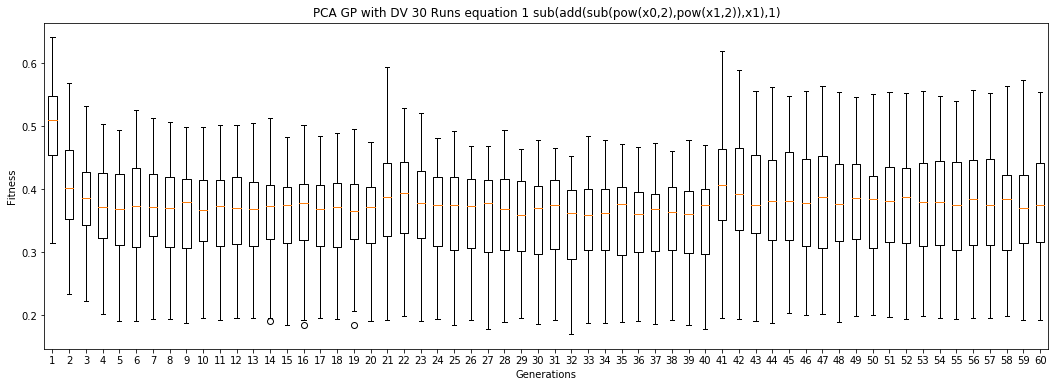

In [22]:
data = [[0.5226602104681045, 0.43899525382949434, 0.6085208741370971, 0.3144676376671677, 0.5735595064060176, 0.48906676170438845, 0.5416975235167134, 0.5705647245636445, 0.4990089467486162, 0.5078391650601688, 0.6408966696279249, 0.459730861316767, 0.5694383657913098, 0.5363074079119436, 0.3637727451016186, 0.49096584480357425, 0.550134976989026, 0.5442341941742121, 0.5785444151280118, 0.41660594969588344, 0.41018794862860014, 0.5215738100254258, 0.49367197022009357, 0.4526369240257105, 0.5576229914043355, 0.49776140100196986, 0.4513418340136478, 0.451327620607232, 0.5199745518402089, 0.5130289780972487], [0.40371018765547817, 0.3534870615323896, 0.391832685695824, 0.25517780932325934, 0.488177761422133, 0.4185000790526432, 0.5136049714948222, 0.3985740271866883, 0.35201927556284596, 0.3345611683583226, 0.567890613968674, 0.3248011975682464, 0.3974213934521999, 0.469455932282623, 0.23390665893036122, 0.4668522667454599, 0.4763456754237541, 0.4071317532670348, 0.3345990479696237, 0.3482334113502313, 0.3632673257543819, 0.41045253634939516, 0.3816426457979237, 0.41968979854510874, 0.5043268084992343, 0.450470687897914, 0.3110073422915165, 0.4234453019537676, 0.3849962305840282, 0.5147354997361808], [0.38387045665789415, 0.38229888236330684, 0.36750974035148914, 0.22283552066988804, 0.4887907548233378, 0.39540174972065456, 0.4030626731542461, 0.43777544997311235, 0.32659968550738133, 0.2947041075505137, 0.5327635822304149, 0.24236016720931827, 0.35101466094098743, 0.4521382240562257, 0.2236232223588296, 0.42241687974105196, 0.4923016685768411, 0.4074156707606979, 0.3666709850289906, 0.34390459501115633, 0.3182229361124104, 0.3919952912510978, 0.38801421109412204, 0.39865430957561476, 0.4428656951999153, 0.4298025285774344, 0.288664678944978, 0.35098924534078146, 0.34332744457290365, 0.4856590921070205], [0.33174376492399565, 0.36422841710644127, 0.3698701626127424, 0.20957930256915047, 0.45670345360252046, 0.38006499797486337, 0.42010832121729424, 0.38853818637509385, 0.32245272670970415, 0.2809248518761224, 0.5033970756564478, 0.276507543565899, 0.3662388905175382, 0.46280501018824144, 0.2023967861899822, 0.4323376201490161, 0.4891707150884373, 0.4037845271364277, 0.33723235835439674, 0.3614914984850258, 0.3211175250202776, 0.37347565012396433, 0.37683315633010456, 0.3892901078709609, 0.45246539805241415, 0.4278163251938813, 0.2774349235315191, 0.29612428073811853, 0.32280467670599455, 0.49654595286895237], [0.36454508913297823, 0.34847946925050965, 0.3736082308451502, 0.21166793393299313, 0.4613132459643017, 0.4036019770865257, 0.4417353357183281, 0.3964831017753199, 0.29257423665227955, 0.2756256889845161, 0.4940815923638099, 0.26783056959774315, 0.3573322597611355, 0.46510065418597396, 0.1904684304040452, 0.42784280610491243, 0.4897527516032234, 0.38304598473259116, 0.3320694434792184, 0.3552115212931191, 0.32369074860196195, 0.3603209384482599, 0.38205946099696403, 0.40890159564262857, 0.4649282465444049, 0.41481295528820694, 0.28749184737697253, 0.28510816391350285, 0.3065611257987041, 0.45597389295952784], [0.36391414122224686, 0.354044642493536, 0.3867141462517677, 0.2126305573820364, 0.4455047961441665, 0.38693448447273837, 0.4399068019058539, 0.39733755880448113, 0.28557937452316934, 0.27460100402256044, 0.5264795210764878, 0.2616218021722234, 0.345239363516473, 0.4553512157747024, 0.19116264428167637, 0.4217371107616917, 0.4885027417777336, 0.39563097609377834, 0.3301036461499345, 0.3632297644971307, 0.3414383309604807, 0.356286466440056, 0.3821263460470951, 0.40257487551402493, 0.47072145985333336, 0.4372926074234198, 0.26183658086244976, 0.29846682795186674, 0.30148166569123624, 0.4627458531746883], [0.33913845243411234, 0.3491232960219286, 0.3826227875526963, 0.21046727476523197, 0.4312151024820512, 0.3757838098598823, 0.4248886820469415, 0.4206142256508607, 0.28716407500435237, 0.27055320463249044, 0.5125370884214401, 0.2532782536281619, 0.3441055380630515, 0.44753117460344644, 0.1939179444117647, 0.42537382366936005, 0.4783314046422224, 0.3937000173724541, 0.3320694434792184, 0.3674492892803478, 0.3518435718776747, 0.3660799813093569, 0.38275084225698514, 0.39931233262949717, 0.4359901531187946, 0.41888194738870776, 0.2674833229010392, 0.3049719205416269, 0.3229218096409474, 0.45718313301777463], [0.3461359284671352, 0.3559566354521062, 0.3724353251866323, 0.20592932509045597, 0.4219899475852318, 0.38223918334186263, 0.43619918308584116, 0.43121859064602797, 0.29832337483888577, 0.269712273173402, 0.5061422617223834, 0.25895317829904185, 0.35572988076496753, 0.4610190661591493, 0.19377426011868668, 0.41277906516934176, 0.4633284306383081, 0.379048741099676, 0.32149054320150366, 0.3683198225397507, 0.34288663216359944, 0.365795020477399, 0.39310880202971027, 0.40432351830981367, 0.46443346429121274, 0.4096283267165025, 0.27013264514853813, 0.3045802794166872, 0.30284391555582757, 0.4593104462174373], [0.3414264560556245, 0.36667384794027436, 0.38137976446465643, 0.20192306946546135, 0.446558476333495, 0.38139551450266834, 0.4370466258113544, 0.40014733523192686, 0.28256835938770103, 0.2805445042862631, 0.49863965812948724, 0.2487049983024011, 0.33686838947476194, 0.46328683902812745, 0.18831643107511953, 0.4060105018939575, 0.4733491714522382, 0.3950413814912774, 0.33024347180565194, 0.37876216447526506, 0.33386550524616926, 0.3542406928560444, 0.38642666340955406, 0.3935832920689708, 0.4748671210226995, 0.4192500458452206, 0.26559747357749713, 0.2820294258879733, 0.2982164669890708, 0.46054670590483265], [0.32416379555168245, 0.35318177575712495, 0.37594464080879014, 0.19626000187894121, 0.440030499361646, 0.3697020381149872, 0.4462266052857382, 0.41568109565294864, 0.29725919958309777, 0.2728709490864665, 0.4982124229744371, 0.25861009327542855, 0.3508080118506034, 0.430141102381427, 0.1949916233318165, 0.41420584774229474, 0.47187585757593276, 0.3930998071138038, 0.3236822364868172, 0.35135804417756117, 0.3427551623411887, 0.36414989201360404, 0.39752948705299984, 0.38733698283916707, 0.4711332300374691, 0.409434628111489, 0.2602698541062282, 0.3082197508434707, 0.31552993741651103, 0.47150133304876274], [0.3352929090069936, 0.37184320730112924, 0.37590040606427344, 0.1929194145113945, 0.4219899475852318, 0.3666446769318531, 0.43504257851041905, 0.3888164944512792, 0.2964999261787449, 0.2792802725689756, 0.5014135286407216, 0.24450652780201276, 0.3475328978174221, 0.46932717765440224, 0.20358278476031838, 0.42216769828683887, 0.45018163872305667, 0.3942970352967921, 0.3296431212392003, 0.37773934722114505, 0.34865147437474, 0.34382772145948437, 0.3802888682237915, 0.38891433971979517, 0.4701059836406589, 0.3930701786422518, 0.2586855890535857, 0.2973288728431518, 0.3031206621104081, 0.4823697915874138], [0.34301249318818716, 0.36890144879864983, 0.380644734820857, 0.1951741681368021, 0.4358425997507247, 0.37784315353511916, 0.4539312553077607, 0.3882006593578281, 0.2842734417678555, 0.2661378211202851, 0.5012445893666212, 0.25642047208806296, 0.3308508804326352, 0.444719572567813, 0.19662110996121804, 0.42249855500753397, 0.4770730398692766, 0.3786558704716206, 0.3370143008756339, 0.36613211437814736, 0.3386568759699969, 0.35859825357483904, 0.38330032615524107, 0.37289791523566496, 0.4722972585112413, 0.40703020742499607, 0.26908072232479924, 0.2933263613385133, 0.3069446659088928, 0.45943387063609975], [0.3445268094946841, 0.34436484986225374, 0.37360132511065824, 0.2030164875579925, 0.44167619507859596, 0.36456172995104785, 0.45213579357671246, 0.3870007468620835, 0.2969665457091028, 0.27297357171215997, 0.5048071446901301, 0.25954085797096405, 0.3475974959999587, 0.4609073085728096, 0.19582754542371383, 0.40804847193646526, 0.4676511123401153, 0.38938619810651154, 0.3290064155493597, 0.3409241677043667, 0.3484332368652383, 0.3726770322035848, 0.3733827966204111, 0.39766125859649837, 0.48425982904870135, 0.4119694996678018, 0.25106110030010304, 0.29997484185355305, 0.3039208688365193, 0.46733393219729386], [0.33221133218871396, 0.34868518299264517, 0.3736376300139084, 0.19497510725489337, 0.4187832510075046, 0.38124397880897054, 0.4317266488028657, 0.3875112699902776, 0.2954871505935517, 0.27700840436023494, 0.5137904750138504, 0.24170421873061013, 0.34744601872203695, 0.4595746130598079, 0.1903838385461744, 0.40893728448926925, 0.4673739716610961, 0.3967264835568732, 0.33959416051093755, 0.3732399233208729, 0.3350762689931573, 0.35285713116054257, 0.3864544160544034, 0.3817703697700127, 0.46853960974668685, 0.40062759539402304, 0.26331778747597956, 0.2896565683414133, 0.3179553855724009, 0.4672382487264071], [0.34823775825643477, 0.35689238810090307, 0.3763593498007382, 0.1927214567226518, 0.445234875532426, 0.3738220067202537, 0.39219662714363335, 0.3823782538250092, 0.2982013518787382, 0.2860235268782798, 0.475235266963064, 0.2531103577484293, 0.3469177937891128, 0.4471201157494142, 0.18452827048685969, 0.4260576150999182, 0.4831311858195712, 0.4016085838637463, 0.32848981505806485, 0.3818000964559939, 0.3535216571259231, 0.3610526134297922, 0.37883943076583826, 0.3869644757203397, 0.4568621249717931, 0.4045731309486946, 0.26463078030136505, 0.2957065587405109, 0.31041918002043206, 0.4657910214098994], [0.3269601098102225, 0.34868518299264517, 0.38153266525954316, 0.18498076698869814, 0.4201756964610437, 0.38035242803656927, 0.3975913890994453, 0.3877629297850169, 0.2816018886416324, 0.2785678433652624, 0.5013421027862088, 0.2430578125203324, 0.33994880376045367, 0.45994301628864004, 0.19264983552584108, 0.40911266008943364, 0.4818213741400088, 0.394778574880861, 0.3305203683074642, 0.3767532338379016, 0.3455694578255159, 0.36244325673397415, 0.39968109795194445, 0.4052088380030115, 0.47135035589302515, 0.41425638590640257, 0.2646281330647182, 0.30366683104109576, 0.3173897840411877, 0.47171012652021854], [0.3445401717764907, 0.3513494103195345, 0.37393345723393323, 0.19680587262948512, 0.4305818221341219, 0.3650058413998481, 0.4075385220793859, 0.3722569900852632, 0.28885106049693837, 0.2692802575774137, 0.4836675716255048, 0.2427477151830763, 0.34511472034731455, 0.44507956779326086, 0.19512998357800054, 0.4303630441351762, 0.4451398529082133, 0.394996165574236, 0.33149436611151173, 0.38036735301019275, 0.3258136872178854, 0.35198502738553583, 0.401149660031604, 0.4019549956435443, 0.4658211897984039, 0.3951822555522459, 0.26588919137277944, 0.2928746475946427, 0.3037518488723008, 0.4574537050174189], [0.34411283816581545, 0.35396623244265896, 0.37248141659592815, 0.19890511870949373, 0.40980107823096235, 0.3733063797150435, 0.407956823296491, 0.39311973439296444, 0.30371043628033134, 0.2747115163637536, 0.48878715160735076, 0.23552767278349465, 0.3359003810847932, 0.4377638442011187, 0.1937722080494968, 0.41490361841058393, 0.4787515950770172, 0.39111640088422334, 0.32489465875970197, 0.3721116432263301, 0.35507526645682885, 0.3542903475820075, 0.3858487234194754, 0.38669215975006066, 0.4698853890991447, 0.42127231717327285, 0.2548228832815053, 0.28732185454033554, 0.2933857474743744, 0.4607994327878632], [0.3309731774461049, 0.3625802488986454, 0.3695491950198771, 0.20650768811697098, 0.40866294410257686, 0.36813421116570155, 0.40820194671511545, 0.3825283666303852, 0.3080562243792244, 0.267530680165264, 0.4955950071482664, 0.25813962828027404, 0.35169182166609636, 0.45129691960375723, 0.1842744067948627, 0.42218680790834495, 0.46892328553029256, 0.38838568166680937, 0.3387132655371933, 0.3631125544807552, 0.3357584420037958, 0.34986499157107837, 0.3912880055863457, 0.38600850482089555, 0.482188240959715, 0.4078995449677707, 0.26458600414444955, 0.29699218423639706, 0.31655899765797585, 0.47699851585835495], [0.34212543934979256, 0.36026954907774156, 0.381814883424636, 0.20424625541403305, 0.4365296878040905, 0.3718891823060005, 0.3716823078902204, 0.3906366961067578, 0.3049720276946086, 0.2700070263339047, 0.47457691734434465, 0.26295050552450966, 0.35058673653328704, 0.4465823872989049, 0.19065898677746268, 0.407217940871982, 0.4367771189892395, 0.38782656892195894, 0.3353655550765545, 0.3852712823905551, 0.3537493164561958, 0.36062281699311743, 0.39466006142357224, 0.3877088386561429, 0.4752707762714926, 0.418142928660511, 0.26152711513780225, 0.3007695168168188, 0.3086019554457877, 0.46871393202184763], [0.3267866271029777, 0.37038345027036484, 0.3085839082678322, 0.1926316293394651, 0.41207006972632704, 0.35600955417654845, 0.46008321658644846, 0.4280578540625243, 0.4348360575884748, 0.2625780415315299, 0.3870576425203913, 0.23772934881061586, 0.3257948814074745, 0.4529059561723831, 0.3212659690982882, 0.3881940029289682, 0.3737371180879299, 0.4413532402213725, 0.24089779230589137, 0.4876962724710737, 0.4717832992841162, 0.4422633102465072, 0.3351137904962048, 0.4760727243103042, 0.5936903179465729, 0.24544059197717294, 0.3673735429612711, 0.46509725197553425, 0.38795875324887813, 0.4126228518167333], [0.3341710163619804, 0.4049751586429227, 0.2979784583511636, 0.19841265845546047, 0.40280258434165445, 0.3572197369449321, 0.44259076499437483, 0.4401999952639338, 0.4105106875975537, 0.27005912665228543, 0.37430057803607863, 0.23842188225436456, 0.3086519284193843, 0.45004614912180746, 0.3295814831996573, 0.3957775675522532, 0.37354811313448455, 0.4441454187985574, 0.24598043190960972, 0.49471616885244085, 0.45450616586865095, 0.4456071176233494, 0.35538618339188527, 0.48659216887415074, 0.5281703436089923, 0.24979060393717745, 0.35162840852352467, 0.4500472808251531, 0.3916495131966395, 0.39564160733726184], [0.3219719956373253, 0.40274465864363, 0.3074392125876994, 0.19060847644421466, 0.41961781868366893, 0.3428205107329062, 0.45673123682378997, 0.4294059898976057, 0.42652605830108875, 0.27318977472101214, 0.35532055476505076, 0.24869220123647157, 0.29292223839373055, 0.44091726756009075, 0.3353350847173545, 0.392827857649819, 0.364761827449411, 0.4317875604451442, 0.24579381007019835, 0.46866976275502, 0.39657786314677534, 0.44923089693756285, 0.3488027483252404, 0.4455154407086337, 0.5212755944690062, 0.2540092947202542, 0.32287177748964246, 0.4099705127023452, 0.3992177806304597, 0.35723763097715466], [0.3360238074178759, 0.3858612120415971, 0.3030336910635242, 0.19363716774951176, 0.40618112292458974, 0.32912229426936374, 0.4443795541192686, 0.4068679988758031, 0.4200192166795243, 0.2647369998333969, 0.3467944696746278, 0.24717018572512814, 0.2694336492034445, 0.4474628010899957, 0.3629308937380508, 0.3872696823055725, 0.3617966182575775, 0.4156695367471253, 0.2526963297371258, 0.4523394420997449, 0.3602635138021318, 0.47197259844708017, 0.3529836456376445, 0.46434152576393384, 0.48197103028673577, 0.25807012934719264, 0.28266408977064006, 0.4305289175686091, 0.3941893384245189, 0.3873312501595859], [0.32890460293792345, 0.40889861691423507, 0.2978436789373134, 0.18430202961424547, 0.4154536261858868, 0.3230925241231648, 0.4424537406522833, 0.42123738161872537, 0.4349680883480669, 0.26987534098064003, 0.3478600257021363, 0.25118970290048365, 0.2783842625307848, 0.4399501500946756, 0.35818944138893605, 0.38051496469536583, 0.3740270075987573, 0.41418936380990173, 0.23844653871765045, 0.4511299806616979, 0.34815350811312656, 0.42845975560185734, 0.33812747558930184, 0.4830940732164686, 0.49212712729237673, 0.256758982376103, 0.2963996413729494, 0.38755920353537376, 0.37697509649338135, 0.38017522841189966], [0.325343980224737, 0.3792653750440581, 0.2972645354150402, 0.1920002810374627, 0.38122289384604496, 0.3245764306176754, 0.43285458322131154, 0.4178523970754893, 0.4254129153547111, 0.26747303874331796, 0.3435074594585202, 0.2572521067075797, 0.27644009411193776, 0.45677834993189464, 0.3530529679479948, 0.3929010064333834, 0.36777167817041634, 0.41202567043188265, 0.23948473288806715, 0.44968699138386486, 0.3465433173635507, 0.45581768782514687, 0.35808178955265024, 0.46849162860602067, 0.4616730275861769, 0.2611338088107716, 0.300674031985272, 0.4099705127023452, 0.385596712156851, 0.3885988473064973], [0.32391126236464934, 0.3869867215228912, 0.2951381692313423, 0.1774958982738585, 0.4032264457677248, 0.3127385017302379, 0.4201144583837221, 0.4153233038360082, 0.4388734186524743, 0.2549528453559039, 0.3515543306595508, 0.2522516721690856, 0.265950270571886, 0.45690986959916, 0.360460276000985, 0.3910935872894426, 0.38064217731985495, 0.4052023163042621, 0.23794677427636313, 0.4106203753821961, 0.3282866460513689, 0.4451410653165492, 0.3491707328842036, 0.4682617291779846, 0.4362032169583969, 0.2518838443464206, 0.28723310651158573, 0.4192625733743949, 0.39583599039623457, 0.3768717411439169], [0.33102674647804403, 0.36735809662657154, 0.29125037538904597, 0.18993522668615417, 0.376700959068226, 0.32566260075548104, 0.4344186506777278, 0.4195419300983605, 0.4388792342677827, 0.2753047709856303, 0.35193055702510717, 0.23653056371607628, 0.28090858492712667, 0.4451598813987958, 0.3682191817102638, 0.368671613134716, 0.3568156121594215, 0.3836473157350748, 0.24455739675853577, 0.40408627108498063, 0.35316797606903044, 0.46014982121501713, 0.3449141230154162, 0.49320488778752136, 0.4375931893321763, 0.24252436311385883, 0.2964537321994594, 0.4192876728729204, 0.3963950539885084, 0.3733534072971264], [0.3337398715815813, 0.409278626585522, 0.29513577187753404, 0.19550161641682415, 0.37110484826308787, 0.32156599524308144, 0.43955900019245736, 0.41772378016467215, 0.4309770633206182, 0.2711984586618711, 0.3553272512611423, 0.23586279563716264, 0.2743164742957877, 0.4335969690368529, 0.35297812217962854, 0.38459645578394297, 0.3614020855127513, 0.3655827771466211, 0.24433777471557955, 0.39211678223386975, 0.3463331272656887, 0.4545441151205583, 0.34427016938623783, 0.46450205272310086, 0.43836695857066926, 0.2596060490989784, 0.2888092241675213, 0.41430082334302093, 0.37643591867789983, 0.35562113837837855], [0.33151275159030646, 0.38408463343323557, 0.2956692985863499, 0.18593194979902103, 0.38385441802415077, 0.301762808029673, 0.43003067330451084, 0.41389290497203235, 0.43318381969418474, 0.2724040098454921, 0.3552778316305328, 0.24669868852710483, 0.28043961817332913, 0.4375796902240828, 0.3591261550938021, 0.3962096124217181, 0.36321883952861456, 0.3758980929366117, 0.2377221602688881, 0.37977462706534276, 0.3423777389074481, 0.44623271105544876, 0.34232810964547133, 0.47769879353445277, 0.4233893814804078, 0.25676650909727194, 0.2961300967063609, 0.4073832011657602, 0.38514247561159265, 0.37617345503008837], [0.33159075633280705, 0.3889527808381808, 0.29839657255572993, 0.19279636507497336, 0.3989477482074109, 0.3251476149518482, 0.418416732438585, 0.4297484021528056, 0.4441550402462181, 0.274309098166816, 0.35191719509716013, 0.2437903735385935, 0.2715290195635658, 0.4408328196907016, 0.36017584241892336, 0.4030635190278823, 0.3762828387693065, 0.37354722098233456, 0.24121601212321936, 0.394933095955479, 0.32412684513608014, 0.45462264939231556, 0.35061430916949304, 0.46492366754857606, 0.4403769196715365, 0.25205775375294115, 0.2908904218227904, 0.4268842691840571, 0.3852392623940786, 0.3756060558177242], [0.3291677288470756, 0.4037125666515007, 0.2782893360671619, 0.17014010615417458, 0.397880725156117, 0.32232277246552743, 0.42487927275105036, 0.39946896922426767, 0.42460290002568146, 0.27190723702662606, 0.3529308817967085, 0.2387237824259946, 0.27650959511568823, 0.4460634279345777, 0.352488715017942, 0.388621192954301, 0.34778292342467243, 0.3693994182673033, 0.23748571295626933, 0.36650664115255166, 0.32612464503803323, 0.4444832534307458, 0.357192745849394, 0.4526923207733835, 0.4222184149687609, 0.2578740614763737, 0.27658961312256597, 0.3969718036879655, 0.372454760556221, 0.3713406843046736], [0.3210882877714393, 0.38766476853426, 0.2978323501547851, 0.18819897310954448, 0.3794116800300249, 0.3206100872654339, 0.43220640808105215, 0.42346896746646784, 0.43618596558863854, 0.2625780415315299, 0.3535820227556108, 0.23426794236067716, 0.27237885374540094, 0.45595756756549616, 0.355268098953981, 0.3712104173910085, 0.36214596753069106, 0.3807493215324548, 0.2407660526313723, 0.38736738198132503, 0.3390600165908964, 0.4523079649778581, 0.348278821166902, 0.4839642952546384, 0.4043383069846564, 0.25414770872536113, 0.2931022533933345, 0.40574737194858373, 0.3894421105047818, 0.347538973451485], [0.3128715052995134, 0.40106625940825097, 0.3015170381797754, 0.18809337890886735, 0.3860960163637459, 0.3074073480952106, 0.4302523753710303, 0.4222063424583921, 0.4342782681583606, 0.26252019579116914, 0.3550860409967135, 0.24624153564141427, 0.2937487999545271, 0.4660904658740495, 0.3600276351107743, 0.3781394161786257, 0.3632351314003408, 0.36779870522755864, 0.24167885095146444, 0.3962337383176353, 0.33291724580707527, 0.4499454936676685, 0.3621759548073049, 0.4782278207692569, 0.3704729646630359, 0.2531496403496453, 0.2765630032504064, 0.4188129074458477, 0.3694879334491484, 0.3590026729744509], [0.3065273026817452, 0.41301908670663806, 0.2698865340069041, 0.18959707851159718, 0.4052148740312523, 0.31791977605130006, 0.40734915062476756, 0.42394510831282567, 0.4372334891548022, 0.2745464596024453, 0.3463166840563369, 0.25513447274223733, 0.2719930876656802, 0.4267133423912183, 0.35993903986628645, 0.3865369030055147, 0.37469169523907814, 0.3772659419153174, 0.23737948287809385, 0.3924108862878075, 0.341051201337079, 0.4607968459567867, 0.34892573390386994, 0.47241761319767367, 0.39257554509690934, 0.25696355804009285, 0.29234982924439806, 0.3972994983345813, 0.3801230562304656, 0.3863466124908712], [0.31418183031841884, 0.38964172931401797, 0.2965749743892615, 0.19021210763325574, 0.38883608840855494, 0.31785199257872904, 0.4244198557912047, 0.42098056536932993, 0.419660818749383, 0.28479772655346786, 0.35834009646490433, 0.23117983269907277, 0.27315958665582063, 0.4484136171197982, 0.35682503103753593, 0.38432355169229687, 0.3617014673900348, 0.37734743614115385, 0.24846501482942213, 0.39183946325995467, 0.35481825199486977, 0.46732736352900794, 0.34293630408834436, 0.4556771799039552, 0.39575173218396037, 0.2528453352909774, 0.27630025089716514, 0.405413569956855, 0.3854832108043396, 0.3607438565103428], [0.31453981603558845, 0.37475279783484716, 0.2998716742600082, 0.18578726462450343, 0.39369702897990266, 0.3105846144398168, 0.42806912868758107, 0.4275901403003106, 0.44328680532931825, 0.2787677796377806, 0.34350084685168103, 0.24333324398781908, 0.2777763995794677, 0.43951867714072695, 0.355107411475321, 0.3898449223558179, 0.3704099927014888, 0.3669567285673889, 0.22994357714783245, 0.3823417037597799, 0.3319707878311547, 0.45564336874990097, 0.35293977536589594, 0.47258742742048554, 0.3860994322372922, 0.2567101020470969, 0.2923688895847694, 0.4159687997086325, 0.3903162646832066, 0.3801893917570003], [0.34273643633464473, 0.38814247307295624, 0.2869346622022309, 0.19280468663536435, 0.3934168163719951, 0.322313747033862, 0.42429680402964326, 0.421607917252182, 0.448954403592822, 0.26265681513759953, 0.35841804433885255, 0.23133270678927462, 0.28362671080205626, 0.4551911937071943, 0.3637331876706311, 0.4029266575451161, 0.3791629318709621, 0.36332472066742416, 0.23577907070453444, 0.36298237378235976, 0.3378073248409467, 0.44541136723843344, 0.3525763815396006, 0.46007618838128, 0.40425234146992595, 0.25294341724493663, 0.29779727938341893, 0.41271927957375915, 0.3907007835197685, 0.3620473414839598], [0.3274731593580137, 0.37219925735844306, 0.2905457126063948, 0.18416130464385772, 0.38018465210797664, 0.3150512794255422, 0.42595006871340724, 0.4220630257387667, 0.42129170046245, 0.2654509730193772, 0.3495745291640578, 0.242333795674249, 0.2814102600493303, 0.44312460197289155, 0.3565837965100553, 0.37189844216686124, 0.3588490981399467, 0.3704115433528583, 0.24627551178516002, 0.40061404858215394, 0.3424443280794679, 0.436823430980114, 0.33904767877852016, 0.47801081544957646, 0.3974006485122545, 0.2591453782939051, 0.2929628269628974, 0.3950393407364418, 0.363117657553081, 0.3638491557641513], [0.3172024565054739, 0.3818700609316648, 0.29146206710747435, 0.17756210667099198, 0.38214121648209937, 0.3250147714543659, 0.4202653140897761, 0.42456256173058904, 0.41625004235300356, 0.2702355922842977, 0.35782173502479164, 0.24202167559589668, 0.2782803755618122, 0.44412444101793347, 0.36627140118345025, 0.40560414372770814, 0.37380075734346224, 0.3773300770854522, 0.2443052632490367, 0.39448655361070284, 0.34384741276128394, 0.45269493191708865, 0.3514038416518355, 0.4695625241508389, 0.3916382133930437, 0.2540920320188593, 0.2786442009056755, 0.40176062397420353, 0.3798493172331262, 0.37907993525292094], [0.4267099561006126, 0.4531497539633002, 0.4152985484993819, 0.19499248538432334, 0.35097425776798885, 0.35747250544439246, 0.3784756757600488, 0.4509189349366232, 0.4125366061354633, 0.233078221628375, 0.30358339735742196, 0.2711663618071867, 0.20397186492166441, 0.5601879642632159, 0.3588888470345834, 0.48977535345886064, 0.6190908685671919, 0.4021504594504262, 0.35459187070821224, 0.4746950424994364, 0.24767073054782004, 0.5060745395505198, 0.41859518786441907, 0.4666838552013751, 0.48928360332801624, 0.31664224595162666, 0.36490489479246196, 0.37241288150908414, 0.41904461537648796, 0.5479019441041992], [0.43380834472817964, 0.47648864814923225, 0.3926572502012227, 0.1933257568270648, 0.353329115626377, 0.3458068126966559, 0.37939692433378475, 0.422163290964695, 0.4056515913284794, 0.22820900665601151, 0.30368622822008007, 0.28797086176519776, 0.20162240387442304, 0.5697613261449016, 0.33213947167649305, 0.49828845603605804, 0.5898207651245585, 0.3910579457148966, 0.3741251763508795, 0.47262485275473864, 0.24613095762938406, 0.498709357545849, 0.3996499012266928, 0.44865861004361485, 0.47177705962949434, 0.32786707462894094, 0.36117209969798947, 0.3820451986688004, 0.4342277257643763, 0.5436907338026964], [0.3586519772549437, 0.4910713971785295, 0.3605724896759599, 0.19011750181925383, 0.35205419818479056, 0.34379838578510946, 0.38846942722318467, 0.4384054362985308, 0.3886013454508427, 0.23695208385155844, 0.3053778657153491, 0.275970985375928, 0.19769729403347322, 0.5564252331176482, 0.3163075177196194, 0.49249351111593004, 0.540378713722085, 0.38774352132155904, 0.35564801104184296, 0.4569769474080431, 0.2311874850950029, 0.5101466710425192, 0.41402742462733966, 0.471383286011457, 0.44431428681801644, 0.32538821472670737, 0.3575959278714738, 0.3575806205646249, 0.4204283919392227, 0.5353120582310233], [0.3574685028562641, 0.49337507434950845, 0.3562888137289478, 0.20253460251050737, 0.3485343179902691, 0.33175671831866504, 0.37678819106831796, 0.40150639817662825, 0.4091578889303431, 0.23346861287548915, 0.31364734192808547, 0.277544748867239, 0.18719047449138781, 0.5625064691379175, 0.31756296623545266, 0.5039239065695307, 0.5181628162123002, 0.39309279567160416, 0.3263856199809532, 0.47587156001598135, 0.2225355067929871, 0.5186921648511876, 0.3930546037768333, 0.4515289807618859, 0.42895196497081817, 0.308870696366663, 0.3657204735084397, 0.3865194818969623, 0.4067176699407138, 0.5146575823845863], [0.32200319197302285, 0.4810643663145277, 0.35051622501651497, 0.20276224188182995, 0.3545137619526739, 0.35399807711148795, 0.37274537127127366, 0.39189382584883453, 0.4023110458614391, 0.22799041126237216, 0.30959755330436556, 0.27622891424925555, 0.2064454441712819, 0.5480732121343274, 0.2989864855968313, 0.49235937475038116, 0.5315546331081167, 0.3911262267614369, 0.3188794316492844, 0.46872692474240396, 0.24308797286917297, 0.502709140524248, 0.41335879670121745, 0.46662357113031355, 0.4391788898591152, 0.33361902274041255, 0.36028673035705444, 0.3908878573294736, 0.4381219086162076, 0.5168446138732191], [0.322909960559394, 0.4665720497325789, 0.331004184239042, 0.20052086002408728, 0.3379564973744552, 0.34478355917122344, 0.37915794459352725, 0.37620923388323957, 0.38129008227052263, 0.22539025332556836, 0.30519555139112675, 0.2842991895753375, 0.21065441513121194, 0.5566100942345665, 0.302526936494138, 0.49442666487725023, 0.5348907071117838, 0.40251804362210236, 0.29645178271618255, 0.45775291207782814, 0.2408626829632623, 0.4968321281108413, 0.4174169990616289, 0.4698555689278973, 0.4212985913960892, 0.34107082494922364, 0.35416724804512567, 0.40881682532833025, 0.42126294918040624, 0.4871709221190955], [0.30928489334209175, 0.47580673549634134, 0.33806167157234285, 0.2021905412026334, 0.3446281965935685, 0.35599550750213127, 0.38270766308986137, 0.3939128038313798, 0.39766613398258016, 0.22899742084066746, 0.3046880728505055, 0.26547852289663837, 0.21238081567590253, 0.5645430468801683, 0.3056361973496353, 0.5019489108964, 0.5287763944970975, 0.39585326767177936, 0.2926508918731357, 0.4625729461839627, 0.23256809281779292, 0.48855964486601383, 0.4061272702093994, 0.45834615409538404, 0.43585820553682586, 0.3257309242629457, 0.3683745796355771, 0.4059784408557433, 0.43736437804261574, 0.47283131083022023], [0.3357815941608486, 0.4779429718079576, 0.33978149424333437, 0.19899277381510594, 0.34101549575444734, 0.3310928783045262, 0.38531172362868316, 0.36800205545583015, 0.39649814771588276, 0.23121232094180608, 0.30373847539653304, 0.26994174249181285, 0.18863145834466788, 0.5536625682049915, 0.30525977758377737, 0.5161591848238213, 0.4922588124614093, 0.39609138942803734, 0.3126041852956411, 0.4816266663975895, 0.23691177149984105, 0.48144875528561115, 0.4039345065102329, 0.4469893093675705, 0.4216979935780291, 0.33444516430979626, 0.36192060211484794, 0.401752565210596, 0.4088445992942714, 0.49088985509781363], [0.3252917812270836, 0.46324285137988824, 0.34143163739969634, 0.19856034239813514, 0.3452675238218721, 0.3473854444090545, 0.3823080325197965, 0.39956255403379604, 0.4113486492435079, 0.2379629800667175, 0.3064405519366183, 0.25849022686815787, 0.2081188575640863, 0.5464106088842361, 0.3024862955799854, 0.49584667292397316, 0.4875781876034646, 0.3917916846520433, 0.31976920347001747, 0.4661690961796415, 0.24030669361749338, 0.47916814423066406, 0.39009041155627, 0.4500679350105711, 0.4432884529121062, 0.3395866675135593, 0.3663392092416743, 0.3908878573294736, 0.4292068762107392, 0.43208333596363524], [0.3080856579659215, 0.48195289588464374, 0.3345973170794871, 0.19964280769184428, 0.3514941834744957, 0.336785865341011, 0.382279845453733, 0.39680332705184385, 0.3879371989464918, 0.23440440342286106, 0.303488298687985, 0.27349186831998723, 0.19949733444865422, 0.5510345162707638, 0.3061612767633604, 0.5012242423865404, 0.47463303754343467, 0.3913882983109482, 0.26714244391285735, 0.4792719279190066, 0.23575262552015155, 0.47330923508049977, 0.4167271015294308, 0.45065806296911615, 0.42257738320974303, 0.34530877699273815, 0.3645736617586304, 0.3980454844110584, 0.41554379968075517, 0.41757982712589814], [0.3295180271903241, 0.48240427343123976, 0.32241865067483744, 0.19728013826004676, 0.35288239312313896, 0.3442900730852416, 0.3783220308707675, 0.384459127785756, 0.38779564898763724, 0.2285409439740788, 0.3148195907982946, 0.27793990075028474, 0.20194467933944868, 0.5545938824947895, 0.3025989558210066, 0.515834956089638, 0.47620143831707945, 0.40493366527860064, 0.29130971777692555, 0.49680168683486514, 0.23088785866137287, 0.4805374324253756, 0.4078587225276241, 0.43818831916953715, 0.45380202688084137, 0.32907887083704523, 0.3600546835348918, 0.4039369870895244, 0.4111683191610054, 0.4279558220102587], [0.31388112696392617, 0.46988747354639254, 0.34658754563916266, 0.19387403761806998, 0.36216935848537746, 0.33767671747804506, 0.3867725648236371, 0.38860925913731514, 0.40312167721775793, 0.2329999890162908, 0.30357081670357683, 0.2937471504099447, 0.21400070829964066, 0.5527413595527962, 0.3177322657006974, 0.5028759644383649, 0.4447617801470635, 0.3952393392396399, 0.3143749444606673, 0.47381497628705105, 0.24476966547663365, 0.47842045658265764, 0.4092248652791135, 0.46149692543597254, 0.4362107199961794, 0.3366602662536457, 0.35917816490317533, 0.3931624238291046, 0.4220712548495752, 0.4279558220102587], [0.3211132035185357, 0.48964252377968037, 0.34109773799356763, 0.19872711468867685, 0.3295363648581535, 0.3420612783494956, 0.37752432634039973, 0.3835001606429666, 0.39659796856021756, 0.22241756685182917, 0.30379289413475646, 0.28860058631470925, 0.20114780417879194, 0.5553523070304923, 0.3061449229797931, 0.5102809664881948, 0.4472430921014714, 0.39335285676132736, 0.29044827307097393, 0.4803357295885118, 0.23181800225330373, 0.47972417174070414, 0.4090293260048293, 0.44832942622659133, 0.4295810837417264, 0.3325729799859801, 0.3566284132656164, 0.3811873338556059, 0.41966237170576565, 0.4446376692807141], [0.3276843941252636, 0.4825703836794799, 0.31884557163745547, 0.1954941571872056, 0.3604665010980044, 0.3557863877550438, 0.3733658259925234, 0.3940638580002639, 0.3873665257195064, 0.2297989301022984, 0.3084189790785717, 0.27742724218232534, 0.19998813034337073, 0.5480270622248214, 0.3105131710508002, 0.4910665179603418, 0.45146272505757146, 0.39264963959067595, 0.30919403524597555, 0.47195113720415827, 0.22793215433541475, 0.46877229809658044, 0.4050406648845525, 0.4648439610760511, 0.44846550581641625, 0.31169528753309367, 0.3631888777697461, 0.39897392704294954, 0.4048411737626475, 0.4347617114801603], [0.31324326838473, 0.4617440270203128, 0.3529973508456881, 0.19319451821779715, 0.3400010229140659, 0.34385743469193275, 0.361385143874513, 0.40974598966143694, 0.3924744729094381, 0.23405675087840017, 0.2961822871603771, 0.2749083183234505, 0.20593548972872477, 0.5404908444824545, 0.302034812042039, 0.5022988402485706, 0.4435006661727258, 0.3829371788209795, 0.2926998941596551, 0.47683169363162126, 0.23747441565231175, 0.4790310430844008, 0.41035509627187433, 0.46839761537003877, 0.44136696793731733, 0.3090223933737956, 0.3673099029751102, 0.39471834265195443, 0.42707842975436644, 0.45638368775642646], [0.31575184932269285, 0.45731076645459257, 0.3503625310010496, 0.19557681800423005, 0.3449967482375984, 0.34230016669324353, 0.3871903102741723, 0.38640453597277724, 0.39734217591471954, 0.23735991715356772, 0.28811480746427776, 0.280054058573136, 0.1998436191009366, 0.5572052817555526, 0.3143479195452825, 0.4946276612005367, 0.44334473755875903, 0.39425151638848316, 0.3099557613947291, 0.4758880536555343, 0.23858912753557662, 0.45290017418731376, 0.4096483646680152, 0.46991126052140203, 0.4482449498121404, 0.303624937458676, 0.3636927234008301, 0.38259787796660977, 0.4162789553582895, 0.447773838993547], [0.30007884923280137, 0.4786254715349752, 0.34884182591491775, 0.1952366379282903, 0.3621426415658443, 0.3622507007150247, 0.38489295287145026, 0.40271769730696977, 0.4066160208403514, 0.22989366860888827, 0.29881381551603375, 0.2699431928446445, 0.20134110040093742, 0.5529452451347915, 0.3181466547512144, 0.49921182944726705, 0.45167312838429474, 0.3983418313753205, 0.3100151313674433, 0.4677905484747778, 0.2359045665314099, 0.4526965952243576, 0.4203163712446545, 0.4609555806721336, 0.45657829161878066, 0.32134310904914876, 0.3622977854247591, 0.36337360284269454, 0.4355956200160737, 0.43452628212158656], [0.31983108731534743, 0.4945363232578035, 0.34655516324191793, 0.19913463610887205, 0.342224033672832, 0.34051201022461214, 0.3854749899776863, 0.3909652631656515, 0.3976791053227074, 0.229546254843922, 0.29452907484071555, 0.280536273898239, 0.20993356477743022, 0.5634647420559689, 0.29757529058876436, 0.48882915706153884, 0.45326112622097425, 0.3978133933847966, 0.2751839310787165, 0.4842274002768741, 0.24093399298219773, 0.4259689661050795, 0.41333516500092077, 0.4584595023750787, 0.4109460536566687, 0.33092572669322023, 0.37172699513758695, 0.384290708073385, 0.40533068565379893, 0.44462396106000923], [0.31177443939303917, 0.4823273075132207, 0.3463976616436656, 0.19582968381274846, 0.3464397292793444, 0.3493896976660762, 0.3762870714777447, 0.3845712004594476, 0.39454309271517574, 0.23352324218648407, 0.3155272318332323, 0.2724219630554159, 0.1919032699710221, 0.57409065893186, 0.3137855635300349, 0.491657692890614, 0.4434718640704085, 0.38288589647366916, 0.2918598566291353, 0.4864180942562791, 0.23143900213644011, 0.41440796958576714, 0.4039345065102329, 0.452094078734807, 0.4464041831660103, 0.32097559076929105, 0.364109754092315, 0.3592886555225254, 0.4035655697636767, 0.42521355272729433], [0.32481498637002854, 0.47766327539613546, 0.3523657747318471, 0.19422080408918607, 0.34832169721392137, 0.3424421325721524, 0.3705266596880581, 0.39931299950840343, 0.4138141294469828, 0.23787640279301758, 0.29749944416822405, 0.2675457096498379, 0.19267793707754016, 0.5536625682049915, 0.3132663153892248, 0.48713987505181194, 0.4447617801470635, 0.39100775501076335, 0.2947193500203122, 0.4742465974553508, 0.22057453962358686, 0.4479841413843278, 0.4021475585455357, 0.4741042983784859, 0.45381992040109803, 0.3442177089802489, 0.35643807993753, 0.37898172575494105, 0.41092259931484415, 0.4333066550949358]]
fig7, ax7 = plt.subplots(figsize=(18, 6))
ax7.set_title("PCA GP with DV 30 Runs equation 1 sub(add(sub(pow(x0,2),pow(x1,2)),x1),1)")
plt.ylabel('Fitness')
plt.xlabel('Generations')
ax7.boxplot(data)
plt.show()

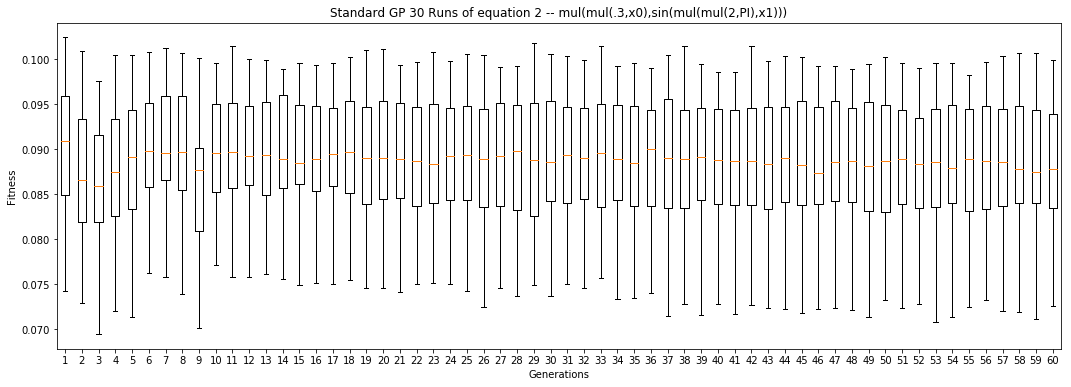

In [17]:
data = [[0.09606542877337715, 0.09770541009707907, 0.08948755451126075, 0.07428942054729178, 0.10244348166899396, 0.08527368648801642, 0.09541372637017967, 0.09187363452167785, 0.08504689248675958, 0.08343613723615782, 0.0924970019647917, 0.09125332546504072, 0.09307175470525562, 0.0984894848083048, 0.07816714952080389, 0.10151724946152897, 0.08736364792561613, 0.08495044435195902, 0.07438892619632569, 0.09987928171495494, 0.08526385697516117, 0.08896062157433092, 0.08227908841410754, 0.09063104401179806, 0.09894337942757436, 0.08392534478551082, 0.09415913337339578, 0.09835791609493569, 0.07840476954880377, 0.09482177049694052], [0.08607819945142323, 0.09718736763445596, 0.08377125483703507, 0.0729522544274438, 0.09593514023281026, 0.08231283063213483, 0.09589853262338013, 0.08919911464046325, 0.083649453717497, 0.07333956755034869, 0.08741952507546633, 0.08358600425929108, 0.0931329194619216, 0.09809302752068631, 0.07755988393605975, 0.10091026416516168, 0.08810245152641595, 0.08690355165677767, 0.07348367160307316, 0.09107285044432395, 0.0825277436215738, 0.08624741567016579, 0.08095350787252127, 0.08936275900128383, 0.09774037739655551, 0.08070347845124076, 0.08176209211895406, 0.0945108513978709, 0.07672523904478304, 0.09345427777487447], [0.09039229078311785, 0.09448889096459022, 0.08550249262727909, 0.06948289568471254, 0.09492489634311416, 0.08159035256919352, 0.09535585481395667, 0.08868323865317072, 0.08289572902930459, 0.0736303365791666, 0.08610540629611686, 0.08568985198637684, 0.0916975402560423, 0.09420091256812393, 0.07632972251478148, 0.09760898523160831, 0.0882599352404432, 0.0861207135466033, 0.07199277269105023, 0.08478181201280792, 0.0842309929194129, 0.08534861871189195, 0.07872665899916266, 0.08818228507258584, 0.09638666016619893, 0.08047319246746065, 0.08331653111644055, 0.09260383232174539, 0.07587899912666994, 0.0914695495081299], [0.09240509572801632, 0.09556603502399917, 0.0839365016678726, 0.07199497751587461, 0.09770329801963651, 0.0800188637149149, 0.09512605100153546, 0.08839410741210454, 0.08457956121272607, 0.08216117443992335, 0.08778690205868817, 0.08811078350234576, 0.08901194571717586, 0.09753216097351558, 0.07367794985509854, 0.10045053651588252, 0.08722108445498762, 0.08533083169421632, 0.07245051387842129, 0.09657192348409742, 0.08389346809840768, 0.0852682327428223, 0.08170166730827247, 0.08547775502221275, 0.09748713402534749, 0.07893805253173397, 0.09059327245582757, 0.09366578066922371, 0.07666682444275574, 0.09170332934762279], [0.09502019461405366, 0.09744185091530604, 0.08457246935047319, 0.0713717208190133, 0.09819685340138244, 0.08334891511098641, 0.09440560951052578, 0.08896175670290651, 0.08678147862255034, 0.08129996999979243, 0.09242030972973862, 0.08842571557854333, 0.0923966841639729, 0.09428097895964294, 0.07854318510180829, 0.10048566486419272, 0.08981429912093504, 0.08699889347900028, 0.07323763473671713, 0.0956240402282549, 0.0836392897427202, 0.08841915859937685, 0.08108612350343393, 0.08941670140480423, 0.09641609075839659, 0.08235589450837864, 0.09167538395500913, 0.09714460336022203, 0.07752295098508116, 0.09263808328067508], [0.09390519560344507, 0.0979468689193365, 0.08714739954505933, 0.07626218251286289, 0.09834104652533114, 0.08638208464826026, 0.0947893180778172, 0.08974777266782798, 0.08987917545237065, 0.08578229206612205, 0.09227877243269973, 0.08945463542359472, 0.09189880961482695, 0.09618219619151998, 0.08363792452951344, 0.100843549426898, 0.08806196973674618, 0.08494330384450484, 0.07844722818554628, 0.09792214553015731, 0.08524381111319236, 0.09003802606890324, 0.08215117990990724, 0.08932087183236581, 0.09810652325917371, 0.08578807076189962, 0.09222531200760767, 0.09577391883562572, 0.08119179462594836, 0.0953259751727832], [0.09262907861927658, 0.09751270592692321, 0.086380090260522, 0.07578134441233954, 0.09660290534439395, 0.08347382318195067, 0.09598067412327384, 0.08777944029238763, 0.08911702832839047, 0.0864893286692092, 0.09167360557755365, 0.08759428649225827, 0.09210797589446953, 0.09629005729880945, 0.08249020994539906, 0.10129604033274743, 0.08999247532594991, 0.09125308685830734, 0.07626499931281872, 0.09852875034159393, 0.08692837536851739, 0.0887861851642999, 0.08085697232086969, 0.0888738744898442, 0.09617074520871965, 0.0869149271717105, 0.09522521669072531, 0.09806890629538127, 0.0821674377170378, 0.09582893552341248], [0.09438964532658957, 0.09601484392000253, 0.08724588576795338, 0.07394083536107739, 0.09745090363884792, 0.08305010563849365, 0.0965584122130801, 0.08875434064876801, 0.08481576563928098, 0.08722113751552886, 0.09287721512255452, 0.08984397661574661, 0.09141857608533313, 0.09598336231444332, 0.08243341593421222, 0.10073030187947023, 0.09095566196136406, 0.08939969026516079, 0.07643489174168101, 0.09721095031519787, 0.08648209964810023, 0.08953905267482337, 0.08152723841071106, 0.08920651328985986, 0.0981387696606335, 0.08515167792012691, 0.09429420431496315, 0.0972585376653984, 0.07902583262089008, 0.09581734544897412], [0.09350538810757518, 0.09634032062208053, 0.0809277250920469, 0.07416526664167968, 0.09872541419447657, 0.08423477251705701, 0.09525692949904942, 0.08807703726018919, 0.08738006740956411, 0.07941677313824395, 0.08939979838983032, 0.0884739228073161, 0.08872356894379013, 0.08930086230528979, 0.07232018853566002, 0.10019480736235911, 0.0898729813215297, 0.07672536171859673, 0.07366758785502579, 0.08878628348186181, 0.08518153813076086, 0.08619177663683752, 0.0701883896504722, 0.09031678615823296, 0.0970415112365871, 0.08229999765189376, 0.0810441621067538, 0.08468266933726935, 0.07781953090264207, 0.09342450492974541], [0.09462345635569468, 0.09789910445977705, 0.08795662092164196, 0.07712452237441722, 0.09960012334149268, 0.08547342929471463, 0.09501485729564549, 0.08937084762803486, 0.08912290218607685, 0.08520377665730233, 0.09186423715281221, 0.08862491646851606, 0.09252942530174622, 0.09718144819797354, 0.08245397714237059, 0.09775706272857737, 0.08719333110593747, 0.0907915985985072, 0.07814001556705333, 0.09466832487392841, 0.08389468791035404, 0.08566973401828853, 0.0810182522683287, 0.08978669343649291, 0.09649250029251062, 0.08474907825970844, 0.09508756968831793, 0.09551663437744239, 0.08147110305664587, 0.0957976159523722], [0.0946305644483137, 0.09484839898609607, 0.08672645636970353, 0.07611494411273131, 0.09906353519759047, 0.08430082434919883, 0.09519386492375864, 0.08834244781702337, 0.08703774286318652, 0.08728729993407498, 0.09197734115484911, 0.08906736429657552, 0.09115731812390726, 0.09573660722907971, 0.08130613365677156, 0.10154234209523107, 0.08868180608895605, 0.08949928769610847, 0.0757754135876781, 0.09817549097343249, 0.0853505856688454, 0.08985747776826976, 0.08241415988760858, 0.0900601677229484, 0.09657985112624155, 0.08507065463386097, 0.09444093587065285, 0.09560997008887277, 0.0787798436229537, 0.09527879754733383], [0.0938405159284179, 0.09608758202598897, 0.08718635397246473, 0.07596576607642484, 0.0997940405083614, 0.086156070357078, 0.09488309300945975, 0.08859693224769388, 0.08812590977062502, 0.08548602341823071, 0.09129085667456086, 0.08867626727832588, 0.09169783479333142, 0.09580688522869464, 0.08132179447765892, 0.10004174257338425, 0.08929610084197732, 0.09058609450448449, 0.07585273725892577, 0.09720243910792901, 0.08359001257991092, 0.08906577021542839, 0.08129887737966507, 0.08931940731462928, 0.0951688215604608, 0.08601751466254219, 0.09349223595548649, 0.09484582063669834, 0.08011049016546114, 0.09545558898737903], [0.09189684545956943, 0.09911166300727149, 0.08479351551288074, 0.07616231679896635, 0.09919545751327885, 0.08540163319884157, 0.09557745140898885, 0.08908239610157107, 0.08791444779918552, 0.0872199697496064, 0.09133334347664916, 0.08615956974044855, 0.09213861495724876, 0.09682580783887557, 0.08083655804298787, 0.09992896121355639, 0.08991555799513702, 0.08227709227330159, 0.07624518608318753, 0.09593807224533636, 0.08405819700253653, 0.08970938767570896, 0.07995177518102636, 0.08730872273661952, 0.09603404675163899, 0.08661556859020908, 0.09391910824406599, 0.09627842249872304, 0.08032187848441666, 0.09415869509353285], [0.09289736510239893, 0.09665198686856102, 0.08553633076019712, 0.07562161942404506, 0.09797351750016305, 0.0860095958239647, 0.09637610227290837, 0.08790572687106658, 0.08878789462832823, 0.08614213752424274, 0.0876406606090868, 0.08815017609412437, 0.09270813354461056, 0.09636897057647102, 0.08179573472551827, 0.0989789747954811, 0.08800499160470092, 0.09066466900990543, 0.07626925898245401, 0.09739173287380803, 0.08522764382317394, 0.0891169788356543, 0.0813869048133717, 0.0901636105172643, 0.09768867033628735, 0.08543620807902093, 0.09398210458417909, 0.0973936904132438, 0.07927968876083939, 0.09521843248961598], [0.094183101405042, 0.09812492739282107, 0.08585491757420931, 0.0755090219089232, 0.09920281744909845, 0.08447330118785051, 0.09462077991907343, 0.08865371683250108, 0.0876478323484158, 0.08689914015110317, 0.08940759127848402, 0.08797921717034492, 0.09295946338630977, 0.09475368555252822, 0.081135478129956, 0.09959333469553275, 0.09148446918526165, 0.08832397083600431, 0.07497269353357817, 0.09662434227021792, 0.0869212435124867, 0.08729945745415042, 0.08214386619323474, 0.08814492983341672, 0.09747174054486984, 0.0835612902666295, 0.09519762676109964, 0.09628400245857012, 0.07860139296066534, 0.09501340467255107], [0.09172585006009838, 0.09788391565976207, 0.08722214464544742, 0.0763301572027205, 0.09937201052352305, 0.081785564750132, 0.09626991296664632, 0.08748523018787485, 0.08604407000075015, 0.08677726165597549, 0.08723316448952775, 0.08863838568685492, 0.09318525818902054, 0.0946750026134124, 0.08094909939486994, 0.09862606092115424, 0.08919805168410003, 0.09004008109339268, 0.07512833344016796, 0.0984178218331708, 0.08517988883283581, 0.087593444714665, 0.07890578230795749, 0.09051750661625571, 0.0958304129024607, 0.08448656728759475, 0.09492392229207194, 0.09686869881768755, 0.0773270535024322, 0.09355907303435573], [0.09457429052061102, 0.0992682533784853, 0.08606646851583244, 0.0754592313746642, 0.09906924652319103, 0.08506331108095792, 0.0957152559733011, 0.08835694173116021, 0.08882216947492459, 0.08702080431780533, 0.08763773740351001, 0.08612910756171599, 0.0922398916749872, 0.09653396220335192, 0.08087418609928959, 0.09965512720193417, 0.09174212867028587, 0.09033476683293437, 0.07502124854388101, 0.09607369394150697, 0.0858695531042551, 0.08932714867865339, 0.08010673131988609, 0.08968334808118164, 0.09715142663722377, 0.08354109132370313, 0.09428413806198357, 0.09451582808498957, 0.07945412275288118, 0.09248001887835669], [0.09460280396742006, 0.09898394057927876, 0.08408866857890279, 0.0766615744192144, 0.09964990323753062, 0.0857516210145308, 0.09516208944155403, 0.08892232003659137, 0.08729247792870366, 0.08501889699188249, 0.08834277819383486, 0.08870381864957208, 0.09264498703840368, 0.09541000036802928, 0.08079215535095177, 0.1003233085827607, 0.09082638892645128, 0.09051124943357497, 0.0754644999149438, 0.09847776887246024, 0.08557108359394168, 0.08777398928926443, 0.08153317628139514, 0.09056857099556304, 0.09729083588632233, 0.08274078306447769, 0.0921774445900428, 0.09766523532706192, 0.07849129833642013, 0.09627242871234261], [0.09305110787625742, 0.09684724835153692, 0.08389062570907554, 0.07681403751870036, 0.09910622033749833, 0.084743282884077, 0.09530725629573016, 0.08836622029928293, 0.08644594431793096, 0.0839251997002892, 0.08791179739264773, 0.08680790731482028, 0.0929166836787596, 0.09569023214348427, 0.08016618972681283, 0.10104125177646, 0.08980836761235109, 0.09158997270037807, 0.07463298634824195, 0.09785444665624933, 0.08392911673123261, 0.08818815664823934, 0.0821856558143825, 0.08977639304863433, 0.09768176677266391, 0.08239403830807884, 0.09236893690895157, 0.09704818752334286, 0.07885766624750286, 0.09211518125802695], [0.09479942051027279, 0.09802473103763941, 0.08427391832368848, 0.07682629888019897, 0.09704746150772679, 0.08491722063492269, 0.09428658395811375, 0.0894690269906268, 0.08799105787931574, 0.08303374078223401, 0.08840884219033211, 0.08926801972677151, 0.09156603114315677, 0.09699167663169043, 0.08238668759390286, 0.1011828872572772, 0.09097552498492469, 0.08798719956131842, 0.0745457580444773, 0.09723791300004289, 0.08720304413483675, 0.0872370425700001, 0.08247589394684789, 0.08881471570865729, 0.09687262142972124, 0.08360603818211391, 0.08948294035217455, 0.09698385534231423, 0.07883850130118288, 0.09559677150070563], [0.09276701087474588, 0.09817739537857498, 0.08360075457951197, 0.07419800784791132, 0.09901398528269674, 0.08418906274241839, 0.09670762444430084, 0.08776981690546784, 0.08862159808968834, 0.0844835762620796, 0.08692898526806252, 0.08844358727401182, 0.09191967150010259, 0.09584252182923396, 0.07926397369268347, 0.09935625750501614, 0.08932162826972517, 0.08954817256530292, 0.07426106266234463, 0.09553505097693071, 0.0850934239721892, 0.08961475838384683, 0.07999308940918154, 0.08849184078332939, 0.09735567715490047, 0.08488438333443099, 0.09206165051423494, 0.09690552751032386, 0.07981388398306616, 0.09383709344260545], [0.09484484132505634, 0.09908752650249572, 0.0839387610385966, 0.07649746923218803, 0.09889463792058895, 0.0833915227566611, 0.0947459437188169, 0.08683900708963696, 0.08794710659374927, 0.08359263505466526, 0.0872329527259008, 0.08700032830067321, 0.092537683119815, 0.09444671345170381, 0.08162879155974946, 0.09974579910928244, 0.0903791716114841, 0.09080409182786119, 0.07504857911180617, 0.09558267889727506, 0.08494270734639404, 0.08857785272210864, 0.08226243201858849, 0.0889533816580146, 0.09622476820307474, 0.08298037370654336, 0.09204837612652182, 0.09488629122020348, 0.07828098019533003, 0.09405638081327126], [0.0938558955781113, 0.09672826477726598, 0.08384108766486767, 0.07598282488782956, 0.09862429669305195, 0.08314457066351098, 0.09522656404306756, 0.08788704370005575, 0.08699053771241763, 0.08355104341251486, 0.08877614560697301, 0.08978510546916765, 0.091152655184335, 0.09640271913650453, 0.08090177272289091, 0.10078584593318654, 0.09083553256866181, 0.0873048657253533, 0.07519850056332578, 0.0957150801809749, 0.08536550984567758, 0.08782813691564305, 0.08077304557353526, 0.08709882146738865, 0.09779661701126076, 0.08456624478161036, 0.09144258998887661, 0.0958274565072674, 0.07892279059620805, 0.094687918629707], [0.0943164974327856, 0.09672243350151057, 0.08332632303842306, 0.07805043342632254, 0.09978860881352963, 0.08438272075587189, 0.0952247489705797, 0.08838268457593844, 0.08804197167143896, 0.08444098579186406, 0.08924246102205756, 0.08874404662093521, 0.09292115190714736, 0.0946379700346033, 0.08017704720080793, 0.09854121024138729, 0.08877764943692384, 0.09114021917321427, 0.07503220389849502, 0.09643557462485376, 0.08546305347097734, 0.09005397166382469, 0.08171360423181645, 0.08919995258316409, 0.09711471700021233, 0.0834344146348134, 0.09246883663686659, 0.09814669292021942, 0.0788301445377047, 0.09158697824480903], [0.09409929829374424, 0.09852583717682016, 0.08331792885748689, 0.07686794624318624, 0.09852681719414241, 0.08316814333891888, 0.09504209917063731, 0.0879041639120758, 0.08926229516918667, 0.08432116034824588, 0.08944844170783996, 0.08864410376216936, 0.0929728848661125, 0.09626980786330629, 0.08128702735052047, 0.10063980578447343, 0.08744287881524972, 0.09174842472593393, 0.07428940741647949, 0.0967525651487155, 0.08657906948775915, 0.08954015166053601, 0.0813360496785302, 0.08907210767183703, 0.09864689972539133, 0.08447575508423258, 0.09057774798258664, 0.09675922850826284, 0.07750066072931831, 0.09331439317359667], [0.09365473538960488, 0.09885219011590902, 0.0820942515757988, 0.0761909877015288, 0.10049909929031864, 0.08274172180903434, 0.09480111607733832, 0.08891351466554666, 0.0888174685383694, 0.08426608043338879, 0.08862526754037851, 0.08896137762202211, 0.09159408731505879, 0.09634706943997268, 0.07988848366263374, 0.10000986637618602, 0.08897411312359932, 0.09155021491068675, 0.07243531604386019, 0.09767201200873202, 0.08519651026274083, 0.08707872557833476, 0.08159794748243956, 0.08979831747752437, 0.09664230718624038, 0.08332232624944191, 0.0930515748447751, 0.09770797226158102, 0.07821652964992314, 0.09375019819543311], [0.09448711764606016, 0.09843793528994987, 0.08361911075032522, 0.07670872987804946, 0.09763721445261954, 0.08303281208154073, 0.09667198959505925, 0.08916748531773305, 0.08693070196879578, 0.08383615890968965, 0.08820919452260545, 0.08872835664623752, 0.09099365121541021, 0.09536656840836806, 0.08087477659392997, 0.09916147622426845, 0.09011914467355299, 0.09052394069532729, 0.07462525279611783, 0.09593985991403106, 0.08550160985108465, 0.08935836681583503, 0.07962194359771192, 0.08868245440635054, 0.09783690599783076, 0.08314473494829944, 0.09254302416449765, 0.09585074140725205, 0.07924753203774425, 0.09352171181825682], [0.09456034837038224, 0.0952026538115098, 0.08292392309259586, 0.07373233469006746, 0.09785601457718054, 0.08154922780545724, 0.09575486611221583, 0.08636212426934115, 0.08411547683061056, 0.0830439013502308, 0.08742886980466186, 0.0872817014219992, 0.09287608340959101, 0.09504238825449732, 0.08075746305500842, 0.09926047273692111, 0.09020889880226513, 0.09087455832557663, 0.07422137833264361, 0.09556952827053981, 0.0858868304232453, 0.09055729498420621, 0.08266072500097878, 0.08950131969949793, 0.09781355875976325, 0.08384518464887226, 0.09023830204007888, 0.0979765411193093, 0.07774115919746076, 0.09340484803370958], [0.09423188707638637, 0.09928690356355874, 0.080519624560438, 0.07488042204426322, 0.09845825136017171, 0.08358625568135299, 0.09558749239832369, 0.08836806543608765, 0.08631374241002543, 0.08181481950696468, 0.0871743798756037, 0.08929445889775238, 0.09329583821693835, 0.09691562609941144, 0.08206291389398729, 0.1018808232803702, 0.09023457214064406, 0.08466276872841434, 0.07497633643142697, 0.09543701895573721, 0.08604920507866948, 0.0875478778044119, 0.08067899369158527, 0.08952695472549564, 0.09745259432033883, 0.08229989037511931, 0.09199229386138218, 0.09721697888543777, 0.07780694484304557, 0.09217634742569614], [0.09201563280618891, 0.09762726040174244, 0.08422231995047921, 0.07372813143430836, 0.09900092888677231, 0.08226420363479209, 0.09592740562973268, 0.08858105499985663, 0.08576503203131552, 0.08429006055901678, 0.08700671261320242, 0.08685805466356661, 0.09323290638701932, 0.09615031115691192, 0.08000181665733576, 0.1005689181900677, 0.0906290395152811, 0.09038019865501062, 0.07520314115337412, 0.0969572847930879, 0.08527695466594984, 0.0881161174915127, 0.08129474088685466, 0.09007034186611165, 0.09892401091670863, 0.08230466453616055, 0.08854468030866464, 0.09710885283201319, 0.07746059817741392, 0.09370460755035331], [0.09439843676174385, 0.09946076809317592, 0.08413943501054105, 0.077128286527278, 0.10010309321332278, 0.08397830300449854, 0.09611156441593614, 0.08552304706869379, 0.0888438978894828, 0.08297293114948687, 0.08896480016198834, 0.0890672854844735, 0.0933446856251783, 0.09797585345976623, 0.08020022056378794, 0.10033055378332041, 0.09048095139828638, 0.09148297147190386, 0.07502467701779557, 0.0968047802812687, 0.08575240213607119, 0.0888561736532273, 0.08126537079055797, 0.08970188756824185, 0.09753111313022134, 0.08245727186984296, 0.09038736029401967, 0.09486410747928298, 0.07821694643031761, 0.09438417030773825], [0.09423855062100452, 0.09755272114823617, 0.08292098441883743, 0.07603136394395638, 0.09909521467612266, 0.08450073822497638, 0.09469944425591612, 0.08959976523026414, 0.08822093425753695, 0.08480249732848005, 0.08693715879188067, 0.0883493355743746, 0.09096455941201888, 0.09592975499812557, 0.08122805599372443, 0.09994211168466921, 0.08936125425231599, 0.08458123872410024, 0.07457422523123317, 0.0956093529856835, 0.08543696502777781, 0.08875830977876088, 0.07952753291223855, 0.08923357765100841, 0.09755716901595841, 0.08336671865944813, 0.09188146907520608, 0.0984493691642575, 0.07711223005749025, 0.0922777216449948], [0.09590460542144166, 0.09817828711234086, 0.08331989343828385, 0.07637669545295173, 0.09861007383523204, 0.08324985369327266, 0.09508422670762046, 0.08862746270138573, 0.08630213007881832, 0.08445551665441157, 0.08849736046032347, 0.0903965408199567, 0.09275210421056769, 0.09499683232139253, 0.0808696835764347, 0.10145093493101001, 0.08917337350340301, 0.09139107455489086, 0.07571097945579244, 0.09736836015068082, 0.08544851426082213, 0.0898151216819229, 0.08144443267591697, 0.08929853259582254, 0.09657373419308951, 0.08248934018093577, 0.09125033468396102, 0.09730158153978359, 0.07782634600808465, 0.09272979781032518], [0.09404256511998421, 0.0992607726371047, 0.08402806042526718, 0.07339343008572118, 0.09863922321988497, 0.08236281106647482, 0.09537760704362495, 0.08955684971255767, 0.0866546903195247, 0.08431169074782525, 0.08777869733924115, 0.08968982495193385, 0.08758921053248257, 0.09550495773230515, 0.08048306410211994, 0.09868946940898006, 0.0901258786670138, 0.09134806425667791, 0.07486477294596003, 0.09682604569141005, 0.08450816287166225, 0.08810908870820493, 0.08144213455493184, 0.08820237889414478, 0.09658865190597565, 0.0848545609455253, 0.08964118495626486, 0.09522763184649007, 0.080148172388198, 0.09301870318434523], [0.09443736962379846, 0.09738780569737271, 0.08372631951227033, 0.07350234052692269, 0.09960880087415427, 0.08192799607814691, 0.09493246184027436, 0.08864507772712121, 0.08759453356035594, 0.08366605912689475, 0.08548939728087691, 0.08927936362100859, 0.09194198238128679, 0.09510482167604248, 0.08128252017001467, 0.09931976799753064, 0.08842656849783964, 0.08826904592467116, 0.07349511233296495, 0.09512428151216465, 0.0850973201706607, 0.08845227457719979, 0.0809014105948393, 0.08709602833138082, 0.09674992060421259, 0.08154283614220767, 0.09212825045745049, 0.09586636463463373, 0.07868622769968682, 0.09064542971821538], [0.09345468756872201, 0.09783929289924008, 0.08336145009540255, 0.07426295316716056, 0.09603666624891062, 0.08250689054222059, 0.09463841902405859, 0.08803618058720851, 0.088267198709739, 0.08359442464285259, 0.08962109214407755, 0.08969955739220971, 0.09112009761083921, 0.09456668962504688, 0.07987430373683722, 0.0991011182818091, 0.09088989688174952, 0.09040879323957468, 0.07402174786269883, 0.0961924519583081, 0.08524916160973002, 0.08925791049469092, 0.08212452255903366, 0.09059675030867104, 0.09681122056012416, 0.08396356536159828, 0.09086571018472835, 0.09706892194030019, 0.078145857589332, 0.09386019654634596], [0.09510843538466446, 0.09756030716221027, 0.0823999097351521, 0.07470157474441087, 0.10003575637972985, 0.0841493461390695, 0.09570697779066573, 0.08737517949045304, 0.08863583970923655, 0.08278313350848356, 0.08707125128325544, 0.08879563732366993, 0.0918639848301379, 0.0963591200374231, 0.08060018780767562, 0.10049326720520133, 0.09057772812333544, 0.09173301015941515, 0.07149421977321611, 0.09653652070589339, 0.08522973002407103, 0.08875670633271399, 0.0807627473671866, 0.08936109583505687, 0.09706472577201262, 0.08320730881539937, 0.09185020323706, 0.09782431226947254, 0.07838942958089125, 0.0921889148101023], [0.09414566817326511, 0.09452118630303315, 0.08329901819340517, 0.0730770085694042, 0.09831012738920236, 0.08201755486615493, 0.0957409754816654, 0.08910025274609869, 0.08671917537535431, 0.08261784036010028, 0.08749885291115377, 0.08817627227179388, 0.09072215762797359, 0.09698743212564111, 0.07986419651291315, 0.10148968423457995, 0.08917795436892997, 0.08881262561885374, 0.07277533029445388, 0.09554900557658678, 0.08551606376108048, 0.08837895154088124, 0.08187378005141778, 0.08932380788409443, 0.09567368766576739, 0.08405722102901636, 0.09293869071774165, 0.09655037952071914, 0.07750893361526794, 0.09267547686041697], [0.09375129255875064, 0.09762485316768744, 0.08359466319315917, 0.07304352194110499, 0.0984150617543189, 0.08294649887601777, 0.09482153827335361, 0.08835803985861722, 0.0857303222001557, 0.08475130225939778, 0.08807296408526023, 0.08902044097043352, 0.09098525425078927, 0.09700209993475511, 0.07833355510581905, 0.09944877573007531, 0.09060764566813025, 0.08967765999697228, 0.07159075795379678, 0.09671367072139679, 0.08520770679083511, 0.08703922969715841, 0.08176997947958392, 0.08939883980183472, 0.09763993517044459, 0.0841875698847458, 0.0903302142831311, 0.09784179300291915, 0.07998940815805715, 0.09308833959699918], [0.09457098142377418, 0.09442360492504866, 0.08447309081220172, 0.0728086325231847, 0.09858494935012432, 0.08350715574481214, 0.09688462517276396, 0.08848208010037552, 0.08606590252931919, 0.08373532928187606, 0.08664461343012907, 0.08920447227864405, 0.0896339405186004, 0.09464807458274863, 0.08051227797992411, 0.09823011447003117, 0.08821099899293659, 0.09009296590703168, 0.07289576577902368, 0.09618103400277461, 0.08609384939489416, 0.08912371768576571, 0.08041419753836292, 0.08823256768836725, 0.09797599054093874, 0.08244561011266972, 0.09202287834384976, 0.09643947790477138, 0.07806313567874029, 0.09307043517577139], [0.09345974194885125, 0.0977022865501162, 0.08168326555760873, 0.07174259824491364, 0.09863834130935535, 0.08319937070185032, 0.09635739400703962, 0.08847140179600446, 0.08502347036405745, 0.08412272017647589, 0.08897463629324279, 0.08829254227181751, 0.09267916246565673, 0.09440357632493995, 0.08145026289048997, 0.09852149316412859, 0.08827943040529912, 0.0905411276749555, 0.07220645359934902, 0.09502042544816405, 0.08667503308553463, 0.08947049198066584, 0.08130816653058767, 0.08853292046918997, 0.09758495506643744, 0.0836791838213207, 0.09141650123834523, 0.09624077190657473, 0.0774526438690856, 0.09436653912913953], [0.09381362746340757, 0.09543817678898511, 0.08246890822710477, 0.07266860308896106, 0.0989256205328327, 0.08375167407627504, 0.09654958226712723, 0.0856944728486698, 0.08501564589464633, 0.08384439187684802, 0.08475876802221981, 0.0894912836185261, 0.09045536734986885, 0.09540097837625063, 0.07885982439104809, 0.10148465792446967, 0.08926043972440595, 0.09028907297861251, 0.07319700643473256, 0.0968912537407532, 0.0846700623590572, 0.08724145449402067, 0.08172645244135511, 0.08809495410048615, 0.09642314422497301, 0.08240103866374514, 0.09216225333795908, 0.09493509105209055, 0.0791231201103149, 0.09027298987503315], [0.09291339036472568, 0.09579850264144361, 0.08316479453521908, 0.07319060588530259, 0.09977949998244381, 0.08335337576067188, 0.09509327275464514, 0.08861691964086184, 0.08580401696998888, 0.08358998733288547, 0.0864366021112757, 0.08853581630433617, 0.08938533428766025, 0.09672225677398273, 0.08124544611182516, 0.09849961298370401, 0.08707766851728405, 0.09056898656724446, 0.07234389947655125, 0.09558385463116127, 0.0865025825043278, 0.08762743347252286, 0.08071151219417026, 0.08820005541747654, 0.09768296233076795, 0.08138026290143623, 0.0894905296360726, 0.09667199138676573, 0.07636525174858086, 0.09374836998213028], [0.09211248558716117, 0.09701985403286446, 0.08473846670039606, 0.07311259811365896, 0.09811997662552907, 0.08387371713143704, 0.09414723279401185, 0.08895612783481156, 0.08481872125633784, 0.08390105657360904, 0.08847320359003238, 0.08936964834495038, 0.09070049295228795, 0.09721163315878806, 0.08153450146928722, 0.10036327270618184, 0.08944139070988369, 0.08908891559043403, 0.0722141113608342, 0.09497559265085896, 0.08496143619414856, 0.08822385168017452, 0.07996274334394392, 0.08736349662887817, 0.09597138823591285, 0.08303191264216919, 0.09106022072623698, 0.0971002778238434, 0.07882442363952344, 0.09532564198564926], [0.09394833849901349, 0.09630060377577647, 0.08453712654951248, 0.07178362393845826, 0.09967414695932678, 0.08276986249299824, 0.09657920318053902, 0.0882277276484039, 0.0860676925896889, 0.08323797700730945, 0.08689725980479829, 0.08901557917028845, 0.09045603753819476, 0.0957925715392211, 0.08033431041677769, 0.10022131522636292, 0.0896078338714492, 0.08827300725208458, 0.07196570650434478, 0.0971397878461253, 0.08684328755892604, 0.08657923833445207, 0.08248247668685536, 0.08796000080256475, 0.09768254218505927, 0.08363516259562884, 0.09161868330917217, 0.09718375306468856, 0.0790735841456641, 0.09312415578907418], [0.09479578758403288, 0.09590024133213101, 0.08321378562597358, 0.07225521194907233, 0.09737812680210027, 0.0840258901353069, 0.09440166671319693, 0.08769617653084676, 0.08577474995201625, 0.08441266457486896, 0.08729121025758114, 0.08978316120792582, 0.09138138861631404, 0.09634536422451635, 0.08071363490046365, 0.09927350164562573, 0.08700529433145066, 0.08717090840788719, 0.07285875600484253, 0.09648202971905319, 0.08395541502019811, 0.08746029035464839, 0.08044401312035798, 0.08699293360286797, 0.09571812880649262, 0.08372945292280597, 0.09167033912104594, 0.09575676079476284, 0.07964566812111398, 0.0939851689091392], [0.09383326709115325, 0.0964296502543564, 0.08416499809622395, 0.07333278357030862, 0.09813838585485957, 0.08448874724929081, 0.09671653533275314, 0.08883446604240401, 0.08649984119412915, 0.08289089657567021, 0.08800569709248186, 0.08882330011112519, 0.09130092166706281, 0.09592952760668566, 0.08012244097913156, 0.09929983571920263, 0.08841947864194954, 0.08733575226884162, 0.07242446060066288, 0.09648079091089425, 0.08575813399290316, 0.08805120661079481, 0.07985706123454255, 0.08881166197115418, 0.09658930238575163, 0.0833319258903055, 0.09182144869165894, 0.0958606007005703, 0.07875127658311663, 0.09332335460555835], [0.09227638505261525, 0.09510452958895393, 0.08415416347348902, 0.07212483923440188, 0.09823938670640363, 0.08270009695312391, 0.09578075365448334, 0.08835762369028079, 0.08641392696105613, 0.084437333820593, 0.08780637897617331, 0.08895751261985999, 0.091593177661869, 0.09426643477298567, 0.08194512517045602, 0.09895213389956206, 0.08934860782747257, 0.08922775518460077, 0.07314216846419025, 0.09782692286190858, 0.08321571218704617, 0.08806104264599435, 0.08139828297963084, 0.08625090004797806, 0.09658789246201875, 0.08419717185265678, 0.09168296001687859, 0.09602978460534531, 0.0773781892461958, 0.09477908464400667], [0.09474043952778269, 0.0967028508588095, 0.08226307598219627, 0.07137726854115367, 0.09831419842683672, 0.08299449757150154, 0.09545721499890837, 0.08857554035629443, 0.08552340226125274, 0.0834398862337891, 0.08585280745337516, 0.08789810765533884, 0.08991293404751355, 0.09622426902691128, 0.07936112092693542, 0.09954782414965208, 0.08943023729043197, 0.08841471325208931, 0.0734583183115371, 0.0963540453554562, 0.08554653724165352, 0.08683403892308898, 0.08190722854311092, 0.08582944679930832, 0.09741728545115728, 0.08161600031216967, 0.08854487296941922, 0.09690844211234345, 0.07814119620289191, 0.09335370375943877], [0.0941895005533234, 0.09625921256909759, 0.08293397398131559, 0.07326063419520883, 0.09754878876913525, 0.08221426655247394, 0.09523297075455692, 0.08885006757081773, 0.08734677419957401, 0.0837220383915383, 0.08681193296222554, 0.08855307891462975, 0.09061821507227165, 0.09604276248680689, 0.07959502991499617, 0.1002777693649766, 0.08880264148576276, 0.08687152664363132, 0.07339650012451153, 0.09756107962439106, 0.08348686651040672, 0.08538768744606022, 0.0823565962893533, 0.08968325736033815, 0.09696343710222305, 0.08292155020988157, 0.09085412785958831, 0.09776853356105664, 0.07818137654517186, 0.09249966176542752], [0.09400984362751197, 0.09669833553611493, 0.08375831166058946, 0.07366546491627995, 0.09888242456727415, 0.08241913778442969, 0.09457594812028258, 0.08894231960811896, 0.08612417149863646, 0.08326593010509292, 0.0871421225204251, 0.08802642185148464, 0.09104860097868792, 0.09571697404065037, 0.07966825708647887, 0.09965988215568655, 0.08989037595489696, 0.08921201057017097, 0.07232874836106423, 0.09554035222439382, 0.0851809995341122, 0.08588185605946988, 0.08124996435161697, 0.08899473174072942, 0.09628009405993804, 0.08429812664070559, 0.09073345445864883, 0.09533998777811055, 0.07869438244247758, 0.09176475348321343], [0.09367844272714441, 0.09645607204097369, 0.08342616999138273, 0.0727863441223999, 0.09825290817985327, 0.08329358685003942, 0.09499836706670192, 0.08684002917163205, 0.08530101922453985, 0.08302228244796118, 0.08794591737339325, 0.08941798971978203, 0.09103294532488021, 0.0930516986653725, 0.08100112892589878, 0.09906693838764527, 0.08961276534604705, 0.08589487612192581, 0.07299561976858591, 0.0960474408918108, 0.08570261728382403, 0.0857469284678557, 0.08185834586083095, 0.0888590472116774, 0.09759627737107325, 0.08376868711564044, 0.09190119741874142, 0.09724877460235681, 0.0771253337948216, 0.09266694131329832], [0.09453477116167501, 0.09664960989222351, 0.08356053705155965, 0.07081927917165096, 0.09956858071089437, 0.08272194444404504, 0.09428088646751312, 0.08924169103952392, 0.08375518890934706, 0.08348582873151056, 0.08642763080375081, 0.0887109144269481, 0.09143199854182227, 0.09517728823716422, 0.08076247080157836, 0.0992273531522785, 0.08875784652612656, 0.0880064667850499, 0.07313903402007199, 0.09688055355623439, 0.08445929779054244, 0.08774376358417085, 0.08054449429609442, 0.08841209967167288, 0.09723859878287701, 0.08412970136486386, 0.09071653123788195, 0.09672104602043129, 0.07947642101934009, 0.09208866612401516], [0.09439959491197865, 0.09700201182830573, 0.08284194561153692, 0.0721609404856421, 0.09835857453754998, 0.08460529165135908, 0.09515767202880344, 0.0874196514633481, 0.08630855197449223, 0.0832415088855728, 0.08713068607852742, 0.08793247192479388, 0.09074160296146888, 0.09707802826379915, 0.07906882341512445, 0.09955688525829173, 0.08828407306218784, 0.08826927672481279, 0.07140206151178617, 0.09718436670852793, 0.08651112089405097, 0.0880114306535076, 0.0817097855667755, 0.08711347128221113, 0.09749822072561927, 0.08381843393878052, 0.0911162656683344, 0.09781411252968357, 0.07908899036342945, 0.09392190803606379], [0.0944794124013214, 0.09663738838854508, 0.08245448244430659, 0.07250291123554879, 0.09637265233277488, 0.08273938410265906, 0.09668353498061347, 0.0893753104197263, 0.08662206914789232, 0.08347092330412721, 0.08625461242229421, 0.08966852727713309, 0.08975689804768633, 0.09522212511611704, 0.07983942075593602, 0.09822307769184971, 0.08839252249790795, 0.0893622161432589, 0.072856876828658, 0.09432935895742667, 0.08322274989228541, 0.08856605364838242, 0.08171319611724476, 0.08838301960845708, 0.09780935814613594, 0.083195339619279, 0.09152176597538603, 0.09702989855013505, 0.0803287710761773, 0.09388992418909996], [0.09548953388575512, 0.0953197069878194, 0.08300673495040302, 0.07327535484045766, 0.09611653872988715, 0.08052083570710239, 0.09355562979038595, 0.0885162873720394, 0.08560818480740073, 0.08297041819182513, 0.08437722865626394, 0.0891838151047856, 0.09181464577578881, 0.09614098070082841, 0.08028710671371934, 0.09976537528172, 0.08871541738363907, 0.08874786487424827, 0.07330666905786695, 0.09662484241411456, 0.08498364619300484, 0.08678848445396242, 0.08170293984406372, 0.08869989725094092, 0.09691150840999886, 0.08428602772909201, 0.09218216043776285, 0.09639736906542902, 0.07847064548569531, 0.09305887835622254], [0.0947617811924845, 0.09640195222611644, 0.08062454362733844, 0.07244992354281689, 0.09793785105901032, 0.08333756140319928, 0.09604089240633375, 0.08863887383773673, 0.08593661775732114, 0.08327927813007463, 0.08799230877145073, 0.08995284712313587, 0.09179489628987557, 0.09605542141439215, 0.08159448676010805, 0.1004073264457822, 0.08847981884154736, 0.08919587476057961, 0.07204357345840921, 0.09355770633142313, 0.08580537495128251, 0.08550362466954448, 0.08084953785817132, 0.08833082245040827, 0.09657112475585151, 0.08472701829667478, 0.09155715271859825, 0.09844766625878369, 0.07731856294391536, 0.09322929286795732], [0.09345279661834882, 0.09613547148318889, 0.08392898416440053, 0.07357162240685781, 0.09847715810366105, 0.07977384970525829, 0.09556298336797672, 0.0889129720159543, 0.0865385945953254, 0.08422883382969716, 0.08697570158741572, 0.08872746465036085, 0.08836114213311551, 0.09581460967161733, 0.08077795376703947, 0.10073013630289, 0.08927043568877141, 0.08701080400005902, 0.07196501291960208, 0.09522691171571715, 0.08552299045362897, 0.0868011240444253, 0.08129555960436691, 0.08717301207554559, 0.09757146121362485, 0.08375352733766735, 0.09204530146954619, 0.09659521988237568, 0.07893994517917087, 0.09175831709892439], [0.09463628676103039, 0.0970924922203315, 0.08266563759494229, 0.07118564863164221, 0.09781071029704866, 0.0830934219840316, 0.0936615406732151, 0.0893063227374638, 0.08628775246384633, 0.08406279141012397, 0.08721267601850027, 0.08754646209500329, 0.09000327959127906, 0.09705758346009025, 0.07919531632606373, 0.10070652879352514, 0.0899302706598153, 0.08705508401452426, 0.07290562960315089, 0.09717000612556301, 0.08493365446298373, 0.08675027921285415, 0.0821616733101637, 0.08736321577405556, 0.09725063213889967, 0.08411460751678053, 0.0907568966792492, 0.09748907385297327, 0.07912528668680333, 0.09378464174806941], [0.09326474355815716, 0.09461504310135556, 0.0831077501928225, 0.07257264871075891, 0.09953702771887316, 0.08292122120609574, 0.09394426879459095, 0.08771063128940775, 0.08600436266591244, 0.08405425318867898, 0.0860374302582439, 0.0877565114021276, 0.09123158767027142, 0.09546370889047626, 0.07673458108751209, 0.09990554761283635, 0.0882475827311791, 0.08811896435392982, 0.0725463788669069, 0.0953078617618469, 0.08481783495852567, 0.0858618538417294, 0.07938492335342107, 0.08779556894908049, 0.09715307924938221, 0.08331664445195898, 0.09137602620166954, 0.09767972565605836, 0.07799871738447667, 0.09396778920406211]]
fig7, ax7 = plt.subplots(figsize=(18, 6))
ax7.set_title("Standard GP 30 Runs of equation 2 -- mul(mul(.3,x0),sin(mul(mul(2,PI),x1)))")
plt.ylabel('Fitness')
plt.xlabel('Generations')
ax7.boxplot(data)
plt.show()

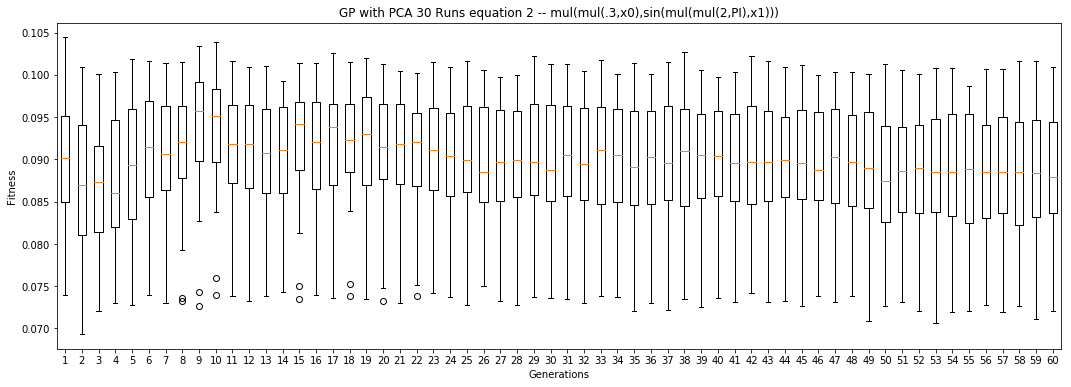

In [18]:
data = [[0.09574691767969155, 0.09494311257948211, 0.086236475356579, 0.07393215888151546, 0.10041837207246881, 0.08677354926375419, 0.09760696291831801, 0.08998545847464269, 0.08366877928147064, 0.08507201831646975, 0.09043221660297117, 0.09354677628132028, 0.09526946593745754, 0.1002609060439417, 0.08010779806229812, 0.10443085633020328, 0.08927961453635136, 0.08781445255795653, 0.07490976774453158, 0.09937970330709367, 0.08485586261101108, 0.08656392331091084, 0.0814346969492522, 0.09113382843923672, 0.1019175611992423, 0.08152061031211853, 0.09476426044342573, 0.09206477719148198, 0.07658745956641787, 0.09431354292291566], [0.09406079326108452, 0.09423037056950613, 0.08335737315453678, 0.07309004964334555, 0.09406777933794716, 0.07918763187408544, 0.09685762254989665, 0.08531411233719068, 0.08419732585246067, 0.08307631527747171, 0.08741952507546633, 0.08774200371733692, 0.0902150766997685, 0.09800422715410011, 0.07773676847786037, 0.10094249992147894, 0.08880817670365632, 0.08637444117706385, 0.06935105205728051, 0.09525269853263642, 0.08095460377678554, 0.08149671892272346, 0.08095350787252127, 0.08649769658290311, 0.09808010974171627, 0.0787665897241516, 0.088926145965576, 0.09133200921480382, 0.07674530651217666, 0.09416464055776762], [0.09431691522575572, 0.09717643050644638, 0.08466271017706789, 0.07205873841718737, 0.09495162750726457, 0.08137805288712936, 0.0943266579681753, 0.08327199040671332, 0.08289572902930459, 0.08093679817749076, 0.08744007661511537, 0.08850335505226613, 0.0916975402560423, 0.09562396505919717, 0.07661078273157264, 0.10015384455418991, 0.08836464447520843, 0.08599010039575719, 0.07316948832604017, 0.08970199235790528, 0.08172610883007875, 0.08363648512876722, 0.07931041855959206, 0.0873360794119724, 0.09615200053300813, 0.07759358212515632, 0.09021947752893972, 0.0884678001717538, 0.07595101729227872, 0.0914695495081299], [0.09347483959641346, 0.09556603502399917, 0.0839365016678726, 0.07306899070980556, 0.09743863541231138, 0.08178177354687195, 0.09512605100153546, 0.08606088233134151, 0.08107428857843439, 0.08216117443992335, 0.08778690205868817, 0.08590982615928909, 0.08901194571717586, 0.09755566455109498, 0.07367794985509854, 0.10038509208236002, 0.08799488495346208, 0.08533083169421632, 0.07303365000520093, 0.09662980784915653, 0.08451683825655827, 0.08402198641595027, 0.08089510705060982, 0.08547775502221275, 0.09666072712590655, 0.08193832054995721, 0.0930803835171217, 0.09679793645372609, 0.07657456513774583, 0.09127465411971442], [0.09700553545620842, 0.09763053892720765, 0.08857718841063979, 0.072741156014384, 0.09987140910336893, 0.0845983609915428, 0.09610408550281602, 0.09122559443811463, 0.08022532775022852, 0.0805306027994843, 0.08833322162720011, 0.08871133761064345, 0.09427807194523316, 0.09559244511791067, 0.07766878823568478, 0.10193273701645467, 0.09004579499940639, 0.08699889347900028, 0.07449243433543205, 0.09756840812363896, 0.08516723502433023, 0.08687705553067765, 0.08138400494200407, 0.09008372341269177, 0.0989488727975539, 0.08235589450837864, 0.09483029566288437, 0.09874279360381383, 0.0765867531994347, 0.09498964020805342], [0.0957374007338168, 0.10109223985288038, 0.08546128671604912, 0.0748144015846605, 0.10025388778786032, 0.08933680002294514, 0.0976485060198903, 0.09103470743864558, 0.08549912329243421, 0.0818580486955387, 0.08773572190697188, 0.09383054022912261, 0.09415250433491887, 0.09749366234978771, 0.0813233474564098, 0.10159305396686802, 0.09068782895334147, 0.09127590187833196, 0.0739572158450435, 0.096500620076461, 0.09138229742056815, 0.09144610296172892, 0.08587315326750859, 0.09244661088404735, 0.09936232019837699, 0.0841840153127986, 0.0923099743037105, 0.09748790461075275, 0.0748778550984208, 0.0971145069947215], [0.09493785487073368, 0.10130678780333816, 0.08666995231915894, 0.07581802644305188, 0.09851574660692312, 0.08630655704710709, 0.09806028329118491, 0.09216374661602753, 0.09101611754021183, 0.0844178067576055, 0.0863614795889314, 0.09033563750891338, 0.09484688686810173, 0.09742897390455672, 0.08314803072643447, 0.10140669361923482, 0.09205240320061314, 0.08998349449190053, 0.07305793231297067, 0.09505897039331701, 0.08959010900673865, 0.09003198055531242, 0.08138848087477514, 0.09011568476307634, 0.09938607442328841, 0.08782473200779099, 0.09374267040016816, 0.09898336021717137, 0.08052850809906967, 0.09678092583415447], [0.09669842157804666, 0.09926355446476168, 0.08822380348248672, 0.07362163092315684, 0.09906452828471181, 0.0871646053246627, 0.09891600358195955, 0.08846901272286359, 0.09224127334828232, 0.09017171534145127, 0.0876068726495915, 0.09397541248921444, 0.09523733507761466, 0.09705654291216838, 0.08235599248349608, 0.10149875134005644, 0.09345576206514884, 0.09139489683224537, 0.07321568312761059, 0.09514036497356416, 0.09197462598673971, 0.09170914881577172, 0.0830834395359174, 0.09176617504065922, 0.09952597551703005, 0.08005208287362578, 0.09437886661106597, 0.09959639307578706, 0.07928045275552946, 0.09413449846520397], [0.09581416435903228, 0.10328299674595075, 0.08664152847862526, 0.07430766399501848, 0.10016168433592035, 0.08923283127050737, 0.09913551641484404, 0.10342658449512367, 0.09797383449583326, 0.09945497709559471, 0.08671383790270507, 0.09619751081528717, 0.093544905621676, 0.09546881146732361, 0.08526216141190798, 0.10175815182456886, 0.09345056948493297, 0.10031812842119783, 0.07269395940098176, 0.09565225454585347, 0.0918409834276627, 0.0917160648879482, 0.08270812432843615, 0.09349300068135653, 0.10018866001334512, 0.09758150966053927, 0.09637790938761445, 0.09921535626492553, 0.08570197640298079, 0.09781265469120078], [0.09599091007610339, 0.10114781500453615, 0.08830066890720048, 0.07592140613239724, 0.10079810792239378, 0.08963634039426757, 0.0984396765544908, 0.1038558213131038, 0.09842019704502215, 0.09917005793218145, 0.08614605987167635, 0.09525330708785654, 0.09501166784879883, 0.09790684372421907, 0.08789056886723108, 0.09829930462527164, 0.09009256533139254, 0.10085841314442011, 0.07398819341094622, 0.0941382682229011, 0.09405981323131389, 0.09152532045016235, 0.08373619543152185, 0.09264691598748938, 0.09796719143855592, 0.09492043671349971, 0.09515920701578956, 0.09812208895523841, 0.08697265606517393, 0.09903785096183039], [0.09646276957868541, 0.10152084537107997, 0.08699761436699667, 0.07494291095386246, 0.10002323421794886, 0.08922644016652341, 0.09758323385488163, 0.09423807898303425, 0.0918426295967674, 0.08757595950568829, 0.08781578197600981, 0.09122809728816793, 0.09365794353699676, 0.09704807338734744, 0.08383451488362638, 0.10163216886414153, 0.09316023653211081, 0.09130913340563537, 0.07383990932333549, 0.0962918879430898, 0.08907785875922365, 0.08715282247352553, 0.08396142714910128, 0.09176517369770822, 0.09914718489788087, 0.08547663829379465, 0.09453862313538686, 0.09643248706133083, 0.07835463718934318, 0.0973530166568562], [0.0956727210587896, 0.09956250013464, 0.08745751196975787, 0.07502177629477529, 0.1009920250892625, 0.08635794591442271, 0.09904941114956671, 0.09438865061462769, 0.08739497075452238, 0.08496115093692165, 0.08768793193023651, 0.09262186000132092, 0.09045369760338466, 0.09664178026587697, 0.08382745410817713, 0.10081019203397042, 0.09196912750354048, 0.09221473089738999, 0.07322704768097148, 0.0943867214170025, 0.088658389641412, 0.0907414477685086, 0.08092944243620957, 0.09173705428380802, 0.09755727063162291, 0.08615415522298606, 0.09357038576727368, 0.09675768952049661, 0.07764892182018891, 0.09869582399683718], [0.09396733615048385, 0.09841697256713841, 0.08594036140308596, 0.07521010031614728, 0.10110829877580804, 0.08835220107471198, 0.09913403354697924, 0.09352175546530594, 0.08935297047099325, 0.08396155349594352, 0.08677616314481984, 0.09302835770028216, 0.09222941890199213, 0.09744564719109283, 0.07771618795399769, 0.10069741067414259, 0.09089891823468438, 0.09052525745779973, 0.07388226381286692, 0.094732324591852, 0.08627423821380577, 0.08733027588351, 0.0826697183442195, 0.09021806748187465, 0.09884539736705322, 0.08560834150417168, 0.09543767941722896, 0.0972988225798523, 0.0808025993783705, 0.0962001775163355], [0.09496785579331334, 0.09922041200305552, 0.08573613964426549, 0.07549646055110472, 0.09903517859151334, 0.08573646361876847, 0.09815100161791405, 0.09400106770775585, 0.08962630315141656, 0.08230040818569984, 0.08681399668921382, 0.08995214193946185, 0.0955971034320968, 0.09744215117419605, 0.0850408949179848, 0.09929500912828348, 0.09113043339404792, 0.08911305077679464, 0.07427329726025393, 0.0953566857012096, 0.09121084817977715, 0.08925217348405379, 0.0832000177209972, 0.09307295526251945, 0.09930364421116757, 0.0867759486522193, 0.09407327936459751, 0.09788228381205989, 0.07931765643699132, 0.09647855378009863], [0.09601530653541371, 0.1014245200692099, 0.08616348369419008, 0.07497744706897524, 0.10046227283471763, 0.08873491229902264, 0.09746237774888948, 0.09695982456940934, 0.09176740027345431, 0.08558855145039351, 0.08876528975914776, 0.0970850047129785, 0.09397605449037563, 0.09582686615025329, 0.08261841816574649, 0.10054859497145623, 0.0942960845501114, 0.0954342852157179, 0.07348666749875961, 0.09705349236360084, 0.09054238673165314, 0.09195899176912033, 0.0848618093564279, 0.09128048214256379, 0.10001256542287945, 0.09019064798931721, 0.09528880154151807, 0.0962026121058969, 0.0813381520722456, 0.0955958465851747], [0.09355805519047007, 0.10135883376841309, 0.08680892986257992, 0.07522864938976147, 0.10128485178605225, 0.08582096829741223, 0.09908752675913492, 0.09748044339444346, 0.08756866941446759, 0.08612333068273248, 0.08647899458300243, 0.09226553494063824, 0.09448221797578035, 0.09527161209005203, 0.08673679014305613, 0.09962071794563235, 0.09187107834566319, 0.08987769874789099, 0.07399150281462427, 0.09691350545586536, 0.087689943984133, 0.08742301976907044, 0.08094510277947489, 0.0933574220064009, 0.099098252779641, 0.08617948489884916, 0.09500858458817475, 0.09890393069203213, 0.07739415770441258, 0.09650146869269438], [0.0966447812115254, 0.10253485161036056, 0.08694037227082702, 0.0742797533125709, 0.10050551666463485, 0.08887250706434623, 0.09703600805762251, 0.09551543203867087, 0.09360110761910025, 0.08623956720935355, 0.08706872369087562, 0.09621006942384636, 0.09495457117447617, 0.09726894548626859, 0.08386850348561935, 0.10042357666252039, 0.09418894776795712, 0.09280618306287017, 0.07354881275677014, 0.09510331745774493, 0.09191401177224864, 0.09302392003956696, 0.08259846691918732, 0.09269698083848583, 0.09951187413330863, 0.08665158241417766, 0.09436880035808638, 0.09696895275831302, 0.0808143924468285, 0.09502088917896305], [0.09619672353724906, 0.09909525540404315, 0.08435982657619594, 0.07520969196510707, 0.10145751492209253, 0.09068749875140797, 0.09860093620205618, 0.0977368555121334, 0.08924683773955218, 0.09177339360913496, 0.08738285569013836, 0.09575239389721689, 0.09455198376231232, 0.09600660984466892, 0.086982826307118, 0.10154417317113072, 0.09193369122109801, 0.09204910113671169, 0.07383406326654275, 0.0967340846606853, 0.08996690257158696, 0.08831956586986137, 0.08385661732822486, 0.09325170817692628, 0.097113875655798, 0.09044456218582018, 0.09599036886876358, 0.0995857121206733, 0.08401120960252914, 0.09259173515957814], [0.09504043024991506, 0.10194926484789978, 0.08691561853307368, 0.07542505382536098, 0.10030420491839943, 0.08676832853090616, 0.09889187811201523, 0.09833285408592812, 0.09097488980519337, 0.08329580318618914, 0.08704575909893336, 0.09597933472407906, 0.09312571518476236, 0.09700169830175201, 0.08538539638323817, 0.1017693862081906, 0.09293380940169807, 0.09113250856141548, 0.07349196274464344, 0.09570675241391298, 0.09111309913929529, 0.09196970524830189, 0.08415798794121462, 0.0931381529216733, 0.09925439673034135, 0.0892115739657743, 0.09454403132929709, 0.09743853122496902, 0.08535370759585274, 0.09840108306103998], [0.09666717635736054, 0.09995442152921903, 0.08601210801511977, 0.07483799376758427, 0.09848373164917057, 0.08944287395305375, 0.09841211258255081, 0.09233471228721019, 0.08894829619451103, 0.08331927889532784, 0.08778819168720384, 0.09470848260642908, 0.09361693045247886, 0.09806485722941546, 0.07828289835304558, 0.10130236753650436, 0.09270542045306458, 0.09010676540813109, 0.07329705903174455, 0.0962359685433686, 0.08902607049760328, 0.0876806430753077, 0.08468181090456182, 0.09055194326393894, 0.09926107050088334, 0.08791147308011886, 0.09303200898686989, 0.09846767611884986, 0.07984085344227773, 0.09392115850576971], [0.09412264488403219, 0.09992135670518726, 0.08697460252374727, 0.0733807370794232, 0.10045025542414053, 0.08887857682644834, 0.09852171278792816, 0.09483508388047272, 0.09044599982266109, 0.08631983321177074, 0.08617481536153718, 0.09401068634851352, 0.09345099616097542, 0.09684202535261563, 0.08355426270044945, 0.09972981881315165, 0.09176844736739644, 0.09190537155614066, 0.07301236364961187, 0.09579003184362767, 0.08843793144151368, 0.08746078076914922, 0.08248482500848277, 0.0909487704008007, 0.10042954100569641, 0.08780202798077344, 0.09461239516224065, 0.09883499768151127, 0.08211733111492674, 0.09790228633838824], [0.09667704645542802, 0.09998323250604761, 0.08789596864645596, 0.07511401311019116, 0.10026210410913577, 0.08414445007087139, 0.0945274247309216, 0.09295243836293973, 0.08962783340926687, 0.08989226689722304, 0.08656515584871532, 0.09210366894174592, 0.09363079594982476, 0.09550160681517432, 0.08053286595116847, 0.1000618334420848, 0.09305219827304727, 0.08902143046717538, 0.07379988009907341, 0.0951267919460791, 0.08898584301790517, 0.09196501937953636, 0.08495173425659235, 0.09211172270054505, 0.09875600228330421, 0.08646578526591606, 0.09542667192055969, 0.09749174579799952, 0.07697587268841993, 0.09751697610050798], [0.09521152958739759, 0.09834720306474962, 0.08531364063140677, 0.07421332207780888, 0.10040129301107542, 0.0863579488220896, 0.09778371922521482, 0.09411618045695869, 0.08733154917024431, 0.08689064644829818, 0.08779823892606958, 0.09121506121550474, 0.09492372297097507, 0.09747589973422956, 0.08299406419270412, 0.10155429539377273, 0.092647889963438, 0.08951476674893305, 0.07417353832497114, 0.0949232278910303, 0.08612493063716223, 0.08919091569425062, 0.08326478117283649, 0.09110023611346753, 0.09988875994726489, 0.0865019054503465, 0.09530377187441436, 0.09843291108506343, 0.08193679556838523, 0.09640855346316102], [0.09521205439462845, 0.09648731960222325, 0.08508858493397824, 0.07490648037012926, 0.10098659339443071, 0.08673990674283859, 0.09741581669412404, 0.09543391332116803, 0.08768930082250798, 0.08555591799952397, 0.08815268595396504, 0.09005897562445603, 0.09470692063860878, 0.09547286507178564, 0.08509230726138219, 0.09930965970197347, 0.09167688366237893, 0.09078735406285508, 0.07367163649857321, 0.09590950409980058, 0.08527239607569904, 0.0897718349846799, 0.08465775495890152, 0.08917348817259656, 0.09852756063072542, 0.08613501748032927, 0.09381869614138026, 0.09896920989267748, 0.0817938368247453, 0.09355094653215239], [0.09593150342411594, 0.09822018910774664, 0.08399949548191007, 0.07485751190523952, 0.09948651621450082, 0.08471214382808277, 0.09661974602434442, 0.09312159208310046, 0.08886260154039823, 0.08703895628291784, 0.08848154530333069, 0.08974001106866908, 0.09291971972406189, 0.09734298846103132, 0.0765030063219396, 0.10163446280895155, 0.09014266151425394, 0.09141907100550348, 0.07281697162936862, 0.09638668862072593, 0.0863204441985431, 0.08928152637131997, 0.08382778527783143, 0.08871943682290606, 0.09853611176714626, 0.08605377728852191, 0.09161342829740558, 0.09975333569993526, 0.08012588370536998, 0.09559254065063473], [0.09577496107884838, 0.09852189032139176, 0.08230454941567993, 0.07506678289266741, 0.10055316027783834, 0.08428572229819824, 0.09699218380088269, 0.09284443692310039, 0.08841777490958096, 0.08729515657149091, 0.0880948344082313, 0.08813021229745331, 0.09454836067386756, 0.0978968211587831, 0.08127900206072723, 0.09987348558120457, 0.08850667088665885, 0.08630450390439541, 0.07513582893309734, 0.0963725346162464, 0.08488829591781889, 0.08684361167904744, 0.08341106039006506, 0.08949266940845085, 0.09754504290557894, 0.08505014729650882, 0.09346080617116011, 0.09853048923403905, 0.08077835166090813, 0.09539998729308172], [0.09584275165534646, 0.09810877583094764, 0.08430067737474845, 0.07508205228900477, 0.09907348459406334, 0.08504808135524672, 0.09637234835872384, 0.09339384710150768, 0.08653100834000735, 0.08490667179047817, 0.08756689300326917, 0.08919459210053969, 0.09252497587628304, 0.09572489232446502, 0.08288564349551651, 0.09976124509629587, 0.09236590947386347, 0.09021809836482557, 0.0732791135945809, 0.09665189300427525, 0.08531095245580637, 0.08905271874676152, 0.08160235425157578, 0.08835329494734832, 0.09700795235665548, 0.08680550349636344, 0.09342161488446923, 0.09857888882011101, 0.08208073221425319, 0.09548568010560016], [0.09670392696163738, 0.09489700574243626, 0.08391966890671378, 0.07493944502835638, 0.09953057027916705, 0.0832503178894685, 0.09787835599477683, 0.09177453202837525, 0.08941791116760779, 0.08555323688665627, 0.08633909473656935, 0.08845329472022782, 0.0958066387275261, 0.0964982654622928, 0.08291056130906534, 0.10002892219750731, 0.09297422817792886, 0.0904981818252887, 0.07274894254553275, 0.09440277350145096, 0.08564915024810957, 0.08900377663183885, 0.08470004547249615, 0.08917216024049568, 0.09799099544277257, 0.08581664589650548, 0.0909598031652031, 0.09879905809176735, 0.08293086785379089, 0.09529698834999224], [0.09582580664621537, 0.09902827827434268, 0.08135828077970857, 0.07544996393726747, 0.1000741467988117, 0.08528734576536424, 0.09924328855609522, 0.09420572602003326, 0.08827291773777625, 0.08680336964272693, 0.08642020996907836, 0.08988059978494771, 0.0949300534364026, 0.09775052113659378, 0.08264402521954954, 0.10219685761317256, 0.08963321240810866, 0.08818873793018328, 0.07372763741869423, 0.09640286764032704, 0.08581152490353373, 0.0873362752950533, 0.08271831416310266, 0.08977909191558175, 0.09698598949151148, 0.08581196035531542, 0.09363097217642638, 0.09829275652255685, 0.08055521645619974, 0.09663142270112808], [0.09392092583690134, 0.09736863511252639, 0.08490388657490243, 0.07540750713679187, 0.1004371990282161, 0.08427947290849808, 0.09825149247484176, 0.09310696699104391, 0.08817886744892402, 0.08553941482781349, 0.08602880593229897, 0.08795396197006634, 0.09557803805852026, 0.09698520619409427, 0.08208312063654635, 0.1013373676506539, 0.09235818738433542, 0.08795033640878051, 0.0736188369790742, 0.09668088000964462, 0.08501576310088536, 0.08785749220229665, 0.08288164623058825, 0.08976469379703814, 0.09791739549318725, 0.08512574046786164, 0.08926618143378884, 0.09783930217123364, 0.08123439968909711, 0.09582017108788284], [0.09599235633157287, 0.09915512002410239, 0.08482100163496424, 0.07373731440197968, 0.10118759539258233, 0.08567939308850979, 0.09800569800306105, 0.09219479853212303, 0.08623689389053674, 0.08569072708415883, 0.08843436702984114, 0.09105814327389564, 0.09516549645086006, 0.09885609628802489, 0.07856791930339696, 0.1012800238159076, 0.09117825935152744, 0.0901052082925155, 0.07344037284349564, 0.09646310574178342, 0.0855617447407929, 0.08813618547707949, 0.08374539875883097, 0.0894197508890971, 0.09782855740402965, 0.08569379197006893, 0.09128380909670865, 0.09791983947277186, 0.07998539224354247, 0.09603395940538685], [0.0963090413119189, 0.09828422970860462, 0.08313128225871855, 0.07456577830609737, 0.10005491369648106, 0.08651600749868235, 0.09814553950322928, 0.09432434405189365, 0.08708180300053482, 0.08474037187755279, 0.0860711204981663, 0.08872290491989847, 0.09406091486005629, 0.09731849755646522, 0.08265592231157193, 0.10048435358136348, 0.09203428091387916, 0.09008753154606908, 0.07298992105693324, 0.09560682179217658, 0.08526981902242826, 0.08842915031975863, 0.0824716836393236, 0.08892792958193489, 0.0971740324851243, 0.08523462473410647, 0.09276005979517768, 0.09941302710709204, 0.08029104152331235, 0.09424168993233814], [0.09773681055181337, 0.09787263904326732, 0.08353019127816495, 0.07385135080524177, 0.09980805841613315, 0.08463676458758919, 0.09854350926075568, 0.09490369403640438, 0.0859259478399586, 0.08133071025880394, 0.08744013402619823, 0.09181908694015671, 0.09177344161571917, 0.09630829847966026, 0.07972829963226422, 0.10176696926381237, 0.09163575830827622, 0.0907051163183322, 0.07390293850711441, 0.0968442610521291, 0.08516381130582892, 0.0895329850027781, 0.08325754558354245, 0.08899288452674903, 0.09589649148084593, 0.08568015550877522, 0.09244310459362731, 0.0964890826964423, 0.07953478561906797, 0.09516503488221062], [0.09203902946317831, 0.0988375676183875, 0.08485311990157804, 0.0749943712981917, 0.10007549336132876, 0.08390681155563871, 0.09935161237250728, 0.09314312761674068, 0.08620797391087878, 0.08541367862476106, 0.08720828398502724, 0.09031127048955978, 0.09249016657598494, 0.09725274427950543, 0.08172295025053618, 0.09991033399735008, 0.09305126615900004, 0.09094817636646123, 0.07372794232041635, 0.09633689151009293, 0.08427048269652654, 0.08833635148921687, 0.08464749085889858, 0.0881555830640606, 0.09701904196919547, 0.0858108722367253, 0.0906768652710838, 0.0978330864242861, 0.08331828509141256, 0.09482558187684119], [0.09658013053479866, 0.09708215762829919, 0.08440788613669355, 0.07206125627669321, 0.10137215221847456, 0.08394326535185288, 0.09750418384871562, 0.08972517142388871, 0.08741661914553396, 0.08465713218706875, 0.0849589641487297, 0.09010151390578691, 0.09530309516712748, 0.09617800227376751, 0.08356933054293401, 0.09946712174177424, 0.09060330137700111, 0.08855534351573863, 0.07202267654585408, 0.09253579110728997, 0.0848831513854537, 0.08819364928798373, 0.0829407310663567, 0.08681389165223603, 0.09583190748315962, 0.08468982666712209, 0.09330021347079419, 0.09866999839291282, 0.08032165867332192, 0.09245230841071134], [0.09536140815814954, 0.09753364483016656, 0.08467137509921523, 0.07462365524075916, 0.09771122195089711, 0.08408630208450048, 0.09727938648102083, 0.09344858834624263, 0.0872657815994603, 0.08470144592971449, 0.08886692223755223, 0.09036687938253242, 0.09414493948495808, 0.09563987022277194, 0.07702976093438416, 0.10009577530628723, 0.09347466286655816, 0.0892096543214163, 0.07303840928712695, 0.09683998704697566, 0.08503499282452302, 0.08899928520547487, 0.0845136342750557, 0.09031461362952625, 0.0982282851899666, 0.08451360632130182, 0.09173794260518034, 0.09956417861150163, 0.0797412296414456, 0.09582416483368927], [0.09717928708283319, 0.0973016818729942, 0.08320047833731513, 0.07593380830186974, 0.10158361225520439, 0.08586422165584837, 0.09651321504832558, 0.09395755213319201, 0.0877729787662694, 0.08534383984830818, 0.08674335790898567, 0.08998540091740946, 0.09369005579034619, 0.09767058619569084, 0.08229563106769791, 0.10126171666578752, 0.09318699836678922, 0.08926005040180413, 0.07224658536790564, 0.09595483619478476, 0.085015561238864, 0.0851754799168605, 0.08302827540259593, 0.08907895915591209, 0.09658490482433615, 0.08636927815924833, 0.09288588355187895, 0.09864682924193059, 0.08018990149586946, 0.09399579350259825], [0.09573958774309412, 0.09416851545410215, 0.08429476400752313, 0.07430639541162119, 0.09974639753064617, 0.08379300065554868, 0.0966701240092798, 0.09519104504765565, 0.08639001591635206, 0.0869700334206122, 0.08713635683150835, 0.09104472571269542, 0.0939993195016652, 0.09829889828390886, 0.07940622943081967, 0.10271054882294996, 0.09230339615827697, 0.0910068815629545, 0.0735276958891434, 0.09612480842027721, 0.08527838358594472, 0.08858035864696147, 0.08275380488545377, 0.08906518259487838, 0.09604438972143287, 0.08140778795917505, 0.09348983988003402, 0.09798502468475562, 0.08193414334226966, 0.09639873449604791], [0.09556055319017173, 0.0972956937086852, 0.08443331941242972, 0.07478738171921469, 0.1005582497876966, 0.08527594733941848, 0.09714596617414946, 0.09346080692997466, 0.08674943686377395, 0.08779559061132296, 0.08720692579154585, 0.09109969304555993, 0.09427536052369853, 0.09764800887189819, 0.08084619153720642, 0.10021722519066151, 0.09258945224451354, 0.0902139245021001, 0.07256863828121564, 0.09483604813441503, 0.08497002661569936, 0.08898501121429175, 0.0818375586708843, 0.08911670312268993, 0.09701163863159946, 0.08574269819222166, 0.09089462581340794, 0.09921110765092941, 0.07982215816007872, 0.09503428845543024], [0.09647636284742316, 0.09600517902154092, 0.0850560675502992, 0.07543230928690853, 0.09972723275581989, 0.08567951461336548, 0.09862921651657934, 0.09448534597897573, 0.08816727137339989, 0.08629603562170066, 0.08600231191079279, 0.09087581604339212, 0.09258620303933165, 0.09572125518047365, 0.0809755641568345, 0.09877235636672545, 0.09070415769479033, 0.0895863297114196, 0.07365177114895222, 0.09574331543747544, 0.0858326578298297, 0.08999823837714062, 0.07924663770095049, 0.08880827517582493, 0.09719513797443512, 0.08430946768128589, 0.09274437946897399, 0.09809701667401231, 0.08122366757094535, 0.09519149305796208], [0.09481537595813755, 0.09925253776415453, 0.08189356339748982, 0.07594153940888383, 0.10031289701134183, 0.08505755038070896, 0.09615679498463871, 0.0909178285325446, 0.08698907985733063, 0.08382368116219636, 0.0887175113778153, 0.08992024555168575, 0.09274869098744071, 0.095476756922665, 0.08193762799669109, 0.09906373506082287, 0.08839531127493909, 0.08975587763917556, 0.0731652344441148, 0.09527540631486096, 0.08540108155721293, 0.08936335247953461, 0.08063075523178131, 0.08944812155555935, 0.09707962684413164, 0.08518874307086977, 0.09245218155316416, 0.0961718200763638, 0.07784177536430234, 0.09609452467246055], [0.09588411815432198, 0.09674823218386229, 0.08330756444637534, 0.07581663430974085, 0.10194146562627084, 0.08556093395980399, 0.09647519257471758, 0.09236622431209904, 0.08844581410117308, 0.08625559875697936, 0.08533981266757233, 0.09164331061972353, 0.09050171969772482, 0.09647415897397567, 0.08046236956293226, 0.10225310738505586, 0.0893994967679739, 0.08988629363824918, 0.07415578727949834, 0.09736661090082856, 0.0844558935738502, 0.08916612038867176, 0.08083108173755921, 0.08900922710847942, 0.09663391453331059, 0.08393228508253966, 0.09336540751969302, 0.0975405456298866, 0.07988082269827251, 0.09207986856752912], [0.09503361605396916, 0.0975158360887434, 0.08400345075448966, 0.07551479363875838, 0.10160094449823379, 0.08536864503437788, 0.09455557043868018, 0.09465899925209353, 0.08804114516487713, 0.08496666539512775, 0.08691443913159011, 0.08992413324817337, 0.09172845810891077, 0.09779543737170779, 0.08359161758440566, 0.0994942700081821, 0.087193549386924, 0.08782155846398286, 0.0730962650712408, 0.0962062071445605, 0.0863119251090495, 0.08977669908201134, 0.07981614149037437, 0.0895225345562685, 0.09748368054179023, 0.08326718628912767, 0.09021203076119681, 0.09795713172741206, 0.07992945044936411, 0.09602651745916832], [0.09377949305733092, 0.09873718748016423, 0.08542003332481928, 0.07564879510216983, 0.10003281788805828, 0.08573189681029565, 0.09371903208664979, 0.09387225872379325, 0.08693100534279173, 0.08646176291343363, 0.0878727836662267, 0.09055945693970395, 0.09074684530014394, 0.0978082426354277, 0.08217544401440044, 0.10090551460287613, 0.08958044775345166, 0.08864312728843309, 0.07326253542173997, 0.09536416192481968, 0.08474726740894153, 0.09029236303885868, 0.07918894012583509, 0.08868422198266028, 0.09759819316512586, 0.08418219177927272, 0.09209590104105593, 0.09904925595946923, 0.08280939829066816, 0.09713252067814523], [0.09593210475059755, 0.09764001926945376, 0.0852186931739357, 0.0744443220029048, 0.10117416965080546, 0.0844709525770095, 0.0956066242059439, 0.09342739586729275, 0.08543725438069824, 0.0859557729419814, 0.08614308989827296, 0.0902530863238888, 0.09050238988605074, 0.09662746657640345, 0.08193546429025605, 0.10090570467917476, 0.08999315454588075, 0.08764846033370205, 0.0727180720990343, 0.09777198235924874, 0.08662911877371902, 0.08796940516762813, 0.08158710598305949, 0.08928247994135671, 0.09761796551161839, 0.08381369035119521, 0.09217828698308393, 0.09979952286781137, 0.07934423197594169, 0.09493103448157013], [0.09691601327327637, 0.09748181542862325, 0.08389535225039679, 0.07554221228102914, 0.09881439694354406, 0.08588406981416552, 0.09383737143902658, 0.09353318851786196, 0.08733308139286686, 0.08710091676317194, 0.08768451629186609, 0.09036714418942988, 0.09147409331202601, 0.0971802592616987, 0.08083528727981558, 0.10004195110621195, 0.08719070372287459, 0.08793428958585874, 0.07381753684960832, 0.09695393699715404, 0.08374124623499109, 0.08956259010470352, 0.07941254784975384, 0.0880438940400449, 0.09362983146092223, 0.08500007022205493, 0.09249887156426952, 0.09747074656988991, 0.08288351886248264, 0.09626331638617727], [0.09566547222152497, 0.09801122435084865, 0.08468947512579979, 0.07463044009870623, 0.10028951267793146, 0.08435548641406353, 0.09601614549177453, 0.09361720194924057, 0.08887272873982492, 0.08560869251034217, 0.08836304065750084, 0.09070597642749502, 0.09134727401491881, 0.09700270820441072, 0.08059122309516921, 0.10006828517978883, 0.08851218333766152, 0.09057879581373672, 0.07317682619535242, 0.09641593125031976, 0.08552045381776743, 0.08979823865004187, 0.0788255959639384, 0.09007009635432761, 0.09701969244897146, 0.08433383009234417, 0.09286169902392744, 0.0966779059256642, 0.08142024070172701, 0.095185221763355], [0.09410859018298694, 0.09655034433463865, 0.0849928196927596, 0.07386003376979032, 0.09967565684784743, 0.08440118703713517, 0.09535255294712128, 0.09519025323011532, 0.08865105515594436, 0.0861812386031464, 0.08797459312137335, 0.09040449462611433, 0.09163953000972498, 0.09557790093125342, 0.08217385971042644, 0.1002876594766855, 0.08948766487104054, 0.0899260856840478, 0.07379132643384166, 0.09598798435349407, 0.08300154340183917, 0.08743755374766814, 0.08035191745988426, 0.08743761983596247, 0.0968655096992553, 0.08439106493332489, 0.09267952406126162, 0.09774377038047237, 0.08034207285088793, 0.09356877317528027], [0.09609607353706899, 0.09713799121342352, 0.08263046341692473, 0.07090737876804279, 0.09976893530752624, 0.08485267725036015, 0.0949466060539655, 0.09303558987047211, 0.08887790312557134, 0.08406462505955782, 0.08622743684865143, 0.0897479726212446, 0.09000563874322554, 0.0976940415517609, 0.07986009163951319, 0.10009006604634638, 0.08959247050792793, 0.08917809443006085, 0.07403137514958955, 0.09694514928474066, 0.08533236845644651, 0.08649504783077716, 0.0807396687056985, 0.08701616658729273, 0.09690360322306152, 0.0833005003947302, 0.0887628350418088, 0.09578790900977581, 0.08139222006755278, 0.09224490494393747], [0.09580759593490536, 0.09525408337371664, 0.08345845101089144, 0.07266790152483299, 0.09208240697066981, 0.07419256484252504, 0.09453645577537602, 0.09126694742817353, 0.08005842183545626, 0.0824492613806571, 0.08728976998253994, 0.08603670983080836, 0.09073409594191162, 0.09727180103972313, 0.07959771218517991, 0.10127242638945469, 0.08698781531538949, 0.08769995850012738, 0.0742520733442392, 0.09755880567962355, 0.08322567494534226, 0.08471495876252629, 0.08132513101874915, 0.09032070241397842, 0.09780402507283482, 0.08445841201612005, 0.08996185591716926, 0.09532647035220047, 0.0806528905062516, 0.09149237560315136], [0.09584204875788366, 0.095693206340734, 0.08368653934706875, 0.07319557514316907, 0.10055698026926065, 0.08427731746328833, 0.093875558279304, 0.08848338552435206, 0.08808978099190964, 0.08208809827862305, 0.08751675191570137, 0.08849265730578679, 0.09109495332654391, 0.09607529795674731, 0.07994369302348144, 0.10055298243073656, 0.09019122109618068, 0.08970526488084349, 0.07308111395575377, 0.09477732211473733, 0.0829938656356102, 0.08488525380526218, 0.08008240451420455, 0.08879029494672502, 0.09671048412315789, 0.08556138532874799, 0.0912978659889257, 0.09365337595447064, 0.07989738060389963, 0.09075746732093724], [0.09551064785751613, 0.09557378574285771, 0.08426482621065332, 0.0720707685547591, 0.09945089276075436, 0.08546594571859274, 0.09416188265891506, 0.09357896645411588, 0.08753814741942809, 0.08164799278385484, 0.08821733914363138, 0.0911591256290147, 0.09107929767273619, 0.09388659370255484, 0.07996944274758665, 0.10006159541212337, 0.089798174737471, 0.08665825729989736, 0.07383470682349963, 0.09488068612272194, 0.0834336990033224, 0.08483129460631643, 0.08096297515703504, 0.08818610212350765, 0.0980266674342931, 0.08333899102679533, 0.09220817232706666, 0.0959351659455055, 0.0817499315611708, 0.09145662984457191], [0.09684354741313213, 0.09624181633851757, 0.08351368653325995, 0.07059507519307001, 0.10081785841613361, 0.0844230345280563, 0.09358049662653452, 0.09291171316028875, 0.08612807645504282, 0.0820100264141791, 0.08669905257398895, 0.09016259392100127, 0.09150152706360624, 0.09625046883488925, 0.07976784951508753, 0.09960091446041401, 0.0891738586799697, 0.08719079615302465, 0.07368498436468528, 0.09633877373376558, 0.08227216389204042, 0.08699006650796848, 0.07937693445868198, 0.0878619974807681, 0.09682540465185528, 0.08485074032798304, 0.09014601551804796, 0.09512532372557878, 0.08223862109042474, 0.09112189859749946], [0.09630488794269108, 0.09587403973565983, 0.08290989972286049, 0.07193673650706114, 0.09944912163276384, 0.0864634713302177, 0.0938665288306339, 0.08939951286329108, 0.08868143952018798, 0.08207024452791671, 0.08750531547380369, 0.08998951357524823, 0.09078795530932487, 0.09767463774043879, 0.07872236769169973, 0.10077774984666174, 0.08844630627968379, 0.0874595927981284, 0.0725672576066282, 0.09662712412939935, 0.08460610063355017, 0.08717676518463678, 0.08066168191201158, 0.08644052619404138, 0.09791547313187196, 0.08034195541399154, 0.09085028790817579, 0.09582308803592296, 0.08243238133366874, 0.09291462187378761], [0.09631161753169314, 0.0955094162958992, 0.08229752865450214, 0.07210326191549013, 0.09733235135313328, 0.08448830250885804, 0.09590750057870973, 0.0954183316792509, 0.08899495669358809, 0.0820966336400209, 0.08652603419253237, 0.09110498279107808, 0.08980325039554232, 0.09605702015329937, 0.07884479946944518, 0.09870855640898543, 0.08864034578912464, 0.08855253221657453, 0.07391886529846191, 0.0952952076420165, 0.08103561599378341, 0.08789332496484847, 0.0804095417130241, 0.08763092707719942, 0.09778750390512712, 0.08294636958308498, 0.09105276290877715, 0.09543634137096307, 0.08130804346963734, 0.09278112537359867], [0.09755383052007305, 0.09419173489517352, 0.08297317640850149, 0.0728054650673468, 0.09779109443187364, 0.08253610498080838, 0.09312742908302389, 0.0939286951310735, 0.08757379430067393, 0.08159612852771879, 0.08454544280146396, 0.09085272811975162, 0.09183782194971679, 0.09769073241963885, 0.07900185243268412, 0.10064474349747977, 0.0889362775019087, 0.08810011773290076, 0.07385261940248024, 0.0962564759827032, 0.08355401232787052, 0.08587285059242317, 0.08067147457345956, 0.08814979506003613, 0.09556985030807112, 0.0836563562310023, 0.09201769533082936, 0.09508376040857772, 0.08296224743207228, 0.09205159219394635], [0.09681012128457403, 0.09564250882526544, 0.08069249773866204, 0.07198003376970602, 0.0991358356399114, 0.08535283067690527, 0.09520440799854689, 0.09308154161601884, 0.08763070854897927, 0.08200650111919343, 0.08805731529161262, 0.09063845907164376, 0.09188760098558754, 0.09736541701194144, 0.07876940757950278, 0.10072336077858457, 0.0888958309953905, 0.0881432856558899, 0.07279593905309875, 0.09452355501601295, 0.0833361274147793, 0.0847499275933421, 0.08007564846368495, 0.08774024822449705, 0.09700151481907138, 0.08556489043275618, 0.09149420026488989, 0.09618485812685316, 0.07728484623206959, 0.0920189813992309], [0.0945724472635616, 0.09632392654970902, 0.08378175574611278, 0.07322457553101192, 0.10015171380564754, 0.08194620857381162, 0.09393604020257852, 0.08927393820622395, 0.0886399634394061, 0.080856054048901, 0.0874535386077301, 0.09132687707882493, 0.08843067065489947, 0.09691387355785056, 0.0789936668141631, 0.10169824310689829, 0.08942624512851649, 0.08680565916762994, 0.07271737851429162, 0.09535998099314937, 0.08305374291712574, 0.08618352344874972, 0.07919146958264157, 0.08674575278190577, 0.09744390315865321, 0.07789937094057503, 0.09177932370938757, 0.09471738394952192, 0.07623693397292194, 0.09095405624309849], [0.09646849189140208, 0.09604318767197355, 0.08253056639981562, 0.07108204207874463, 0.09961611407389058, 0.0851086912577376, 0.09288093842182053, 0.09280972392415311, 0.0882667111599466, 0.082993039705693, 0.08748409778873842, 0.08864236940150301, 0.09004963193913504, 0.09742879411887972, 0.07738446570429092, 0.10170118581800323, 0.09006932770338327, 0.08616443169517142, 0.07376120282287854, 0.09631916133266716, 0.08246440692648051, 0.08595363367000027, 0.08102135653633726, 0.08669027068588582, 0.09647960761542744, 0.083808124627777, 0.09038940626586547, 0.09532912428211832, 0.07856479311631623, 0.09287886823901835], [0.09557351980961425, 0.09360991390597463, 0.0831757043041461, 0.0720686617970542, 0.1001234649243435, 0.08493649047980173, 0.09297168981999582, 0.09468390151209538, 0.086616224148107, 0.08336045408478444, 0.08615778183321056, 0.09074143426522004, 0.09125476384419942, 0.0967553732144489, 0.07965353301591083, 0.10090020463731444, 0.08859854420649774, 0.087228312034577, 0.07345349694134218, 0.09681854823918436, 0.08263070106002368, 0.08518912515819545, 0.07862564721643345, 0.08699978096364575, 0.09615047009906742, 0.08437511575614379, 0.09070399782861045, 0.09651451271467894, 0.07903895051171768, 0.0928589903885608]]
fig7, ax7 = plt.subplots(figsize=(18, 6))
ax7.set_title("GP with PCA 30 Runs equation 2 -- mul(mul(.3,x0),sin(mul(mul(2,PI),x1)))")
plt.ylabel('Fitness')
plt.xlabel('Generations')
ax7.boxplot(data)
plt.show()

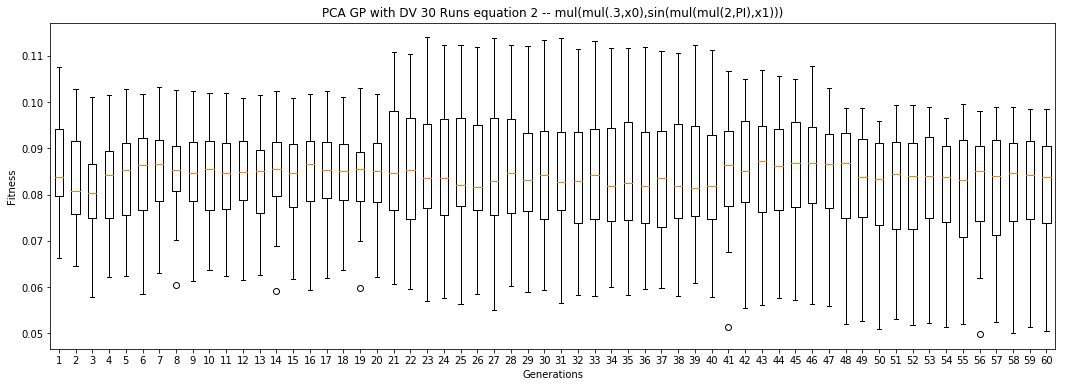

In [23]:
data = [[0.08185931420061601, 0.10304312990316597, 0.09746331006815878, 0.0662605438972988, 0.07433919619475983, 0.09875062720277457, 0.10015101589913485, 0.09084310968335052, 0.07533148123605982, 0.08198473830989089, 0.08847757137545996, 0.08247725624327489, 0.09520642769132986, 0.08265457705375673, 0.08512421963337752, 0.09736090313232557, 0.0887590636497679, 0.10760554190047397, 0.0815478816870011, 0.0885614956467724, 0.09017373805013389, 0.07828904226606824, 0.07473432199749103, 0.08037368710670385, 0.1050463322110771, 0.07967614236427847, 0.07969671377924409, 0.07843644229452328, 0.07261554733643535, 0.09008423303828386], [0.08102822185605768, 0.09888215396087531, 0.09517442273490039, 0.06457803376425761, 0.0772892880682818, 0.09202853787082309, 0.0971192663248828, 0.08156297096930656, 0.06876213629893968, 0.07550853255890565, 0.08788169191529767, 0.07952477441508987, 0.09186708028521211, 0.07895962341090902, 0.08037753475320143, 0.09905204353565872, 0.09093425544472883, 0.10289125792374335, 0.07811406913200086, 0.08594511313862127, 0.08208265881061017, 0.07707533945829594, 0.07045613592028623, 0.07519243661104433, 0.099023857632919, 0.06694088365823779, 0.07289521421250372, 0.085034078076045, 0.07420351929684839, 0.07816026222457972], [0.0771993770757544, 0.09996059228661311, 0.09141565982216232, 0.05794748089451115, 0.07925777170021124, 0.09228488361584912, 0.09619404919369927, 0.07951745148265077, 0.07009683233583802, 0.073907045435792, 0.08273537036200954, 0.07632078603584665, 0.08831382720743257, 0.0809793501747027, 0.07971537366873771, 0.08351306616680557, 0.08626868073914337, 0.09674064207514949, 0.07980137479117107, 0.0866637756531614, 0.08240126010598578, 0.07554313312755617, 0.07205755922151567, 0.07409494073608856, 0.10108478467114894, 0.07469114466000207, 0.07368599129297008, 0.08335279802919504, 0.06880360405785721, 0.08346381035708093], [0.08680144855361892, 0.0979196352236115, 0.09380062831001648, 0.06215652424000045, 0.08342662498319611, 0.08726944909574735, 0.09604963452917357, 0.08690759157380282, 0.07249797662345078, 0.06892164608000008, 0.08667920738010669, 0.07668456349276415, 0.09235236981046639, 0.08021782952354778, 0.07960210951389304, 0.09948161214629486, 0.09002616230611145, 0.10148278635873528, 0.07598494904998122, 0.08716547941512837, 0.08214627431023484, 0.07513280632412235, 0.06989440734196228, 0.07488975935291028, 0.09918007739402253, 0.07278660641995792, 0.07156634222568398, 0.0851456114407002, 0.07246545834878942, 0.0858387763387881], [0.08539237840800612, 0.09579815656908876, 0.09081452773789095, 0.06248486686687075, 0.08569383242544298, 0.09189401473768127, 0.09481009104514938, 0.08538793079654715, 0.07284526113944494, 0.07499476064963154, 0.0875000048235638, 0.0811545509707424, 0.09311049520507289, 0.0814540478226146, 0.07880010994557132, 0.09913061282390484, 0.09118476353220926, 0.10281972093807511, 0.07658357564277363, 0.08618111260923632, 0.08459580958516323, 0.07548084616997845, 0.07447207194352758, 0.0746015793857877, 0.09575646647113817, 0.07556474813426603, 0.07490611840036915, 0.08812886766576174, 0.07139689495150096, 0.08767483476618125], [0.08562042680721821, 0.09915985411879015, 0.09276198009323644, 0.05839963139810005, 0.08349086085953218, 0.09199014716880116, 0.09225068818471642, 0.09131173626102952, 0.07274296451805055, 0.07893806143524677, 0.09261066372264457, 0.08749146599512428, 0.09285669004518524, 0.08088040768275843, 0.08052625127676907, 0.10165983101406048, 0.08713593521845366, 0.10075773746328975, 0.07890209623977837, 0.08566653047903718, 0.08730676701740434, 0.07286580931607514, 0.07272940906599969, 0.07586484080519863, 0.09847419010580288, 0.0728936724564479, 0.07291602030421089, 0.09085878318600002, 0.06932246020977409, 0.08809349299944784], [0.08609328744314831, 0.10224563951899551, 0.09096763302192741, 0.06309308429588806, 0.08349130863878902, 0.09279837152712997, 0.09376609830115129, 0.09196582319687664, 0.07906227421145337, 0.07841980102616608, 0.09008173849815443, 0.08635988024482671, 0.09255729718441, 0.08032032851818849, 0.0807245041641152, 0.10026822414332279, 0.08699410741915752, 0.10326477432113525, 0.07989646367770466, 0.08700630132176963, 0.08730300090271177, 0.07542467725225939, 0.073510207450895, 0.07632899748287775, 0.1026012203613683, 0.07195545889545442, 0.0720634589102277, 0.08810326662274341, 0.0710607965691908, 0.08968665720784055], [0.08263093573135229, 0.09829161411605686, 0.08946668880976774, 0.060359857248195516, 0.08530094675613606, 0.09065882409344689, 0.09269219371574776, 0.09245618839729007, 0.08170833625164027, 0.08248521026806076, 0.09165516430453997, 0.08521254859847674, 0.08809802429343064, 0.08196504809184092, 0.08212133107460445, 0.0965031830261362, 0.08713507302236072, 0.10108061233081021, 0.0803921338403396, 0.08746437599004714, 0.085101031478654, 0.07313398045279076, 0.0702508166286373, 0.07607769445998298, 0.10262937797046695, 0.07009185283675406, 0.07429250266302669, 0.0880754872182919, 0.07015062613297823, 0.09043892694271417], [0.08505599583558328, 0.10074388803537779, 0.09032585654458283, 0.06120007917737432, 0.08453562310220458, 0.09601997440323455, 0.09368044791766127, 0.08844894564598932, 0.0857857802756427, 0.07937093944854884, 0.09483705354761879, 0.08323492308145303, 0.09184220279245373, 0.07990866353087883, 0.08216748309364169, 0.09918790404271727, 0.08907247045256511, 0.10232236730723739, 0.0784882443494082, 0.08359659846173134, 0.08467076251221295, 0.07518284401142676, 0.07177523329671806, 0.07568817811510778, 0.10187516195567473, 0.07269901657220508, 0.0739652617875503, 0.08208843615370193, 0.07197132405985344, 0.08861118049307475], [0.08661835846372762, 0.10128744586270286, 0.09182601017767228, 0.06371142640409766, 0.08355089166167923, 0.09416714334678115, 0.09178091767284655, 0.09039095742798647, 0.08330536795800653, 0.07665755117583034, 0.09140622713382979, 0.08281143343531047, 0.09283659942759538, 0.07951657536864226, 0.08162393481827794, 0.0997624996892837, 0.08761499986833401, 0.1019157105965666, 0.07695820667498736, 0.0843899188136185, 0.08959617927096157, 0.07558804601476081, 0.07136200851242876, 0.07611975238967078, 0.10107017007205249, 0.07255847452868415, 0.07398437742822533, 0.08968532906844111, 0.07090621628360319, 0.08929192401657043], [0.08208361871876721, 0.0971198481131568, 0.08795582855568135, 0.06229515974693337, 0.08361594012941782, 0.09643493297982393, 0.09358921378843779, 0.08921331855643495, 0.07356283863049264, 0.08086192301110727, 0.09123634832790967, 0.08372927915765443, 0.09121195423903201, 0.07832657304181251, 0.08088007038734919, 0.09784668026604387, 0.08677641977809752, 0.10061068303924176, 0.07823412938658686, 0.08552689704051873, 0.08697367595231596, 0.07339390866723204, 0.07159942090555321, 0.07635274332302502, 0.10193050305027324, 0.07131939111208946, 0.07407453264852143, 0.085944219809528, 0.06810410518486217, 0.09082916155728295], [0.08297545989942141, 0.10096626254569593, 0.08962892253088846, 0.06161849771801421, 0.08028495549635208, 0.09540983902355853, 0.09181469463585813, 0.09357375575329235, 0.08431958239856682, 0.07852331865308787, 0.09210048970992485, 0.08565597849321721, 0.09054874810587661, 0.08029715303112424, 0.07990069507881091, 0.09579109815980955, 0.08876258185876705, 0.1007914954391363, 0.07937599667078105, 0.08537834836964925, 0.08542388389836415, 0.07276905997028825, 0.07200300333107247, 0.0751009204084927, 0.10026147118592493, 0.07267939849667855, 0.07256900818974238, 0.08394185950485668, 0.06994892366422818, 0.08669148153803169], [0.08567135820021934, 0.09749162287080775, 0.08896740347052874, 0.06257311269926974, 0.08372150781125413, 0.09329304825011585, 0.08816722412583083, 0.09139289742046931, 0.07817288714186657, 0.0760100647158966, 0.08952154938146815, 0.08489348162421646, 0.09195802826522208, 0.0802292929736729, 0.08263016547117935, 0.0990819992003524, 0.08813282991309127, 0.09813765189076405, 0.07624097065232878, 0.08518032188706336, 0.0849510494676223, 0.0730288225904591, 0.07091830730015405, 0.0741378140152825, 0.10147186667652147, 0.07389483066423508, 0.07270885673133645, 0.08845495633035652, 0.06748788214784938, 0.08981879715557074], [0.08618507986911327, 0.09909364983851716, 0.09139714704951582, 0.05911719419847377, 0.0841155583903877, 0.09841838142985332, 0.09400359182869586, 0.09045342127449413, 0.08295952667047385, 0.07889041127743128, 0.09250365197801474, 0.08480105075006888, 0.08693752291220713, 0.08113926921725662, 0.08101545764535296, 0.09957414825871742, 0.0848942411181344, 0.10080299485983113, 0.08144675924390016, 0.0876411677577849, 0.08645547046146015, 0.07360984184915714, 0.06891956251319425, 0.079108572541102, 0.1024941104713421, 0.07131939111208946, 0.0704208635480163, 0.09126800507841358, 0.07076577160432891, 0.09027260186715244], [0.08459248749788967, 0.09950049561281478, 0.09051063166638176, 0.061759467288767085, 0.08182643280448039, 0.09377490526158322, 0.09078145138701414, 0.0906697550773156, 0.08475873484598442, 0.07706302330773156, 0.09188774596839262, 0.08221044764797948, 0.09270971373447597, 0.08055748126771552, 0.0816105403815426, 0.09973321426820354, 0.08771329546249201, 0.10077800118320489, 0.07809367007548677, 0.08777012347734502, 0.08458541929580059, 0.07510321605021891, 0.07285443975745638, 0.07436989208203233, 0.1005917684854759, 0.07434888567254481, 0.07185885696836304, 0.08731639351757339, 0.06874315026958142, 0.09112987896981564], [0.08687531508470547, 0.09936958460460676, 0.09274117327038196, 0.05933788442239802, 0.08308804440350448, 0.0945310367726012, 0.09223526869563584, 0.09231291965761013, 0.08205874963227394, 0.07838847972657258, 0.08944064399821527, 0.08314500135180236, 0.09003553748995022, 0.07951657536864226, 0.07956105340153329, 0.09844603678310089, 0.08814887016303848, 0.10025001943995801, 0.08045527830699108, 0.08770072134637048, 0.0864445033583975, 0.07151147576986354, 0.07342117014149092, 0.0736224227001371, 0.10177147423324732, 0.0738014367567881, 0.0723394623458374, 0.08682606046421207, 0.07111296893749111, 0.08986534929607498], [0.0869812187440572, 0.0958596777671013, 0.08933015861296917, 0.062034645302805384, 0.08537115635413965, 0.09256072884703301, 0.09407518084157608, 0.09166456255766743, 0.08111415102206648, 0.07665755117583034, 0.09070257855824672, 0.08271532781551859, 0.09199620810434077, 0.07948715950460501, 0.07922343878123025, 0.0995430637375337, 0.08670536590610875, 0.10115540225521585, 0.07954233699056695, 0.0850994908242157, 0.08464414699856986, 0.0733312163920445, 0.06985037598317043, 0.07914795372491151, 0.10230651648721749, 0.06963382397010592, 0.07469783646694128, 0.0878501422869032, 0.06901765870739413, 0.08905651089635848], [0.08534548977044122, 0.0976094528070186, 0.09096369518909392, 0.06365134442224193, 0.08471899746941243, 0.09862272771654744, 0.090857873052239, 0.09284016343262079, 0.08265070082000434, 0.08180262391279178, 0.09200340656545075, 0.08479894245267745, 0.09083067832472683, 0.07827601206396721, 0.08030772788600378, 0.09895188806810014, 0.08678434858446912, 0.10108862562059052, 0.08050839045443342, 0.08483943664440756, 0.08730738453095868, 0.07472582014863186, 0.07026070661844856, 0.07466644294939499, 0.09687987630499209, 0.06982148028536882, 0.07308599485205042, 0.08711288780607822, 0.07152256734813935, 0.0900827948411106], [0.08381567395895191, 0.09706512072088375, 0.08781262879715993, 0.059869111045624854, 0.08426719272773203, 0.10137599644844868, 0.08976396871276783, 0.08903723015014951, 0.0838395694387439, 0.0797676135763072, 0.08926389110073006, 0.0856905345723891, 0.090007210518415, 0.08135823626479202, 0.08283076123301236, 0.10221580218320891, 0.08636269113933336, 0.10030327204877117, 0.07656228247827847, 0.08527061729612952, 0.08613220331020326, 0.07245368703743361, 0.0698611538533522, 0.07816082900294928, 0.10303673382781084, 0.07257536695184458, 0.07325649711070069, 0.08829588269231563, 0.07244278979271551, 0.08857446345720343], [0.08505599583558328, 0.09643768680411852, 0.09090746943559329, 0.06223955092614987, 0.0826463962780575, 0.1008369034639436, 0.09009764442332914, 0.0911842348524587, 0.07836735494084435, 0.07849408850221315, 0.09212803774287329, 0.08329568195041756, 0.09129101928264861, 0.07959301012961661, 0.08216071147517869, 0.10185268759297911, 0.08684845450384847, 0.09947414321141325, 0.07891606698805433, 0.08705361305563503, 0.08501405492812898, 0.07453088639720479, 0.07136200851242876, 0.07670728181504122, 0.10121789104675032, 0.07411481097470773, 0.07217774771093605, 0.085944219809528, 0.07019308401425156, 0.09083934965178049], [0.10305022420046, 0.09694356095887653, 0.07582279812731363, 0.0813863709579315, 0.11017687803563264, 0.06444226593274262, 0.09802147279921423, 0.08352895733374842, 0.10446494728103738, 0.0831316998780911, 0.10308316952109157, 0.09590979779355638, 0.07814428698469914, 0.1048687018227697, 0.06669857491174519, 0.08569828417142286, 0.07870357748241087, 0.06724248075645928, 0.08874267413829183, 0.093095040532682, 0.08259383170454404, 0.07529146488553105, 0.07615091657091264, 0.11055504274825977, 0.07861789031771309, 0.0647139032550823, 0.11082194879244092, 0.09397613072333556, 0.060610405353930724, 0.09815459931454734], [0.10281570035332287, 0.09590059402586117, 0.07218441689369495, 0.08102659031146531, 0.11040067718512295, 0.0655325117224291, 0.0951454868845383, 0.08210940296737952, 0.10889536747921763, 0.0744743553850367, 0.10188235624520253, 0.09218917340714844, 0.07891773144034, 0.10517977665719282, 0.06220107572001902, 0.08702900543548266, 0.07715284754720339, 0.06678157181299166, 0.08667242188362091, 0.09101811939245374, 0.07589083538360944, 0.07337773170361005, 0.0755180187863673, 0.10989648434678882, 0.08396899879980323, 0.0650241678324679, 0.10777865367108812, 0.09123995105578525, 0.05968298989562483, 0.09673177021238469], [0.10112114718903831, 0.09378824351459597, 0.07176209599378287, 0.07898042892125366, 0.10958848492259507, 0.05829109241789822, 0.09332182114946536, 0.07969562012002292, 0.09554648710737752, 0.08111012757761998, 0.1024154427031309, 0.09468523101170885, 0.07831214986955616, 0.10048275141589179, 0.06543437288556654, 0.0854279118352931, 0.07800659225897172, 0.0668724602043324, 0.08813526860078749, 0.09361574047882612, 0.08132374977458828, 0.07650298315262204, 0.0768653428657122, 0.10666176713874716, 0.08182644316942213, 0.06669404487701429, 0.11397653497187024, 0.09199385786561279, 0.057069765858382776, 0.09785244241609545], [0.10412130974991678, 0.0867562817451212, 0.07449104758801989, 0.07879182126580082, 0.11228403875870867, 0.060397307698441746, 0.08956475518902744, 0.07487094455385722, 0.09940480973106568, 0.08268412409922016, 0.10164272496046949, 0.09629392797885081, 0.0797604544848966, 0.0978502866602483, 0.06579740314479587, 0.08449635417121616, 0.07551047068027755, 0.06416933700467178, 0.08429952301656059, 0.0939915064153019, 0.07987607075698556, 0.07593662548217643, 0.07619905729577442, 0.10194507321536074, 0.08146954940798443, 0.06753578023002015, 0.11069000828231497, 0.09095911447815591, 0.057660964947369484, 0.09626806992481686], [0.1033970957800842, 0.08857041531989929, 0.075363476674602, 0.07933871357906826, 0.11090410094223914, 0.0562808347845977, 0.08958613500562716, 0.08147156338227966, 0.10675794668162503, 0.08149900272555832, 0.1019881493107038, 0.09755704057202635, 0.07949145833372574, 0.09681096468524565, 0.0628494406708609, 0.08795698449682846, 0.07964305510173803, 0.06590140406671313, 0.08248420289557587, 0.09126811013460864, 0.08039677382832348, 0.0768762611517186, 0.0732594884767095, 0.10781254914177525, 0.08070384753124199, 0.06688378895549842, 0.11224487527091997, 0.08957623904218735, 0.06109624572504894, 0.09623443495177225], [0.102090655406824, 0.09009760226689184, 0.07282043454359169, 0.08005869644481807, 0.11184078439036406, 0.058569344218671694, 0.09138321923636947, 0.08091055795970786, 0.1062871359315679, 0.07887275858550415, 0.10094538581537114, 0.0950441905156543, 0.07847584344780166, 0.09482760896862974, 0.0659156381119583, 0.08694405919418295, 0.07906145728213791, 0.06533737264896462, 0.07964575151069181, 0.09258697766630304, 0.07957516831720321, 0.07597974368832154, 0.07516345780814906, 0.10505018744136531, 0.08223536494475753, 0.06544320992434442, 0.1094531473295142, 0.09239618696465718, 0.05974530440085303, 0.09679563267547832], [0.10146557463273798, 0.09163431217209825, 0.07351129147087751, 0.08022267640616876, 0.11124334722946452, 0.05514019034859335, 0.09099326660389706, 0.08133624398466827, 0.1077370332483624, 0.0806120424106899, 0.10327913192010955, 0.09718911518580839, 0.08140509216047254, 0.09706200715156817, 0.06266769558506721, 0.08457865245069764, 0.07791613596809371, 0.06624853639293884, 0.08665621913435946, 0.09407384294796245, 0.08012244930354259, 0.07216474248226896, 0.07492100687005789, 0.1057280064808408, 0.078818711546565, 0.06773456371093114, 0.11395250381686403, 0.09349842931459938, 0.0597331248575847, 0.09518200905028212], [0.10368558811930254, 0.09014704150065318, 0.07068726969385516, 0.08070640603347845, 0.1095357147629947, 0.06017000064702385, 0.0901474996423321, 0.08179155192495233, 0.10359188848324037, 0.07961786675136823, 0.10198716190564548, 0.09710575374249106, 0.07900836656447956, 0.09803445167093881, 0.06473672249516063, 0.08957873701255589, 0.0791733868435717, 0.06516729990435675, 0.08619177375547832, 0.09432287634359454, 0.08165096406045914, 0.07508328016701668, 0.07182053270442706, 0.10429327183360924, 0.08321160769654577, 0.06576340554865696, 0.11233796310674979, 0.09329833463510015, 0.060475184710130275, 0.09280088975922415], [0.10160784334543405, 0.0870716234521604, 0.0746155013566967, 0.08132247924350906, 0.10995033447714533, 0.0603947184859913, 0.09000331245980514, 0.08037984269695711, 0.10273929676161395, 0.08237334678151842, 0.10422778950595249, 0.09399163733479622, 0.07958129445985897, 0.09602020071778435, 0.06649695638964843, 0.08842133040665964, 0.0809181962469881, 0.06474411794598534, 0.08408892983111407, 0.09142811023224022, 0.082175586465082, 0.07577491935825682, 0.07312934043076813, 0.10323448907025295, 0.07842675068904928, 0.06691210689250288, 0.11207230150658216, 0.0913498562283105, 0.05895194001401549, 0.0904065163655093], [0.1048482634010129, 0.08863949808983068, 0.07124518827401659, 0.07959348258729729, 0.1109494531573633, 0.05993858668945108, 0.09063721630952835, 0.07558413865308355, 0.10542500069001513, 0.07886523582865346, 0.10491465777278007, 0.09420719085635477, 0.07702652290949004, 0.09779180078029376, 0.06125157501677773, 0.08701568906513937, 0.07754328565649787, 0.06606329670854565, 0.08561589989340944, 0.09120246264137738, 0.08147470908061148, 0.074460385573018, 0.07261288015951665, 0.10403874237077583, 0.08287306327913618, 0.06620036828006876, 0.11350897736742065, 0.09204719739608741, 0.05930455181593445, 0.09248011958289044], [0.10225200357353849, 0.08761590391700712, 0.07269982365843244, 0.076894833264393, 0.11156113244552326, 0.05649359493855391, 0.09087083230073296, 0.08047197091110646, 0.1025362231311549, 0.07732766375157316, 0.10372940030444715, 0.09257243646225918, 0.07860021544763726, 0.09676871443900958, 0.0625722778791458, 0.0885266619563161, 0.07943611739694557, 0.0631631236363959, 0.08264027505825336, 0.09297150495532037, 0.08025293929403639, 0.07668266296320939, 0.07254690515068035, 0.10266227874775177, 0.0826876816641501, 0.064420690614405, 0.11395733017303487, 0.09294303230573345, 0.05996315018914364, 0.09383557695920104], [0.10014807938836205, 0.08327165953183191, 0.07230340175351088, 0.08151684827023795, 0.11003774200518784, 0.058196509214240195, 0.09127957389973747, 0.06945350954563373, 0.09887141572438532, 0.08268412409922016, 0.10270721992270389, 0.0931816934548455, 0.07888970456859884, 0.09867366970766302, 0.06424573583478896, 0.08588268068004089, 0.07582773031825531, 0.06372053003655632, 0.08607824439658104, 0.092884061797727, 0.08238781886885731, 0.07406215235204933, 0.07381453055294267, 0.10313048489470995, 0.0763863786879757, 0.0670218072298081, 0.11158578813362745, 0.09355527656079989, 0.059210341112242694, 0.09129841108417075], [0.10183401995779498, 0.08475733568901385, 0.07126150097411149, 0.08134449520545041, 0.11278142265517409, 0.057963071241977936, 0.09036723202480851, 0.07386213093358701, 0.09681547158572569, 0.07878321687353664, 0.10464757186018228, 0.09441231418607862, 0.08100921246251551, 0.09695676920134276, 0.06712781302945899, 0.08795698449682846, 0.07691981344108366, 0.06537025500872479, 0.08487156316757644, 0.09361165509569541, 0.08044048370964384, 0.07805975140842072, 0.07385719318379841, 0.10388442308402587, 0.08367137005513038, 0.06681792988212348, 0.11324061123802835, 0.09318485085410953, 0.06002417770529503, 0.09207676055850328], [0.09993722919706233, 0.0825864824951556, 0.073600098310508, 0.08125396254621678, 0.11096309934270453, 0.06054869435605665, 0.09033477559906977, 0.07165040472878434, 0.09642812484191855, 0.08098719985842551, 0.09909131933153424, 0.09392151173103336, 0.07984924074736942, 0.09593861582895385, 0.06477611005897736, 0.0897643566804982, 0.07706404753084188, 0.06623022932818148, 0.08535466972659495, 0.09468398177288304, 0.07817909949601383, 0.07620962438520647, 0.073082708578142, 0.10315495780575631, 0.08005172015064493, 0.06480481652847593, 0.11163677538346686, 0.09233782928340187, 0.05992184399588477, 0.09272115214430804], [0.10091942800368825, 0.08122585849384295, 0.07388976986823957, 0.07833630468209477, 0.11049560412046083, 0.05849747096793748, 0.0898811736038583, 0.0738970255638338, 0.0957532746101793, 0.07821521966437518, 0.10084635791749415, 0.09528931823069502, 0.07868114403214636, 0.09959976561826851, 0.06526035478995164, 0.08584716288365107, 0.07768408369015065, 0.06659875230890352, 0.08372349581986457, 0.09643206090400097, 0.08013304385693695, 0.07669980446269545, 0.07358563306635738, 0.1052036096203043, 0.08465843385146868, 0.06671351969837334, 0.11164164216546801, 0.09361527979290361, 0.05827282960690115, 0.09338872734150576], [0.10171560748432293, 0.08188909231153299, 0.07035811994166893, 0.07862476368173253, 0.11197350980292972, 0.05967296706878021, 0.08938520470484483, 0.0728031016281024, 0.09339475864411992, 0.08147354004459227, 0.09875503152748473, 0.09345367729113702, 0.07941402154865115, 0.09708547552069081, 0.06449944296361083, 0.08645500887900548, 0.07776695765587033, 0.06469118994447741, 0.08606949352413663, 0.0917614960926831, 0.08128927823563929, 0.07736474391139847, 0.07018761860891175, 0.10562576149463039, 0.08203064305590474, 0.06534103142061239, 0.11158386753455302, 0.09340511605652511, 0.059692414709729275, 0.09417762050093761], [0.10221822145107365, 0.08138442063179319, 0.07156338893458239, 0.08232362256631601, 0.10917575032984153, 0.06010195360726437, 0.08972706205758527, 0.0740820812449013, 0.09490131761105382, 0.08263683073650646, 0.10192708524287643, 0.09391735167532479, 0.08095263025710281, 0.09849151426668462, 0.06450219782450553, 0.0872558659806847, 0.07808010526699667, 0.0665160522919478, 0.08543544149502365, 0.09304401473014833, 0.08318645777974007, 0.07274377641327025, 0.0702277381377771, 0.10520440466146938, 0.08385846532002578, 0.06661869756367483, 0.11102784191764048, 0.09240001280207807, 0.05981172433875523, 0.09357799519020356], [0.10247017832876759, 0.08335116327511144, 0.07480250230650437, 0.07826696803269285, 0.11069175196715478, 0.057963071241977936, 0.09136158647563326, 0.07395957751532066, 0.09618081934487262, 0.07512657710416214, 0.10345320543471244, 0.0949992967173883, 0.07729861224887681, 0.09931643049904365, 0.06376526101339648, 0.08625540695238437, 0.07861752043812059, 0.06586493919157713, 0.08249429917378003, 0.09341387560314895, 0.08039677382832348, 0.07655714917756254, 0.07405202492200012, 0.1027413849760615, 0.08107983519797711, 0.06871796203955023, 0.10786602917042815, 0.09327417279755568, 0.05972370004348025, 0.09541446128215199], [0.09991657969278822, 0.08252105849685479, 0.07372381557603422, 0.08052587448180024, 0.10963254926108656, 0.06078168220423256, 0.09035105604987873, 0.07500275858450939, 0.0972508627791734, 0.07874051572172813, 0.1044179007577021, 0.09356669409790379, 0.07888970456859884, 0.09529738822251753, 0.06603379849906275, 0.08814666658986524, 0.07821047745338798, 0.06623196194777847, 0.08465529607932473, 0.09488642101950187, 0.08044407931664385, 0.07622092033977254, 0.07261348179804046, 0.10138540514088618, 0.07911694982488217, 0.06555798651454661, 0.11237780922873777, 0.09151099587299691, 0.06112256683208633, 0.09468825917669212], [0.10062729591585251, 0.08177015841909481, 0.07390364715263703, 0.077075530261057, 0.11065224006371246, 0.0605195170070025, 0.08873486625802414, 0.072430502589741, 0.09660878326330101, 0.08004187593740436, 0.10443558857348507, 0.09257658295190367, 0.07984924074736942, 0.09761310397521113, 0.06532529962438781, 0.08747819395236212, 0.07829734581004259, 0.06600750932638434, 0.08439227916757502, 0.0928767559549287, 0.08028900147437554, 0.07777750639369015, 0.07321412120046514, 0.10459936940101115, 0.08212635312601486, 0.06511249818441947, 0.1113334338214565, 0.0914988792929951, 0.05774887626549712, 0.0911980259727439], [0.0785497040417413, 0.09904031082881676, 0.08052087766407667, 0.0699370871153197, 0.09148352745109276, 0.08514309900980298, 0.0845662933185266, 0.09853367311922209, 0.07141940318626783, 0.08775215511774971, 0.0687769295585974, 0.07601824113982082, 0.09028903439068367, 0.106436227845706, 0.0771409869647953, 0.09752351384771078, 0.0904444535660805, 0.08001828962414037, 0.051415336637843354, 0.10680085078842068, 0.0734904424320797, 0.09148614588344627, 0.08438341104477039, 0.067616401259115, 0.09461193184491723, 0.09588191466407686, 0.08037591023699603, 0.10271004449918125, 0.08801840465414086, 0.08914334435611196], [0.07836721714307324, 0.10393211962388656, 0.07720036740201909, 0.07249455987152756, 0.0893077103822035, 0.08371816317185964, 0.08342322097391194, 0.09683513997465397, 0.084103990130435, 0.0852699387821381, 0.07003303016791551, 0.07297948432395779, 0.09103747892467591, 0.10493638829505877, 0.07859367243949275, 0.10152765675163293, 0.0849388429552863, 0.08131907547676312, 0.05551956947708558, 0.09945642115975545, 0.07428027162879013, 0.09369158498079261, 0.08590157208261068, 0.06960709457598026, 0.09662651665518666, 0.09733388902631918, 0.08228994319337761, 0.10059606075097022, 0.08732323044315261, 0.09214067472424546], [0.08046793855826079, 0.1026702269783913, 0.07436689324115457, 0.07054590924458846, 0.08935410408092688, 0.08643302101848259, 0.08221895299214209, 0.09591407380806655, 0.07622622345745736, 0.08815620465996296, 0.07194346528111493, 0.07565325286526221, 0.09352100759701933, 0.10691959706794721, 0.07630303104583408, 0.09681396908791526, 0.0883697979521729, 0.08160613286281053, 0.05610022253939771, 0.10503925137977098, 0.07088577580768601, 0.08929194843602756, 0.08615565901829741, 0.06695024187935351, 0.09843729897894213, 0.09564446067231962, 0.07817403400919182, 0.09521481906956333, 0.08941433177282933, 0.09140609493132969], [0.0821016806429829, 0.10428145717102118, 0.07703880893172349, 0.07136805295382426, 0.09096633741101488, 0.08484398467197887, 0.0812405479355366, 0.0990990220150212, 0.08204436177809513, 0.08835128254175613, 0.07500962824678588, 0.07088436030358083, 0.09230831249680901, 0.09459945211845337, 0.07525425576802812, 0.10328066990813238, 0.08571992891980673, 0.08214952939693675, 0.05764953119642716, 0.10416694207345395, 0.07356095970709323, 0.09317340025221608, 0.08667056530715248, 0.06867130444180718, 0.09645968234972667, 0.09747238081285813, 0.07661482848873603, 0.10574619713046296, 0.08889188089744725, 0.09307882748503647], [0.07916943088221423, 0.10308584960278637, 0.07663501068486406, 0.07145742633725749, 0.08926008650819153, 0.08436670801348452, 0.08307642663202551, 0.09975064226875172, 0.07831772657657902, 0.0884968006489214, 0.07946024605299812, 0.07709639836298993, 0.09384275761865017, 0.09620348785290772, 0.07614478517814115, 0.09848806286641272, 0.08824319588327212, 0.07987110506276503, 0.057282688503238775, 0.10495073094768795, 0.07459785103731906, 0.09055223369927973, 0.08723038512911602, 0.06908544910116819, 0.09823167092162792, 0.09720870343812892, 0.07502109618393348, 0.09929066557336713, 0.08646848092117218, 0.09184881043271184], [0.08293264044680303, 0.10000428653075255, 0.07505750271730917, 0.07174973824755146, 0.0913465012341715, 0.08440272603631975, 0.08385597128570527, 0.09896097427064565, 0.07734512174226392, 0.08708754678834353, 0.08079450687304957, 0.07597370839633591, 0.09258827370808073, 0.10770642166671308, 0.07818478765347764, 0.09487621138272861, 0.08770377915998881, 0.07955570491895768, 0.05634221459281722, 0.09883246629209128, 0.06914761341347703, 0.09372854317728081, 0.08653620250229349, 0.06657463364918624, 0.09875378902421206, 0.09610299513303183, 0.07834223138153834, 0.1013880404818112, 0.08951925670416037, 0.09119915873524775], [0.07917958007252561, 0.09296244153130252, 0.07666148664363025, 0.07012612545484134, 0.08994912441202513, 0.08441085119768196, 0.08209933106499939, 0.09832495319347156, 0.07198421269524956, 0.0880462342463495, 0.07469300799254985, 0.07140601538801879, 0.0946863236219843, 0.10072274196365871, 0.07877493979159945, 0.09189361197129124, 0.08641920866038376, 0.08098136485792999, 0.05594454677311157, 0.10314163488437658, 0.0714880839088772, 0.09308161395998393, 0.08683611937239706, 0.06988236111097035, 0.09605525743717773, 0.09667225176453369, 0.08120228654313986, 0.10078082361063515, 0.08741970850187551, 0.09156129708621157], [0.08011428177642949, 0.09483931307012258, 0.07340682196977144, 0.06863731444530709, 0.08943694148145835, 0.08462385538344828, 0.08324665268229474, 0.09879911871685657, 0.07142695739170882, 0.08757237200764188, 0.07348634848779859, 0.07322306630187704, 0.09206918730247009, 0.09499458922069438, 0.07943224552746449, 0.09389650977303268, 0.08589820662261373, 0.08110199122268363, 0.05192867799398176, 0.09735850690529557, 0.06996230975073808, 0.09358893969731753, 0.0876747950505492, 0.06500535157369997, 0.09248114301706173, 0.09564446067231962, 0.07964411908997193, 0.09765648641213065, 0.08773345679494665, 0.09156198461875713], [0.07987863562528015, 0.09104802609295738, 0.07222106477945234, 0.06694504845920785, 0.09047364964385324, 0.08475659460317038, 0.08302915886938471, 0.09868328823314206, 0.0689222326735138, 0.08597688773111115, 0.06843707080744325, 0.07473197925787024, 0.09192805957183794, 0.09223339764960854, 0.07841044217204513, 0.09367140291107098, 0.08132576399017176, 0.07883306293307295, 0.052644707872405876, 0.09813280237162281, 0.06746276944097791, 0.08762093449478295, 0.08165840514195856, 0.06791264888611215, 0.0918768011406221, 0.09298285393777816, 0.07618633977242663, 0.09602705742718244, 0.08893860026928706, 0.09243785034509731], [0.07837517184531131, 0.09237499149192156, 0.07028041946420825, 0.06674287727041606, 0.08954108689196626, 0.07931114838727402, 0.0812405479355366, 0.09590344090235539, 0.07046667245117855, 0.08784346875933069, 0.06906390093283697, 0.07214810847328146, 0.09107818212102134, 0.08988833652864686, 0.07814606671808762, 0.09270635229880102, 0.0801366117986495, 0.0775616365479251, 0.05092329473500783, 0.0935741142522604, 0.06769633046764546, 0.08551789238541424, 0.08672071351708126, 0.062079908234067976, 0.09248114301706173, 0.09370137439214123, 0.08104776932188956, 0.09331327989193594, 0.08567267753437632, 0.09119808329144659], [0.07705149404500242, 0.09225398551463905, 0.07087843823215693, 0.06409516498110106, 0.0905364854203413, 0.08496260584631828, 0.08248373055010269, 0.09934881660716867, 0.07144630191569364, 0.08799877115414206, 0.06866891491770455, 0.06976060040845501, 0.09315869539422766, 0.0909032219081656, 0.07829626437360983, 0.09332382938046371, 0.08083658075853888, 0.07617251051314211, 0.05308932225367334, 0.09320982566145156, 0.0673589414179445, 0.08804809067631321, 0.08406924426871215, 0.0666356529780448, 0.09417449048063285, 0.0916037968970541, 0.07667970336318118, 0.09336545678678981, 0.08668404109325331, 0.09100392252447422], [0.07749063253107848, 0.09208103422151456, 0.07199667493758727, 0.06408514607480373, 0.08791070175789631, 0.08386843982772746, 0.08504963220612241, 0.09928800375703292, 0.0693329876656906, 0.08651467832957967, 0.07073093956500559, 0.069539713277515, 0.09052950733681452, 0.0904160940544049, 0.07655467515823441, 0.09170977257930372, 0.07806419359046085, 0.07453504769906844, 0.051753903172370073, 0.0950886032227996, 0.06682609217437313, 0.08766728405577605, 0.08250599840265592, 0.06653919203585895, 0.09141658415809495, 0.09271505529322539, 0.0795999885121432, 0.0965553634783958, 0.08398783942401782, 0.09365497695828512], [0.07772410349384906, 0.09254115861345596, 0.07121553076946738, 0.06318287095275234, 0.092000890724579, 0.08378521839792594, 0.0842816077694879, 0.09893783759963397, 0.0686302204878788, 0.08458133666181461, 0.07066211090336985, 0.07661162240012981, 0.09505712690399823, 0.08955099636638979, 0.07713228404194543, 0.09329914537300975, 0.07987101748050443, 0.07446366825080888, 0.052211097203627016, 0.09519566814565869, 0.06795648875142854, 0.08771771817749507, 0.08274211688023815, 0.06675049618057288, 0.09353804218441591, 0.09108148775652175, 0.07843179537273547, 0.09527437505143888, 0.0885351764821356, 0.09283832480116014], [0.07862687352202496, 0.09042839741913941, 0.0732906384676996, 0.06401660825391534, 0.08774994739893144, 0.08406555765494055, 0.08275732389224319, 0.09425241133631196, 0.06779218126157499, 0.0870891079856101, 0.06991588786891788, 0.07568903924981242, 0.09403208627660115, 0.09045079858417979, 0.07841044217204513, 0.09376404555504288, 0.08097078288378211, 0.07363971325563393, 0.051368697930608734, 0.09558932966463066, 0.06606227857747103, 0.08931551202932583, 0.08350161872213732, 0.07161448022098618, 0.09433578831139681, 0.08991109858279095, 0.07548095569988547, 0.09661575036604539, 0.08726275486288462, 0.09274893043666002], [0.07664281253896865, 0.09344191813373937, 0.06910569541091184, 0.061606293780060856, 0.08864737457085872, 0.08126427602640625, 0.0814712261350362, 0.09962942178320414, 0.0696167850635087, 0.08795969996611522, 0.06892390433377381, 0.0697597718294164, 0.09374984481273047, 0.09192752850796393, 0.07745867569221392, 0.09261295132752673, 0.08003980547559272, 0.07595678700789726, 0.05208888433391931, 0.09544749237717304, 0.06771236890838712, 0.08519246375492438, 0.0847099555679895, 0.06759904935716143, 0.09352481884171245, 0.0916037968970541, 0.07399469829358846, 0.09793853755614536, 0.08885546725912066, 0.09093994360040843], [0.07654916374315218, 0.09055355247482841, 0.07247323536605872, 0.06187650937353352, 0.08919652507437788, 0.08609354638738026, 0.08197918543744787, 0.09797661302108601, 0.0686121443774682, 0.08471620708036316, 0.06673011892998514, 0.074025475596618, 0.09028903439068367, 0.09107650519978977, 0.07611232414741098, 0.09302206865946995, 0.08053292603807097, 0.07538664917492947, 0.04984913823200908, 0.09458015944715366, 0.06867619930646668, 0.0855284106571898, 0.08767170296688226, 0.06337012539423575, 0.09055222912532361, 0.09221031955278278, 0.07676351180998325, 0.0954121154103185, 0.08718953413260315, 0.09259053641559895], [0.07452951176271858, 0.09289877058717456, 0.07016262665082564, 0.0633800806032663, 0.09017817913128129, 0.08475659460317038, 0.08174072078868529, 0.09885696811577022, 0.0691570223237573, 0.08592838241525036, 0.0685877104468352, 0.06874502341863398, 0.08856693120450662, 0.08981319380588354, 0.07613672126155602, 0.09432958116452984, 0.08172574915789436, 0.07595678700789726, 0.05250179390336308, 0.0948505584314902, 0.06414020946178492, 0.08327966628095847, 0.08473126837483959, 0.061712709312343655, 0.09368849344256948, 0.09354971101395153, 0.08011670827846412, 0.09818062055563288, 0.08636993255163045, 0.09235391728660788], [0.07892075846311461, 0.09504141401663503, 0.07195193905049765, 0.066609716770134, 0.09111386096558147, 0.08411526465851699, 0.08363485029614506, 0.09886228446938433, 0.0698121676486388, 0.08772586916831175, 0.0705141813892296, 0.07457059937385101, 0.0911738679957964, 0.09235199442655152, 0.07529447191444891, 0.09578320128602301, 0.07776424676340479, 0.07502107946705995, 0.050001551093005525, 0.09540827037031879, 0.0667167088696276, 0.08583564568685698, 0.08541003014596818, 0.06519866120917366, 0.08960171037395896, 0.0856375009540689, 0.07412517554142233, 0.0954983098667243, 0.08503348818447702, 0.09177963799220462], [0.07698339510874569, 0.09396534278253753, 0.07010441165584894, 0.06616964956498454, 0.08694760492052785, 0.08500513332393983, 0.0833517799651026, 0.09848762457987253, 0.0709759397382065, 0.09023924136887038, 0.07157036507280752, 0.0746402268819292, 0.0942839950935747, 0.08723720094677379, 0.07554611602684926, 0.09347499148038672, 0.08306958319748607, 0.07525215963414891, 0.05129846615230438, 0.09427364488907025, 0.06522393637773409, 0.08758063720067046, 0.08395537047644626, 0.06648807249184868, 0.09277054787420884, 0.09161225702585471, 0.07943588563169782, 0.09767334307440484, 0.08455834907236255, 0.09123276750834013], [0.07817975011177748, 0.0931030081564005, 0.07352138162118226, 0.0652434457252756, 0.09042152072315988, 0.08622259785699557, 0.08452017034441103, 0.09842537731311865, 0.06846523268674844, 0.08391061772709346, 0.06963638960557897, 0.07324193267725788, 0.09374984481273047, 0.08917234086075315, 0.07613672126155602, 0.09053410224588637, 0.08171413399422571, 0.07443733949174308, 0.05046315907398842, 0.0958612512611196, 0.06725420378312925, 0.08514202963320536, 0.08260657576516736, 0.06747449525807592, 0.09189070470560393, 0.0941248210554577, 0.0782347564830328, 0.09391323276385535, 0.08382270670617437, 0.08876249355418515]]
fig7, ax7 = plt.subplots(figsize=(18, 6))
ax7.set_title("PCA GP with DV 30 Runs equation 2 -- mul(mul(.3,x0),sin(mul(mul(2,PI),x1)))")
plt.ylabel('Fitness')
plt.xlabel('Generations')
ax7.boxplot(data)
plt.show()

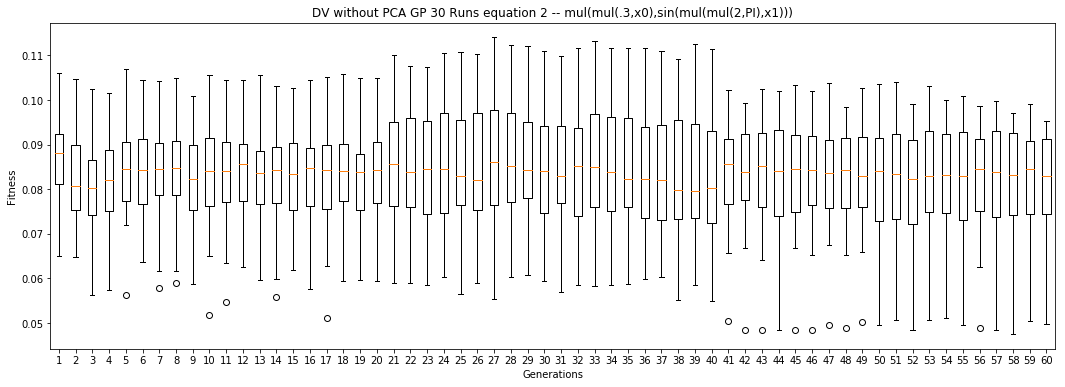

In [24]:
data = [[0.09110031697295355, 0.10335669379998057, 0.09974991288108322, 0.06496373394922138, 0.08557525378426874, 0.09644077000078709, 0.09408705642816304, 0.0913736555923542, 0.07637914956362953, 0.0805423235031206, 0.08988378097436563, 0.09093248987090721, 0.09208446148527111, 0.08716402473466214, 0.08577901878086672, 0.10198340202358404, 0.0887590636497679, 0.10612021905353203, 0.08295974793417403, 0.09245637981314421, 0.08437723813528562, 0.08181791561608281, 0.0737961105275497, 0.07753698946834367, 0.08776133262313018, 0.08079514859532452, 0.08106055552237658, 0.08840976234789633, 0.07418183347904872, 0.09356548405834779], [0.07801232938838083, 0.09874760297883076, 0.09576926861429995, 0.0648110412131575, 0.07955736227035623, 0.0916364710129051, 0.09021021575472718, 0.07673828906237082, 0.07455492292988465, 0.07355310281905396, 0.08426974317863113, 0.08895589307704974, 0.09170402274502917, 0.08173684067215506, 0.06911323616778148, 0.07778906553615221, 0.09057739556734297, 0.10482094694278118, 0.077745291981716, 0.08594511313862127, 0.08207359891020713, 0.07642257932979696, 0.06986128370941626, 0.07519243661104433, 0.09408201750231243, 0.07279373853914801, 0.07551154025485535, 0.0865332484369465, 0.07149680154498851, 0.08532762834525587], [0.07992422573178248, 0.09708080107623548, 0.08654492048654944, 0.05636464509031564, 0.0800677944084866, 0.09228488361584912, 0.09654318960172104, 0.06921774508470563, 0.06779466273408907, 0.07155438671304244, 0.0848665866447593, 0.0812729365640396, 0.08881121810714362, 0.08059750050461094, 0.07064617235930727, 0.07461176942961127, 0.08363674773458676, 0.10237820620257872, 0.08060688508842001, 0.0866637756531614, 0.07958427112056125, 0.07528353361853554, 0.07231505519945108, 0.07409494073608856, 0.10007895011370503, 0.07469114466000207, 0.07349332310244668, 0.08477430591499696, 0.07419760674859334, 0.08734255436599038], [0.08857339455596461, 0.09517702031597425, 0.095040995694556, 0.05749076606191708, 0.08084652830736899, 0.08726944909574735, 0.09627084809946301, 0.0819416129395785, 0.07249797662345078, 0.07259417380666155, 0.08615541920112896, 0.08197526597763478, 0.08891922951108049, 0.08191507479993024, 0.07416804491742648, 0.09694326714789503, 0.0881258722513648, 0.10148278635873528, 0.07628593659228289, 0.08729831692414763, 0.08225932632862214, 0.07540088667913963, 0.0702504676048618, 0.07488975935291028, 0.10118915193356824, 0.07563289698923442, 0.07340530330439465, 0.08434754262139182, 0.07246545834878942, 0.08882826545043337], [0.09186797851810374, 0.09386648606287307, 0.09075591537905053, 0.05635616517712289, 0.08307222283428113, 0.08620036409003341, 0.10203155237313198, 0.09083876499932687, 0.07284526113944494, 0.07527954328754813, 0.09014529316681158, 0.08238083614566781, 0.09004671415135339, 0.0804366705729165, 0.07896760878793933, 0.09231797894397624, 0.08617157568147364, 0.107037875157809, 0.07673406941392447, 0.0848131404944466, 0.0842112548025858, 0.08619550662046417, 0.071874110950091, 0.08181572942740972, 0.0991555166387484, 0.07610574978295902, 0.07222159604626459, 0.08303469020455317, 0.07570429199319374, 0.08829545777525667], [0.0913210910987283, 0.09564743317718802, 0.0920850484771589, 0.06374337055050341, 0.08116989689353431, 0.09133063824206106, 0.09997550117098258, 0.0878515637405784, 0.07107179114239123, 0.07615589061093953, 0.08955119340726875, 0.08383627594259052, 0.09158714504720006, 0.07996208259653965, 0.07013917110325613, 0.09679541981162243, 0.08680126797392046, 0.10454696865163335, 0.07828745344022327, 0.08215585555515242, 0.08572654675214333, 0.08480517197182032, 0.07131141463601604, 0.07928798249441477, 0.09851768659400739, 0.07422030727710588, 0.07270328814174527, 0.08273726852808477, 0.07307828070891259, 0.08652135225441356], [0.08883720214442575, 0.09667363571245506, 0.09063067904590626, 0.0577552765894411, 0.0812605906647253, 0.09684915150982265, 0.09652865285177407, 0.08918427336810125, 0.07926343948470775, 0.07398379680176939, 0.0874480744486509, 0.0845443187864299, 0.09054503408362047, 0.08021305608376283, 0.06162157405084406, 0.09458436213606708, 0.08594458349299623, 0.10431260125668415, 0.07870859274120624, 0.08453754259012476, 0.08319915570215868, 0.07914406507605895, 0.07228562298218114, 0.08347110653127005, 0.10196609415789709, 0.07394106979796661, 0.07149807925707294, 0.08606739854771621, 0.07368197662028214, 0.08996205125651396], [0.09123893477967207, 0.09429322164299893, 0.08938853899798052, 0.06160350213772435, 0.08369483947176631, 0.09527415401030649, 0.0998266425665271, 0.08986248148644049, 0.07703423021945625, 0.07867781296043785, 0.08878214342648279, 0.08341031935406647, 0.08680061787426922, 0.08154540817881809, 0.05896624364034602, 0.09454919334107255, 0.08717416283077523, 0.10486984351915381, 0.07959228125272257, 0.08581851510808233, 0.08165599119146984, 0.07896806646414911, 0.0675327474630576, 0.08113358829385284, 0.10160700207868424, 0.07101891472088533, 0.07418064711128179, 0.0860396191432647, 0.07528611292725386, 0.0915696736224609], [0.08289734477964526, 0.09605241157700968, 0.09024770673279561, 0.0620246035304024, 0.0829295158178348, 0.09617610874869863, 0.10090982822351502, 0.07080830691348754, 0.07563237782031791, 0.07550319439840841, 0.09004939825103071, 0.08211131652871852, 0.0912596530549204, 0.06941372365017193, 0.05868209694545828, 0.08817473125419467, 0.08832017165288589, 0.09959917676485479, 0.07780962165773246, 0.08262936027144227, 0.08414208308350919, 0.07954130189672505, 0.06496025432843915, 0.07907461512774919, 0.10056141306052777, 0.07362607845633634, 0.07339988213439552, 0.08005256807867472, 0.0752536114181725, 0.0899415717142978], [0.09255195110404042, 0.09706218947619186, 0.09172832291293825, 0.06508404976297645, 0.0820226662200954, 0.09757991576160119, 0.09977689488323528, 0.08693078490753536, 0.07646900693632881, 0.07278980612568992, 0.08921182894744834, 0.08100920419090023, 0.09082433632680585, 0.078494776839463, 0.051882512310004326, 0.09556215921075809, 0.0879699090946474, 0.10570494178491019, 0.07627958398331162, 0.08342268062332941, 0.08558822268181901, 0.07882599352430525, 0.06945880135203916, 0.08219680942415468, 0.10043504386858126, 0.07348553641281541, 0.07389916381763606, 0.08832808368508963, 0.07330154963011781, 0.08460448337621271], [0.09055352311000638, 0.09312145564009887, 0.08785814129094732, 0.06354848569124086, 0.08272468952667617, 0.09791467867269533, 0.09997490794876399, 0.09056074510907493, 0.07796857346702393, 0.07699417796096684, 0.08904195014152821, 0.08260567260491992, 0.09057900192672376, 0.07821930060738685, 0.05476552441706293, 0.09521995112100078, 0.08572689585193623, 0.10454264537591623, 0.07686673142425929, 0.08455965885022966, 0.08411266017813897, 0.0772409888297986, 0.07105345912851509, 0.07753536242389547, 0.10129537684680202, 0.07224645299622073, 0.07475315534019716, 0.0839083517345008, 0.07185992568400067, 0.08661109542101571], [0.0904917005410167, 0.09696787007263802, 0.08957031017204804, 0.0626698007402106, 0.0779639915303542, 0.09286590270481977, 0.10006580626597524, 0.09014640181921346, 0.078466913478759, 0.07465557360294743, 0.08854884614019194, 0.08385374924880694, 0.08996619836834328, 0.07973032601743885, 0.0633232589525311, 0.09159075768128393, 0.08842791461423388, 0.10458072662747993, 0.07801875128742958, 0.08627517900464388, 0.08493203402589315, 0.07722347968650949, 0.0721356642457101, 0.08228946539322025, 0.09992401352462986, 0.07397688594737968, 0.07200362853658762, 0.08698195774430435, 0.0737047441633667, 0.0876654285266697], [0.08869920429858347, 0.09506684173123235, 0.08826078401168264, 0.06381675758879855, 0.08191932386761741, 0.09612600225191938, 0.08806241965776304, 0.08840622245034968, 0.07821055796199977, 0.07214231966575617, 0.08484368585184597, 0.08320914204817936, 0.08994576516443255, 0.07920749444449363, 0.05967989072126688, 0.09488165872182679, 0.08779816266855807, 0.10562923000849259, 0.07556234796065306, 0.08421308369677429, 0.08126563499810903, 0.07797703419923686, 0.07035830240427601, 0.07867755764889751, 0.1008755143414461, 0.07613097550095296, 0.0721434770781817, 0.08641908825532932, 0.0712437026469879, 0.08896008862760471], [0.08845875749543589, 0.09509525736545925, 0.09069052759066973, 0.05994171855150185, 0.08250945110601791, 0.09693266630953458, 0.09389878736062807, 0.08835049413739446, 0.07602563163885612, 0.07459843798502983, 0.08390753766858147, 0.08399773987056094, 0.0863549731746738, 0.08011747068807734, 0.05575453308210898, 0.0953738077801918, 0.0845595738736012, 0.10325134813712218, 0.08026403501612586, 0.08664477622292477, 0.08590443736065621, 0.0794439278605155, 0.06837360073615611, 0.08097390976671004, 0.10185898426787089, 0.07224645299622073, 0.0705341065865373, 0.0891277140403109, 0.07254931871234915, 0.0894594953766106], [0.0849569429144378, 0.09437597149915589, 0.09045201930754135, 0.06342223271479665, 0.08022032552011062, 0.09713291045223735, 0.09067664691894634, 0.08856682794021595, 0.07476462792384583, 0.07387390094926687, 0.08596111469622603, 0.08040821840356922, 0.09139565646760175, 0.08020483235072534, 0.061786814774185336, 0.09553287378967792, 0.08594891485470263, 0.10278197546422607, 0.07741504738381104, 0.08680288528705593, 0.08180784371716843, 0.08011459556432593, 0.07197165652405986, 0.08145083416066742, 0.09927801959032895, 0.07389628126153897, 0.07129347731520827, 0.08528052544254619, 0.07249897076871993, 0.08982464717638215], [0.08656856017811926, 0.0937975807980663, 0.09266302345859474, 0.06058152931192684, 0.0814819371191347, 0.0954184847912371, 0.09213046422756804, 0.08953136982883475, 0.07602800046592041, 0.07452073467643215, 0.08535185378466491, 0.0813427721073921, 0.08802327438916069, 0.078494776839463, 0.05772057821167361, 0.09424569630457529, 0.08769967389860839, 0.10438792127640328, 0.07914351523279252, 0.08673348315608141, 0.086947552423777, 0.07720952354419519, 0.06968080458117348, 0.07928410946699976, 0.10061007196834146, 0.07334883234578224, 0.07177408269268265, 0.08411156969750913, 0.07337458550628556, 0.08832168956781472], [0.08671484011049911, 0.09343489662752591, 0.08925200880118195, 0.06285916965583346, 0.0834146573544432, 0.09656036850900249, 0.09397037637350829, 0.08888301272889206, 0.074666987029026, 0.07278980612568992, 0.08458864002401582, 0.08159172126278408, 0.09069880168517934, 0.07937988707017937, 0.051071914865530706, 0.09691633459249063, 0.08708555534320365, 0.1051737683787099, 0.07818509160721548, 0.08481087532560234, 0.08514719606394933, 0.07778563610826573, 0.06930441420613231, 0.08101329095051954, 0.10155095423960805, 0.07056088585423718, 0.07481107950546227, 0.08381571070272936, 0.06968886903052848, 0.0901872575761052], [0.08503873486385499, 0.09361106033396066, 0.09025707573024781, 0.06502250002777779, 0.08378903736087046, 0.09796187692272829, 0.09041746342260404, 0.090287146968019, 0.07763347455321998, 0.07567791746520021, 0.08427722188989081, 0.08299671320826721, 0.0895332719055654, 0.07725421353478794, 0.05939599892973503, 0.09475154758957452, 0.08573482465830787, 0.1057334760359924, 0.07915114507108197, 0.08387219845411849, 0.08513602718833119, 0.07866637507822438, 0.06945641827227671, 0.07809043405116739, 0.0969233727931966, 0.06936887587436297, 0.07252061519889567, 0.08507701973105102, 0.07185817250970652, 0.08875086385872083], [0.0835089190523657, 0.09464033958130837, 0.0877344789853727, 0.061112755935153674, 0.08266108544336226, 0.09751609046217607, 0.08965916424470005, 0.08625568032137415, 0.07500248439514598, 0.07589986852616677, 0.0842065224081129, 0.08355614802542163, 0.08870980409925355, 0.08081304195543422, 0.05971403392437091, 0.0972847189167923, 0.08531316721317207, 0.1049832127655597, 0.075205037094927, 0.08498200179751618, 0.08396084596757575, 0.07828777304879196, 0.06863656938463834, 0.08133186280373009, 0.1020302300115531, 0.07350242883597582, 0.07269111745754592, 0.08687278409918725, 0.07311400011584986, 0.08795521155556035], [0.08474924092899706, 0.0924392943310606, 0.0908794726684229, 0.06348319581567868, 0.08104028899368772, 0.09683496126485404, 0.08999283995526136, 0.0877240623320076, 0.07633369106176133, 0.076547407178858, 0.08523796889850892, 0.08081483001433158, 0.09069575541968568, 0.07925573804106202, 0.059441538888291706, 0.09732705813698933, 0.08722864394094337, 0.1049832127655597, 0.07888447254283219, 0.08608637486534593, 0.08516292792662652, 0.07760563981828891, 0.06945880135203916, 0.08156248582253756, 0.1004918538545507, 0.07366220656370188, 0.07229099074945704, 0.0839083517345008, 0.07052868917581873, 0.09178161984914016], [0.0995009632592964, 0.09324118793843701, 0.07385648699125374, 0.08362527599404747, 0.10764109278971547, 0.0589590508283812, 0.09969949860705013, 0.08191462178631635, 0.09458538255436286, 0.08079108870635791, 0.09765473446874379, 0.09313876223838284, 0.07613839926738161, 0.10238695476092984, 0.07084188159994205, 0.09151844846638227, 0.07638671651355922, 0.07332126391680671, 0.08492447235050432, 0.09139616408888149, 0.08659703705162448, 0.08309115352414448, 0.07241966231719403, 0.10388442308402587, 0.07793926762603735, 0.07173213286798151, 0.1100351355935681, 0.09527582700871394, 0.06268452668901717, 0.092808385148687], [0.10482933132272593, 0.08932506518815336, 0.07051354912428044, 0.08027785952556322, 0.10768368836995695, 0.061951536082980985, 0.09827694085899612, 0.08074644866565264, 0.09593692021034902, 0.07936452619227402, 0.10009873142179486, 0.09009676054365062, 0.07738451458906945, 0.0993237771072683, 0.06155707984993242, 0.09127555839695953, 0.07555084325997984, 0.07280192251066651, 0.08382068367439804, 0.09064790299164743, 0.08369770153745669, 0.07979775404708635, 0.07276840512657966, 0.10378536086668601, 0.08261175341645176, 0.07066273115022999, 0.10699184047221531, 0.09321827003283938, 0.05899085160470569, 0.09568962076812115], [0.10347038332000855, 0.09297906955731568, 0.07166440872904885, 0.0823753201617912, 0.10742748863362477, 0.05852385279437067, 0.09573897091169915, 0.07757437764140857, 0.0963329385969475, 0.07034415449628227, 0.10095438406481712, 0.09313876223838284, 0.07460609611349696, 0.10153631052997716, 0.061923400930666, 0.08967446479676996, 0.07568973129012005, 0.06997353979110431, 0.08468663348109222, 0.08491448255452802, 0.084200316665721, 0.07867588368483704, 0.07425837559623526, 0.10481065777030912, 0.07979057509439492, 0.07124056958482308, 0.09940495604949734, 0.093969781754518, 0.05947949235503639, 0.09324854272631465], [0.10609650815923967, 0.08452885429297634, 0.07282017981860538, 0.08109296125090941, 0.11051411603833931, 0.060700602244700384, 0.09933871929815602, 0.08078606529497323, 0.09780685890878624, 0.08247045402971676, 0.1004106423355767, 0.09527957816936894, 0.07653391875507959, 0.10126206287222009, 0.06565184319466082, 0.09031651846617558, 0.07390846639305398, 0.06644423409018234, 0.08451112552591918, 0.0922926299715014, 0.08495309682195946, 0.08097698153051562, 0.07044477531952133, 0.10187453904557454, 0.08079092671630869, 0.06655189604824661, 0.10990319508344218, 0.09293743345521002, 0.060235232742842135, 0.09359280746252828], [0.10541072674948726, 0.08642514247894832, 0.07369260890518749, 0.08163985356417684, 0.10874310465326885, 0.05658412933085634, 0.09934352612440416, 0.0827956157515608, 0.09198336457291358, 0.08332817279299033, 0.09764557218360588, 0.09580143771877177, 0.07626492260390871, 0.09905658138520558, 0.059573914204764974, 0.09377714879178785, 0.07732619413288637, 0.07310596630002446, 0.08269580540493446, 0.08956923369080813, 0.08279939348529039, 0.08205914679966392, 0.06872563214646044, 0.10774201497198906, 0.07934660214789052, 0.07286578958168057, 0.11077943938037145, 0.09087593532756573, 0.06317036706013539, 0.09477011249216588], [0.10376868121465987, 0.08787017481474696, 0.07114956677417718, 0.08235983642992664, 0.11029405052262353, 0.058872638764930346, 0.10106139741628367, 0.07900951337492675, 0.09811931930466364, 0.08086877117389457, 0.09983857348119017, 0.09411665118834067, 0.07667902108124085, 0.10173956588652233, 0.06046174725092657, 0.09276422348914236, 0.07712029126078848, 0.0744736709012184, 0.08174566941740039, 0.09020947853082681, 0.08197778797417013, 0.07482231668801381, 0.07055163908853235, 0.10497965327157911, 0.0815567422530818, 0.0719179109051944, 0.10952368149930039, 0.09301726055835982, 0.06215503089750665, 0.09431174212210078], [0.10347920560214105, 0.08985237021038235, 0.0723432587622008, 0.08203912456732163, 0.1103914929407841, 0.05537295072506579, 0.0997899747757006, 0.08181085424966537, 0.09809214119555064, 0.08098470455640171, 0.1009042774434466, 0.0971488146242794, 0.07960826979391171, 0.0999169816064493, 0.07168227136734258, 0.09039881674565704, 0.07559927499924207, 0.07588258080016286, 0.08700888998329044, 0.09237496650416194, 0.0851994753685165, 0.07858476482574527, 0.07113105272885804, 0.1056574723110546, 0.07814008885488927, 0.07475279332383035, 0.11402303798665023, 0.0954767482916535, 0.062142851354238325, 0.0940247564107432], [0.1056992190887056, 0.08791961404850832, 0.06901640192444065, 0.08402876587361516, 0.10808957515565248, 0.0604027610234963, 0.10107207672746656, 0.08219562802016324, 0.09715656730424885, 0.08041016728374518, 0.09957571373690695, 0.09717628791227725, 0.07730529547148511, 0.10028006837089874, 0.06865003171280357, 0.09382528997403276, 0.0772169306798803, 0.07565669636569901, 0.0865444446044093, 0.09262399989979403, 0.08345849630087294, 0.08115368306544021, 0.06984715792856831, 0.10429327183360924, 0.0818543623131943, 0.07278163516155617, 0.11233796310674979, 0.09517394099131764, 0.061853013389275215, 0.09308302643836894], [0.1036214743148371, 0.08518095183995807, 0.07362325627895792, 0.08320449869211691, 0.10797052953153818, 0.06069801303224994, 0.09964808945827884, 0.08078391879216801, 0.09551898921533011, 0.08285249365389204, 0.09985375110289672, 0.09413270567436861, 0.07849932877492624, 0.09810693267180387, 0.07079605095387004, 0.09266788336813653, 0.07899345690811861, 0.07384771159955605, 0.08437106651025886, 0.08972923378843971, 0.0841944638392826, 0.08178711633281503, 0.07113845386897924, 0.10316395490046676, 0.07774812799737355, 0.06343497269069091, 0.11207230150658216, 0.09197092982201314, 0.0616972716722363, 0.09054758470508169], [0.1065262892088488, 0.0868575561281148, 0.0702529431962778, 0.0814755020359051, 0.10950331355002109, 0.06024188123570973, 0.09879311343290742, 0.08045175487856095, 0.09298934722828872, 0.07921156939093675, 0.09963216919119419, 0.09441879336571336, 0.07451484386130112, 0.09972983678192861, 0.06829083820297815, 0.09332013104191023, 0.07522642468764622, 0.07328599849824378, 0.085148170445493, 0.08950358619757687, 0.08300926162807525, 0.0808804079164943, 0.07016823659911581, 0.10396820820098963, 0.0818760060162914, 0.07183893159783085, 0.11105901420959556, 0.0919896482981143, 0.05948859765504461, 0.09269172209224903], [0.10426563454294155, 0.08891935942851907, 0.07170757858069367, 0.07919597324950156, 0.10981851550983768, 0.05686742365459874, 0.10084607650780263, 0.08167299220966123, 0.09662544573850795, 0.08135821594076836, 0.09890823459649287, 0.09271350480183158, 0.07680339308107645, 0.09974395054748464, 0.06846062510761225, 0.09434682625127551, 0.0771192564280939, 0.07060351704269549, 0.08449559584149674, 0.0831796213171371, 0.07998115254299631, 0.08293172256474171, 0.07057353037482164, 0.10259174457796558, 0.08146810377226263, 0.07143892022730419, 0.09408324076982257, 0.09356410589943609, 0.06237287668579726, 0.09404717946855963], [0.10216171035776511, 0.09048624230423975, 0.07063253398409637, 0.08423710879184726, 0.10859160239784563, 0.05849980376049884, 0.09163389700231762, 0.08223760021438555, 0.09374403052555949, 0.08309273680180758, 0.09923123676004697, 0.0933227617944179, 0.07709288220203803, 0.09689228305727132, 0.06993179277523552, 0.09219831596574798, 0.07351086934940367, 0.07168663964785059, 0.08628984690593963, 0.09118518535392649, 0.08230593503908086, 0.08007541809636172, 0.07208217427151087, 0.10313048489470995, 0.07502913330462423, 0.06734272340776003, 0.11172685647319984, 0.09417635015450253, 0.061955672770463495, 0.09151001359352934], [0.10384765092719804, 0.08954160209019528, 0.07012460340433259, 0.08364563519055898, 0.10990556968457568, 0.05819583161845037, 0.09907865726323423, 0.0809592681184072, 0.09776292773844612, 0.08150779225243228, 0.1024474343459759, 0.09455338252565101, 0.07992724677758277, 0.09920238590130269, 0.07042123523458933, 0.09322805997247269, 0.074602952472232, 0.07323581324992849, 0.08522423401650742, 0.0919127786518949, 0.08284310336661073, 0.08458244852904045, 0.07141254962339756, 0.10388442308402587, 0.0829507450176623, 0.07383312190443315, 0.11328199776116062, 0.09448454713948792, 0.06263123746600659, 0.09221782889807567], [0.10247857697592945, 0.0864180954378954, 0.07125060784941775, 0.07929343871063918, 0.10951695973536232, 0.06092252307210148, 0.09707344295151182, 0.0820986367540397, 0.09695704694571955, 0.08139581256101294, 0.09860525446807587, 0.09413311424039195, 0.0780524183808086, 0.09891385193742891, 0.0697806213895307, 0.09398983576239567, 0.07474718656199023, 0.07358879400173028, 0.085420227242925, 0.0923064826374068, 0.08058171915298074, 0.07618401485506636, 0.06680882679386115, 0.10308442363597012, 0.07801585207561773, 0.07041757755488925, 0.11170730955325306, 0.09228028018542878, 0.05847250354352486, 0.09293275465366663], [0.10259745381152413, 0.08674895635141677, 0.07221890209882505, 0.08021832413070258, 0.10873001460660509, 0.058800765514196135, 0.10049115230922118, 0.07715782011783372, 0.09628219671398028, 0.07701752648098634, 0.1004570929690469, 0.09535985240048121, 0.07616946498395744, 0.10157991030507835, 0.06677185621560017, 0.09139596521872788, 0.0760820794029271, 0.06833039671215355, 0.08206141767241433, 0.09405456176852472, 0.08253566351390387, 0.08121002776362153, 0.07161225829049862, 0.1050625412807319, 0.07974127147341606, 0.06956074757664, 0.11164164216546801, 0.09423635338660626, 0.060682556103554774, 0.09360032985086435], [0.10305802813059164, 0.08806793612000753, 0.06936587486393016, 0.0809259036668411, 0.1098125135139594, 0.059905727445252674, 0.09229386397233941, 0.0728042741301449, 0.0935051466990015, 0.07691035885425566, 0.1000931236465239, 0.09359474563070941, 0.07761719918209033, 0.10273510550506379, 0.06566871429944675, 0.09070156184048236, 0.07545009668701867, 0.06407194419424865, 0.08077908223660434, 0.08938399695720686, 0.08369189789260618, 0.07819180503598247, 0.06821424383305301, 0.1055552273248442, 0.08088825133242945, 0.06468284762912097, 0.11165440170433921, 0.09402618965022776, 0.062102141206382896, 0.0943892230102962], [0.10456745758204389, 0.08475574039933287, 0.06921389847349214, 0.08085143125548518, 0.10629989735924311, 0.060387900722033296, 0.09338733988061618, 0.07447317241396034, 0.09501170566593538, 0.0758032958676823, 0.09886695676391219, 0.09405842001489718, 0.0784409512089139, 0.10146675037515968, 0.06350775691113333, 0.09150241894216157, 0.07576324429814502, 0.06589680654171905, 0.07969062729158619, 0.09134513828634781, 0.0820172572627088, 0.07264014381237573, 0.06872563214646044, 0.10513387049168318, 0.0819492756035368, 0.06701697261853051, 0.11109837608742668, 0.09437833177913219, 0.06255705599697603, 0.09378959769956215], [0.09689313286544671, 0.0850725840052679, 0.07313163453708987, 0.07632450070819694, 0.10924561235981257, 0.05819583161845037, 0.09131382313903148, 0.07262251009880193, 0.09670974144867363, 0.07421669924611841, 0.10048605841016293, 0.09521089922674689, 0.07548482569428008, 0.10166204649129822, 0.06215157434979554, 0.09207557124734377, 0.07630065946926894, 0.06524569344134838, 0.07843661447015458, 0.09035775377599697, 0.07922757331129221, 0.07614389370155362, 0.07160738136159929, 0.1026708508062753, 0.08040121250630138, 0.06765879428333182, 0.10786602917042815, 0.09457386908293405, 0.05513336230517245, 0.09569659796129677], [0.10176668240222424, 0.08553724324265653, 0.07205294780661971, 0.07634490733671112, 0.10818640965374435, 0.061084976750491196, 0.0907583341023013, 0.0736925308559976, 0.09819831893189383, 0.07356590079382146, 0.10108307526101798, 0.09370776243747618, 0.07709288220203803, 0.0990022437395077, 0.06472973471057618, 0.09396683088482466, 0.07589361648453632, 0.06561271619754971, 0.07982026825382893, 0.09348947781145332, 0.07927487879961258, 0.07549804198864926, 0.07016883823763964, 0.10131487097109998, 0.07843832713320643, 0.06459017984794083, 0.11244834339852397, 0.09281069215837529, 0.058454923276960905, 0.0949703958558369], [0.09522285292497788, 0.08351558804356449, 0.07268730792475714, 0.0737795562353398, 0.10849124377474216, 0.06089334572304734, 0.0891421443104467, 0.07163478153022604, 0.09713770536710202, 0.07236072168332787, 0.10088083560356238, 0.09264711712168987, 0.0780524183808086, 0.10058834008368618, 0.06433085871101561, 0.09332029437595041, 0.07623506095957186, 0.06538826357615558, 0.07978944816517908, 0.09117787951112818, 0.07942942383245866, 0.07705462804256685, 0.07124074642460639, 0.10459936940101115, 0.0808568223824165, 0.06445431439292805, 0.11147450216102889, 0.09212027564833541, 0.05491197054011129, 0.0913390943123163], [0.078566031514589, 0.09136015514291576, 0.07579051512421284, 0.06564969273000315, 0.09094182060010143, 0.08618154101850226, 0.08502341239529443, 0.09079234958014833, 0.095501295741535, 0.08373274861469475, 0.06963250441994237, 0.07622984364917941, 0.0880259569820217, 0.10216937327717512, 0.06813530197496936, 0.09483099052352806, 0.08691211127715913, 0.07847017524856847, 0.05052456410249105, 0.09343865051806771, 0.07193883612983715, 0.08982394795842367, 0.0839121422602283, 0.06796907210804598, 0.0926192254031726, 0.09464342316361934, 0.0807991152557132, 0.09875865953846147, 0.07803617242551271, 0.08956654937482914], [0.07919337259808315, 0.0969492793215318, 0.07382725024550674, 0.06820716548621102, 0.0894808602128403, 0.08392976568121822, 0.08373997420843837, 0.09317540898482081, 0.08085701088554625, 0.08456992417893713, 0.06684680444306806, 0.07319108683331638, 0.08948925819764206, 0.09562973295117821, 0.07719234557651863, 0.09540353198720819, 0.08263844956985256, 0.07989561950693821, 0.04842305234041576, 0.08961184092949069, 0.07099468930264556, 0.09233900993088438, 0.0844877657289844, 0.07010083376448363, 0.09634902336491323, 0.09578577465074727, 0.08088234725789818, 0.09939933869741616, 0.0810569666580992, 0.09249334557317644], [0.07690090564167426, 0.09626082641382237, 0.07583496582962157, 0.0640619206734737, 0.08881239722993557, 0.08664462352784118, 0.08294298427909111, 0.09484776186933495, 0.08672399531303751, 0.08491580163805897, 0.0656891231033751, 0.07429375816750482, 0.09197278686998546, 0.10243130145593933, 0.07537416242049094, 0.09282527519495741, 0.08535454788511107, 0.08005801848723862, 0.04840015565476267, 0.09285086331304838, 0.06889898964998416, 0.09051314070362704, 0.08521312144921324, 0.06737344689807069, 0.09411144369757353, 0.09409634629674773, 0.0785267048581228, 0.10089633877512727, 0.08228275325100906, 0.09189983411983306], [0.07853464772639636, 0.09787205660645223, 0.07366569177521114, 0.06552387663793126, 0.09042463056002358, 0.08498505301155126, 0.08155730117006305, 0.09422668010057883, 0.07445536766063322, 0.08536417203269733, 0.06662669564527285, 0.07109596281293942, 0.08933037840651895, 0.10210476768212595, 0.07370614139245621, 0.09605157084968112, 0.0819898221711168, 0.08091103789647922, 0.0483764819428539, 0.09409096667792362, 0.06768030068191565, 0.09213044807742225, 0.08667056530715248, 0.06902397529073816, 0.0928124497600338, 0.09592426643728623, 0.07703803350745321, 0.10091442061949821, 0.08330283704041554, 0.09350203250375365], [0.07779899215142592, 0.09540569391688537, 0.07344461172278284, 0.06689491441014919, 0.08800352297557211, 0.0845783105228431, 0.08339317986655195, 0.09468931861229764, 0.07050557367593575, 0.08447739414586643, 0.06876877805081175, 0.07730800087234851, 0.0922945368916163, 0.10334080566731972, 0.07459667080256925, 0.09326759325000257, 0.08451308913458216, 0.07863261356230751, 0.04842265870669818, 0.09138017641838392, 0.06829368929877533, 0.08889003577425712, 0.08584496904388203, 0.06943811995009917, 0.09458443833193504, 0.09566058906255703, 0.07544430120265065, 0.09798806296012964, 0.08003412042559607, 0.09001116937766546], [0.07845903977982586, 0.09657464979033231, 0.07409421674002561, 0.06526574967643671, 0.09115000671059811, 0.08461432854567834, 0.08417272452023167, 0.09389965061419157, 0.06852701841973725, 0.08550867817382975, 0.06713767003273848, 0.0761853109056945, 0.08961033961779068, 0.10197836016410973, 0.07694629615302012, 0.09457126915339015, 0.08397367241129887, 0.07831721341850018, 0.04842265870669818, 0.09224716449276768, 0.06565248050470995, 0.09124842230000378, 0.08653620250229349, 0.06699783866790342, 0.09374931105116772, 0.09455488075745994, 0.08000128911193807, 0.10016027888986648, 0.08151279885504487, 0.08859328689990116], [0.07780914134173729, 0.09486783652628895, 0.0756432052616779, 0.06744581196404956, 0.0901222742426619, 0.08455191953725436, 0.08282336235194841, 0.08500094157661356, 0.06984282254000512, 0.08402682774329451, 0.06790151539627123, 0.07161761789737738, 0.09234863437245318, 0.10375607786235251, 0.07740477791453532, 0.09417906385772744, 0.08340395859332192, 0.07636728187029893, 0.04953787730836851, 0.09056712067139035, 0.06824505284315285, 0.09110979315984696, 0.08670260011849357, 0.07016449779011513, 0.09461810141997079, 0.09481451451384741, 0.08260343748976212, 0.09898503134202644, 0.0818306646448438, 0.08932769265591449], [0.07863971050731679, 0.09522626544622008, 0.07570023333039792, 0.06756016113476113, 0.08862762210261955, 0.08483545789280687, 0.08356340591682117, 0.08862754214175944, 0.07010796205668572, 0.08493093288049518, 0.06865305580855802, 0.07343466881123563, 0.08980610989380813, 0.0985454490072756, 0.07788413115189259, 0.09580551754553357, 0.08317859422969992, 0.07596062227057357, 0.04884579881579218, 0.09316181324982128, 0.0663734862396202, 0.09192674177229493, 0.08643246952701965, 0.06535802242263095, 0.09585754573478522, 0.09338429389523345, 0.08006732410868911, 0.09852123745660409, 0.08017493118003623, 0.08970064759350957], [0.07894592013557977, 0.09295342108794381, 0.07572108137172978, 0.06597995776806305, 0.09064679947449002, 0.08496819711252897, 0.08334591210391114, 0.09343560485082007, 0.06932577201268175, 0.08195748122805616, 0.0693826352353158, 0.07508465010680122, 0.08735876548913553, 0.1025912368051552, 0.07686232779647323, 0.09426417296949988, 0.08338022579587942, 0.07729651684047827, 0.05019237646819888, 0.09344507205869403, 0.06782320521570785, 0.09170722449408591, 0.08152488588805507, 0.06840638807461552, 0.0952532038583456, 0.09174436243732065, 0.07825368120325119, 0.0975193939486701, 0.08270351534186361, 0.08983197850975073], [0.0803330642881028, 0.09632664909070938, 0.07292845166882322, 0.06704696051436404, 0.08899938004097493, 0.08558150990924451, 0.08155730117006305, 0.0948194864533801, 0.0700631331120106, 0.08456461834176304, 0.07000946536070951, 0.07235971098264005, 0.08650888803831894, 0.10360101796173557, 0.07718987595381864, 0.09499180418523721, 0.08347623823577521, 0.0731538491061407, 0.04966108544504576, 0.09221632321740311, 0.06846030558154334, 0.08599465766484246, 0.08632015575537078, 0.06250311325278515, 0.09578984629021865, 0.09284480872197252, 0.0831151107527141, 0.09756249902264649, 0.08008363367734461, 0.08875483770636149], [0.07786709108768265, 0.09264093789073653, 0.07230032549312804, 0.06476777691684392, 0.08999477856934998, 0.08510367418589067, 0.08239320573220654, 0.09491505782321126, 0.07144630191569364, 0.08591214849015556, 0.0696144793455771, 0.0699722029178136, 0.0882881564327869, 0.10400974596813027, 0.07674814999803793, 0.09476294035289626, 0.08324121657867717, 0.07603855860333154, 0.050721171307725826, 0.09157377071661783, 0.06812291653184238, 0.0932880306904252, 0.08380220576090516, 0.06698832382697578, 0.09670140596447531, 0.09406769516390305, 0.07874704479400572, 0.09720730030618333, 0.08167109356076949, 0.08877031809417714], [0.07830622957375871, 0.09246798659761205, 0.06636894309358016, 0.0651262867023415, 0.08808385158853309, 0.08408004233708605, 0.0852435096674104, 0.08782600180497453, 0.06973652700485855, 0.08249527182652469, 0.07129710503160142, 0.06975131578687359, 0.08819181808728338, 0.09900487172529754, 0.07561870105782087, 0.09316848512870497, 0.08140382002758656, 0.07479654115912734, 0.04855037919149133, 0.09208896573879453, 0.06718652794910304, 0.09056716559366725, 0.08223895989484893, 0.06689186288478993, 0.09310030504781112, 0.09446511972744626, 0.08125904624254295, 0.09763934998055714, 0.07839879556698609, 0.09104910512293853], [0.0785397005365293, 0.09596499622733135, 0.07444246353403929, 0.06385548288849519, 0.09121509767118442, 0.08392628673749833, 0.08459836100401433, 0.09387651394317989, 0.0686302204878788, 0.08285617952186605, 0.07112539813544533, 0.07689375907927459, 0.08825622798812453, 0.10307609943677656, 0.07589379254148791, 0.09379689487153747, 0.08321064391763013, 0.07432971634099832, 0.05070959788258683, 0.09377482263397874, 0.06791338518699053, 0.09061759971538626, 0.08247507837243116, 0.06710316702950386, 0.09606810398813576, 0.09484282785017659, 0.08049913680355998, 0.09717025091209447, 0.08229587101834612, 0.09023245296581354], [0.07944247056470519, 0.09233379241412584, 0.07429913423654749, 0.06505774888145306, 0.08792309722956822, 0.08427716016429913, 0.08348135517919221, 0.09246703993907042, 0.06779218126157499, 0.08306970148255513, 0.06905869210980597, 0.07590064175917101, 0.08971253672208296, 0.09992448577979778, 0.07686232779647323, 0.09520315652747542, 0.08542361813328306, 0.0739093006849913, 0.051171470216531484, 0.09395327471979693, 0.06642271435220096, 0.09232623134717459, 0.08310106096042685, 0.07189661690013097, 0.0968038540323477, 0.0925376237070995, 0.07714001343028522, 0.09851162622670098, 0.08242600913719825, 0.09088759341141245], [0.07708988088985398, 0.09534731312872578, 0.07233262817548375, 0.06191037702400884, 0.08810566771986741, 0.08140534436597864, 0.08178797936956264, 0.094915853979528, 0.06987376056172107, 0.08401710334424908, 0.06756948273184543, 0.06997137433877498, 0.08918055073002806, 0.10091007702905223, 0.0762201841917564, 0.09405206229995926, 0.08337943191271843, 0.07608234698330384, 0.049636552929712294, 0.09349126329472798, 0.06807280468311706, 0.09112923053059349, 0.08457643631408601, 0.06802225437587861, 0.09520853973142862, 0.09406769516390305, 0.0756537560239882, 0.099430874077633, 0.08270351534186361, 0.08796180436001233], [0.07699623209403751, 0.09094050485092589, 0.07570016813063063, 0.06254912130927637, 0.08865481822338656, 0.08630514889673885, 0.08229593867197431, 0.09317540898482081, 0.0686121443774682, 0.08505356878466122, 0.06551201270228718, 0.07430761227576278, 0.08571974030798128, 0.0987533850331359, 0.07487383264695348, 0.09446117963190248, 0.08387255247519668, 0.07551586391945976, 0.04891524944669104, 0.094210044560045, 0.0690366350811966, 0.09146517743285892, 0.08727114520517179, 0.06372279624316673, 0.09314699347090978, 0.09459594059761363, 0.07842256954038299, 0.09690445193180613, 0.08183781595324285, 0.09058864542433216], [0.07534510880539881, 0.09480416558216101, 0.07338955941539754, 0.06405269253900917, 0.08996637261691826, 0.08496819711252897, 0.08205747402321172, 0.09503481868827587, 0.0691570223237573, 0.08389438380199866, 0.06905160318558051, 0.06902716009777876, 0.08399763712180422, 0.09464050207153493, 0.0748982297610985, 0.09598914790337351, 0.08463367453619813, 0.07608234698330384, 0.0483764819428539, 0.09397804641807414, 0.06490418457568281, 0.08921643305662758, 0.0843307106131291, 0.06213591433106083, 0.09621855524628932, 0.09449516666191152, 0.08177576600886387, 0.09967295707712055, 0.08078088869459875, 0.08974804545126129], [0.079594117151846, 0.0958871999203709, 0.0711821018684423, 0.06728232870587686, 0.08985729743296206, 0.08432686716787557, 0.08435888158309407, 0.09380096081293025, 0.07021570698780676, 0.08202104400614654, 0.07010443845413665, 0.07485273605299579, 0.086604573913094, 0.09329121326785661, 0.07405598041399139, 0.09719612035632391, 0.08221708201290573, 0.07569420623558527, 0.04754921968879852, 0.0937722154254851, 0.06707714464435753, 0.09025396984363714, 0.08437405293147375, 0.06562186622789083, 0.09668493521588234, 0.09481018447558802, 0.07578423327182207, 0.09639536651966614, 0.08164103851324352, 0.08917376615685804], [0.07779899215142592, 0.09548848825158052, 0.07248500350641718, 0.06721079019252227, 0.08712075475116461, 0.08514620166351222, 0.0840758112520516, 0.09343560485082007, 0.07057240039903855, 0.08653189013097227, 0.06933331288873908, 0.07485182939128779, 0.09096730954024716, 0.08724800701665346, 0.07430762452639174, 0.09575270436204038, 0.08651175898909952, 0.0747146683851704, 0.050364577366986324, 0.09181150017313681, 0.06518083281329606, 0.09061759971538626, 0.08382185122254276, 0.06691127751056586, 0.09573282554641999, 0.0925577126738147, 0.08109494336209756, 0.09916567959589248, 0.08049727782351096, 0.08937143048309255], [0.07862681846266281, 0.09514862617463894, 0.07663123319040491, 0.06591605766101846, 0.08987981387216856, 0.08643420036635416, 0.08483692357893746, 0.09463480877799663, 0.06806169334758048, 0.08138696412898727, 0.0710392950582916, 0.07345353518661647, 0.08918055073002806, 0.09221647461690562, 0.0748982297610985, 0.09281955413232257, 0.0836784398607546, 0.0743033875819325, 0.04987959116176187, 0.09166455760564533, 0.06761463955785918, 0.08959200710317029, 0.08233953725736037, 0.0677566319372207, 0.0952671074233274, 0.0950702767034177, 0.07989381421343254, 0.095405569285343, 0.0793351132838096, 0.08615662171883857]]
fig7, ax7 = plt.subplots(figsize=(18, 6))
ax7.set_title("DV without PCA GP 30 Runs equation 2 -- mul(mul(.3,x0),sin(mul(mul(2,PI),x1)))")
plt.ylabel('Fitness')
plt.xlabel('Generations')
ax7.boxplot(data)
plt.show()